<a href="https://colab.research.google.com/github/ktaniguc/LstmSongGen/blob/main/LstmSongGen_wDataAug_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 注意点
- 意味不明なこと言っている&間違った言葉の使い方をしている可能性大

### 要改善点(反省点)
- dataaugumentation の前に
  - dropout など、過学習防止の策を取る
  - keras のCuDNNでは拡張性に乏しい(dropoutの実装がないなど)→pytorchに乗り換える
 - LSTM とは言えども、それほど長いメロディーは覚えられないのでは
  - batch でもっと細かく切ってみる?一旦曲ごとに分ける
  - http://mitaka.boo.jp/articles/article12
- data augumentation を行うに当たり(移調+1~+11)、大量のリソースが必要
  - pytorch にすればバッチ処理可能？
- 参考
  - [LSTMによる自動作曲システムの構築] file:///Users/taniguchikouhei/OneDrive/downloads/48146440-1.pdf
  - [PyTorchを使ってLSTMモデルを実装する―RNNで文章生成〈８〉]http://mitaka.boo.jp/articles/article11
  - [PyTorchを使ってLSTMで文章分類を実装してみた]https://qiita.com/m__k/items/841950a57a0d7ff05506
  - [PyTorchのRNNクラスを使って文章を生成してみよう]https://atmarkit.itmedia.co.jp/ait/articles/2103/26/news026.html
  - [【Pytorch入門】ニュース記事で文章生成がしたい]https://qiita.com/hcpmiyuki/items/c6afc037518542cfe410

### 改善した点
- embedding 層、batch 処理
- 移調のdata augumentation を行い、12倍に
- dropout層追加
- 20epoch ごとにmodel 保存、midi 生成ができるように

### 更新
- 08/24
  - 何故かBATCH_SIZE が2以上ではうまく行かない

In [ ]:
#!pip install tqdm
!pip install mido keras torch
#!pip install -U torchtext

     |████████████████████████████████| 51 kB 6.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!cd "/content/drive/MyDrive/"
!ls /content/drive/MyDrive/Colab_Notebooks/songs/test

Mounted at /content/drive/
akaimahura-rei.MID  sky.MID	   syoujyonomamade.MID	 tukito_piano_010.MID
koneko-runa.MID     summer-va.MID  tukito_piano_005.MID


In [ ]:
#https://qiita.com/ysit/items/a601cb59523cc1961556
#鬼のimport祭り
import mido
from mido import Message, MidiFile
from pathlib import Path
import sys, os
import random
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from tensorflow import keras
import numpy as np
import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage
import sys
import matplotlib.pyplot as plt

1.9.0+cu102 True


In [ ]:
#IN/OUT/出力結果/ハイパーパラメータの名前を設定
TRAIN_DIR="/content/drive/MyDrive/Colab_Notebooks/songs/train/" #学習用midi データ置き場(評価用はないっす)
BPM="150"
augment=12 #data augumentation でnote をどこまで移調するか。+1で半音。この場合+0~+11
argstep=1 #移調のstep
DIR = "/content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/" #モデルやら生成物やらの出力先
if os.path.exists(DIR):
  !mkdir -p {DIR + "train_txt/"} #学習用データ midi をtext に変換したものを保管
  !mkdir -p {DIR + "result_txt/"} #予測した結果をtxt で保管
  !mkdir -p {DIR + "result_mid/"} #予測結果txt をmidi に変換して保管
  !mkdir -p {DIR + "output_model/"}
else:
  print("please make directory for saving files first.")

BATCH_SIZE=1 #max はdata augumentation 後のmidi データのファイル数
EMBEDDING_DIM = 512 #embedding 層
HIDDEN_DIM = 512 #隠れ層
epochs = 1000

In [ ]:
#cuda であーだこーだ怒られたときの対処セル。もう前半あたりはいらないかも。
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!ls -d /usr/local/cuda-*
!which nvcc
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.0/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.0/lib64:{ld}"
!nvcc --version
##!pip install torch==1.8.0
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#assert torch.__version__.startswith("1.8")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
1.9.0+cu102
/usr/local/cuda-10.0  /usr/local/cuda-10.1  /usr/local/cuda-11.0
/usr/local/cuda/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


mid2txt.py

In [ ]:


# 各トラック毎の全メッセージを表示する
def dump_track(track_obj):
    for msg in track_obj:
        print(msg)

# 全トラックの全メッセージをトラック毎に表示する
def dump_smf(midi_obj):
    for i, track in enumerate(midi_obj.tracks):
        print(f"Track {i}: {track.name}")
        dump_track(track)

def note_on_off(msg_type):
  if msg_type == "note_on":
    return "1_"
  else:
    return "0_"

pathlist = Path(TRAIN_DIR).glob('**/*.[mM][iI][dD]')
outputDir = DIR + "train_txt/"
for path in pathlist:
  filename = os.path.split(path)[1].replace(".mid", "")
  for i_scale in range(0, augment, argstep):
    print("transpositon: +", i_scale)
    outputfile_wDir = DIR + "train_txt/" + filename + "_plus" + str(i_scale) + ".txt"
    print("output text file name : ", outputfile_wDir)
    f = open(outputfile_wDir, 'w')
    mid = MidiFile(path)
    #dump_smf(mid)
    for i, track in enumerate(mid.tracks):
      for msg in track:
        chunk = ""
        if msg.type == "note_on" or msg.type == "note_off":
          #chunk = note_on_off(msg.type)
          chunk = "1_" + str(msg.note+i_scale) + "_"
          #note がoff == note がon かつvelocity 0なのでvelocity のみで調整
          if msg.type == "note_off":
            chunk += "0_"
          else:
            chunk += str(msg.velocity) + "_"
          chunk += str(msg.time) + ","
          f.write(chunk)
    f.close()

transpositon: + 0
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus0.txt
transpositon: + 1
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus1.txt
transpositon: + 2
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus2.txt
transpositon: + 3
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus3.txt
transpositon: + 4
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus4.txt
transpositon: + 5
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus5.txt
transpositon: + 6
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/train_txt/MAROON 5_Misery_plus6.txt
transpositon:

main.py

In [ ]:
#辞書を持っておくオブジェクト
class EncoderDecoder(object):
    def __init__(self):
        # word_to_idの辞書
        self.w2i = {}
        # id_to_wordの辞書
        self.i2w = {}

    # コールされる関数
    def __call__(self, sentence, maxlength=4000):
        return self.transform(sentence, maxlength)

    # 辞書作成
    def make_dict(self, sentences):
        self._words = set()
        # 未知の単語の集合を作成する
        for sentence in sentences:
            self._words.update(sentence)
        # idを振る 0はパディング用に取っておく
        self.w2i = {w: (i+1) for i, w in enumerate(self._words)}
        # word_to_idの辞書を用いてid_to_wordの辞書を作成する
        self.i2w = {i: w for w, i in self.w2i.items()}
        print(self.w2i)
        print(self.i2w)

    # 読み込んだデータをまとめてidに変換する
    def transform(self, sentences, maxlength=4000):
        output = []
        for sentence in sentences:
            output.append(self.encode(sentence, maxlength))
        return output

    # 1文ずつidにする
    def encode(self, sentence, maxlength=4000):
        output = []
        for w in sentence:
            idx = self.w2i[w]
            output.append(idx)
        output += [0]*(maxlength-len(output))
        return output

    # １文ずつ単語リストに直す
    def decode(self, sentence):
        return [self.i2w[id] for id in sentence if id != 0]

In [ ]:
#データの読み込み、準備
#print(torch.__version__)
#chunk の辞書化

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, width=1, maxlength=4000):
        super().__init__()
        self.data_num = len(data)
        # データを１ずつずらす
        #「バッチサイズ×インデックス列のサイズ×埋め込みベクトルの次元数」
        self.x = [d[:maxlength-width] for d in data]
        self.y = [d[width:] for d in data]

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = torch.tensor(self.x[idx])
        out_label =  torch.tensor(self.y[idx])
        return out_data, out_label

#データの準備
inputTextList = Path(DIR+"train_txt").glob('**/*.txt')
mididata = []
maxlength = 0
for inputText in inputTextList:
  f = open(inputText, 'r')
  texts = f.read()
  text = texts.split(",")
  text.pop(-1)
  mididata.append(text)
  if len(text) > maxlength:
    maxlength = len(text)
#二次元配列[曲][ノート]にする
encTool = EncoderDecoder()
encTool.make_dict(mididata)
data_id = encTool(mididata, maxlength=maxlength)
dataset = MyDataset(data_id, width = 1, maxlength=maxlength)
print(dataset[0])
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

{'1_58_59_0': 1, '1_63_66_0': 2, '1_69_89_0': 3, '1_60_0_75': 4, '1_87_86_0': 5, '1_62_59_7': 6, '1_44_62_120': 7, '1_47_53_0': 8, '1_52_66_120': 9, '1_57_0_131': 10, '1_100_67_0': 11, '1_79_0_240': 12, '1_48_83_240': 13, '1_65_62_360': 14, '1_53_50_0': 15, '1_60_72_360': 16, '1_67_49_0': 17, '1_51_85_0': 18, '1_53_0_239': 19, '1_96_0_0': 20, '1_73_91_0': 21, '1_54_84_0': 22, '1_71_88_0': 23, '1_49_61_240': 24, '1_62_0_341': 25, '1_76_64_19': 26, '1_69_0_135': 27, '1_70_96_14': 28, '1_57_67_0': 29, '1_43_56_0': 30, '1_71_67_480': 31, '1_82_105_120': 32, '1_38_78_0': 33, '1_80_106_120': 34, '1_84_72_120': 35, '1_76_89_120': 36, '1_84_107_120': 37, '1_74_82_240': 38, '1_70_64_69': 39, '1_75_0_87': 40, '1_74_59_120': 41, '1_87_0_303': 42, '1_67_71_0': 43, '1_80_53_0': 44, '1_64_41_0': 45, '1_79_0_303': 46, '1_62_0_99': 47, '1_74_0_240': 48, '1_54_0_0': 49, '1_107_71_720': 50, '1_67_60_0': 51, '1_101_68_0': 52, '1_47_93_0': 53, '1_59_82_0': 54, '1_82_106_360': 55, '1_73_67_120': 56, '1_83_

In [ ]:
#ネットの定義
class RNNLM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size=12, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #self.device = torch.device("cpu")

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=self.num_layers)
        self.dropout2 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=self.num_layers)
        self.dropout3 = nn.Dropout(0.5)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=self.num_layers)
        self.linear = nn.Linear(hidden_dim, vocab_size)

        nn.init.xavier_normal_(self.lstm1.weight_ih_l0)
        nn.init.orthogonal_(self.lstm1.weight_hh_l0)
        nn.init.xavier_normal_(self.lstm2.weight_ih_l0)
        nn.init.orthogonal_(self.lstm2.weight_hh_l0)
        nn.init.xavier_normal_(self.lstm3.weight_ih_l0)
        nn.init.orthogonal_(self.lstm3.weight_hh_l0)
        nn.init.xavier_normal_(self.linear.weight)

    def init_hidden(self):
        self.hidden_state = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim, device=self.device), torch.zeros(self.num_layers, self.batch_size, self.hidden_dim, device=self.device))

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        h, self.hidden_state = self.lstm1(x, self.hidden_state)
        h = self.dropout2(h)
        h, self.hidden_state = self.lstm2(h, self.hidden_state)
        h = self.dropout3(h)
        h, self.hidden_state = self.lstm3(h, self.hidden_state)
        y = self.linear(h)
        return y

In [ ]:
!mkdir -p {DIR + "output_model/"}
!ls {DIR + "output_model"}
!mkdir -p {DIR + "result_txt/"}

batch1_embed512_epoch0.pt    batch1_embed512_epoch20.pt
batch1_embed512_epoch100.pt  batch1_embed512_epoch40.pt
batch1_embed512_epoch120.pt  batch1_embed512_epoch60.pt
batch1_embed512_epoch140.pt  batch1_embed512_epoch80.pt


Build model...


  0%|          | 0/1000 [00:00<?, ?it/s]

--------------------
epoch: 1
train_loss: 8.244, ppl: 3803.495
Saving the checkpoint...
start generating melody....
generate melody....


  0%|          | 1/1000 [01:31<25:21:37, 91.39s/it]

--------------------
epoch: 2


  0%|          | 2/1000 [02:19<18:14:46, 65.82s/it]

train_loss: 7.812, ppl: 2470.153
--------------------
epoch: 3


  0%|          | 3/1000 [03:07<15:58:03, 57.66s/it]

train_loss: 7.830, ppl: 2515.372
--------------------
epoch: 4


  0%|          | 4/1000 [03:55<14:53:01, 53.80s/it]

train_loss: 7.821, ppl: 2491.721
--------------------
epoch: 5


  0%|          | 5/1000 [04:43<14:16:59, 51.68s/it]

train_loss: 7.776, ppl: 2382.743
--------------------
epoch: 6


  1%|          | 6/1000 [05:30<13:54:37, 50.38s/it]

train_loss: 7.781, ppl: 2394.341
--------------------
epoch: 7


  1%|          | 7/1000 [06:18<13:40:53, 49.60s/it]

train_loss: 7.784, ppl: 2401.162
--------------------
epoch: 8


  1%|          | 8/1000 [07:06<13:31:14, 49.07s/it]

train_loss: 7.808, ppl: 2460.242
--------------------
epoch: 9


  1%|          | 9/1000 [07:54<13:24:30, 48.71s/it]

train_loss: 7.751, ppl: 2324.566
--------------------
epoch: 10


  1%|          | 10/1000 [08:42<13:19:31, 48.46s/it]

train_loss: 7.761, ppl: 2347.981
--------------------
epoch: 11


  1%|          | 11/1000 [09:30<13:16:27, 48.32s/it]

train_loss: 7.723, ppl: 2260.288
--------------------
epoch: 12


  1%|          | 12/1000 [10:18<13:14:18, 48.24s/it]

train_loss: 7.515, ppl: 1834.552
--------------------
epoch: 13


  1%|▏         | 13/1000 [11:06<13:12:13, 48.16s/it]

train_loss: 7.737, ppl: 2292.190
--------------------
epoch: 14


  1%|▏         | 14/1000 [11:54<13:11:18, 48.15s/it]

train_loss: 7.639, ppl: 2078.456
--------------------
epoch: 15


  2%|▏         | 15/1000 [12:42<13:10:18, 48.14s/it]

train_loss: 7.827, ppl: 2506.624
--------------------
epoch: 16


  2%|▏         | 16/1000 [13:30<13:09:07, 48.12s/it]

train_loss: 7.672, ppl: 2147.416
--------------------
epoch: 17


  2%|▏         | 17/1000 [14:19<13:08:21, 48.12s/it]

train_loss: 7.772, ppl: 2372.279
--------------------
epoch: 18


  2%|▏         | 18/1000 [15:07<13:07:59, 48.15s/it]

train_loss: 7.663, ppl: 2129.171
--------------------
epoch: 19


  2%|▏         | 19/1000 [15:55<13:06:43, 48.12s/it]

train_loss: 7.566, ppl: 1931.607
--------------------
epoch: 20


  2%|▏         | 20/1000 [16:43<13:05:51, 48.11s/it]

train_loss: 7.651, ppl: 2103.510
--------------------
epoch: 21
train_loss: 7.603, ppl: 2003.413
Saving the checkpoint...
start generating melody....
generate melody....


  2%|▏         | 21/1000 [18:13<16:30:34, 60.71s/it]

--------------------
epoch: 22


  2%|▏         | 22/1000 [19:01<15:27:43, 56.92s/it]

train_loss: 7.559, ppl: 1917.774
--------------------
epoch: 23


  2%|▏         | 23/1000 [19:49<14:43:20, 54.25s/it]

train_loss: 7.528, ppl: 1859.634
--------------------
epoch: 24


  2%|▏         | 24/1000 [20:37<14:12:22, 52.40s/it]

train_loss: 7.501, ppl: 1810.530
--------------------
epoch: 25


  2%|▎         | 25/1000 [21:25<13:50:34, 51.11s/it]

train_loss: 7.566, ppl: 1930.693
--------------------
epoch: 26


  3%|▎         | 26/1000 [22:13<13:34:58, 50.20s/it]

train_loss: 7.297, ppl: 1475.360
--------------------
epoch: 27


  3%|▎         | 27/1000 [23:01<13:23:42, 49.56s/it]

train_loss: 7.290, ppl: 1466.167
--------------------
epoch: 28


  3%|▎         | 28/1000 [23:50<13:15:39, 49.12s/it]

train_loss: 7.204, ppl: 1344.940
--------------------
epoch: 29


  3%|▎         | 29/1000 [24:38<13:09:56, 48.81s/it]

train_loss: 7.154, ppl: 1278.699
--------------------
epoch: 30


  3%|▎         | 30/1000 [25:26<13:05:38, 48.60s/it]

train_loss: 7.055, ppl: 1158.228
--------------------
epoch: 31


  3%|▎         | 31/1000 [26:14<13:02:16, 48.44s/it]

train_loss: 7.023, ppl: 1121.705
--------------------
epoch: 32


  3%|▎         | 32/1000 [27:02<12:59:58, 48.35s/it]

train_loss: 6.987, ppl: 1082.998
--------------------
epoch: 33


  3%|▎         | 33/1000 [27:50<12:57:42, 48.26s/it]

train_loss: 6.977, ppl: 1071.789
--------------------
epoch: 34


  3%|▎         | 34/1000 [28:38<12:56:05, 48.20s/it]

train_loss: 6.950, ppl: 1042.782
--------------------
epoch: 35


  4%|▎         | 35/1000 [29:26<12:54:43, 48.17s/it]

train_loss: 7.018, ppl: 1116.603
--------------------
epoch: 36


  4%|▎         | 36/1000 [30:14<12:53:18, 48.13s/it]

train_loss: 7.796, ppl: 2431.609
--------------------
epoch: 37


  4%|▎         | 37/1000 [31:02<12:52:05, 48.11s/it]

train_loss: 7.728, ppl: 2270.849
--------------------
epoch: 38


  4%|▍         | 38/1000 [31:50<12:50:54, 48.08s/it]

train_loss: 7.679, ppl: 2163.499
--------------------
epoch: 39


  4%|▍         | 39/1000 [32:38<12:49:59, 48.07s/it]

train_loss: 7.572, ppl: 1943.486
--------------------
epoch: 40


  4%|▍         | 40/1000 [33:26<12:49:17, 48.08s/it]

train_loss: 7.490, ppl: 1790.178
--------------------
epoch: 41
train_loss: 7.417, ppl: 1664.139
Saving the checkpoint...
start generating melody....
generate melody....


  4%|▍         | 41/1000 [34:57<16:13:36, 60.91s/it]

--------------------
epoch: 42


  4%|▍         | 42/1000 [35:45<15:11:02, 57.06s/it]

train_loss: 7.376, ppl: 1597.956
--------------------
epoch: 43


  4%|▍         | 43/1000 [36:33<14:27:01, 54.36s/it]

train_loss: 7.289, ppl: 1464.688
--------------------
epoch: 44


  4%|▍         | 44/1000 [37:21<13:55:55, 52.46s/it]

train_loss: 7.238, ppl: 1391.869
--------------------
epoch: 45


  4%|▍         | 45/1000 [38:10<13:34:05, 51.15s/it]

train_loss: 7.171, ppl: 1300.897
--------------------
epoch: 46


  5%|▍         | 46/1000 [38:58<13:18:33, 50.22s/it]

train_loss: 7.131, ppl: 1249.673
--------------------
epoch: 47


  5%|▍         | 47/1000 [39:46<13:07:53, 49.60s/it]

train_loss: 7.049, ppl: 1152.059
--------------------
epoch: 48


  5%|▍         | 48/1000 [40:34<13:00:01, 49.16s/it]

train_loss: 6.984, ppl: 1079.600
--------------------
epoch: 49


  5%|▍         | 49/1000 [41:22<12:54:21, 48.85s/it]

train_loss: 6.911, ppl: 1003.290
--------------------
epoch: 50


  5%|▌         | 50/1000 [42:10<12:49:52, 48.62s/it]

train_loss: 6.822, ppl: 917.938
--------------------
epoch: 51


  5%|▌         | 51/1000 [42:58<12:46:07, 48.44s/it]

train_loss: 6.764, ppl: 866.309
--------------------
epoch: 52


  5%|▌         | 52/1000 [43:46<12:43:39, 48.33s/it]

train_loss: 6.691, ppl: 804.866
--------------------
epoch: 53


  5%|▌         | 53/1000 [44:34<12:41:46, 48.26s/it]

train_loss: 6.631, ppl: 758.247
--------------------
epoch: 54


  5%|▌         | 54/1000 [45:22<12:40:03, 48.21s/it]

train_loss: 6.572, ppl: 714.797
--------------------
epoch: 55


  6%|▌         | 55/1000 [46:10<12:38:30, 48.16s/it]

train_loss: 6.555, ppl: 702.580
--------------------
epoch: 56


  6%|▌         | 56/1000 [46:59<12:37:29, 48.15s/it]

train_loss: 6.469, ppl: 644.821
--------------------
epoch: 57


  6%|▌         | 57/1000 [47:47<12:36:38, 48.14s/it]

train_loss: 6.455, ppl: 635.624
--------------------
epoch: 58


  6%|▌         | 58/1000 [48:35<12:34:56, 48.09s/it]

train_loss: 6.395, ppl: 598.907
--------------------
epoch: 59


  6%|▌         | 59/1000 [49:23<12:33:41, 48.06s/it]

train_loss: 6.366, ppl: 581.856
--------------------
epoch: 60


  6%|▌         | 60/1000 [50:11<12:33:02, 48.07s/it]

train_loss: 6.297, ppl: 543.014
--------------------
epoch: 61
train_loss: 6.244, ppl: 514.809
Saving the checkpoint...
start generating melody....
generate melody....


  6%|▌         | 61/1000 [51:42<15:55:10, 61.03s/it]

--------------------
epoch: 62


  6%|▌         | 62/1000 [52:30<14:53:23, 57.15s/it]

train_loss: 6.162, ppl: 474.496
--------------------
epoch: 63


  6%|▋         | 63/1000 [53:18<14:09:55, 54.42s/it]

train_loss: 6.120, ppl: 454.914
--------------------
epoch: 64


  6%|▋         | 64/1000 [54:06<13:39:13, 52.51s/it]

train_loss: 6.050, ppl: 424.021
--------------------
epoch: 65


  6%|▋         | 65/1000 [54:54<13:17:34, 51.18s/it]

train_loss: 6.003, ppl: 404.645
--------------------
epoch: 66


  7%|▋         | 66/1000 [55:42<13:02:29, 50.27s/it]

train_loss: 5.955, ppl: 385.576
--------------------
epoch: 67


  7%|▋         | 67/1000 [56:30<12:51:14, 49.60s/it]

train_loss: 5.888, ppl: 360.799
--------------------
epoch: 68


  7%|▋         | 68/1000 [57:18<12:43:06, 49.13s/it]

train_loss: 5.834, ppl: 341.861
--------------------
epoch: 69


  7%|▋         | 69/1000 [58:07<12:37:30, 48.82s/it]

train_loss: 5.789, ppl: 326.731
--------------------
epoch: 70


  7%|▋         | 70/1000 [58:55<12:33:44, 48.63s/it]

train_loss: 5.755, ppl: 315.611
--------------------
epoch: 71


  7%|▋         | 71/1000 [59:43<12:30:06, 48.45s/it]

train_loss: 5.717, ppl: 304.027
--------------------
epoch: 72


  7%|▋         | 72/1000 [1:00:31<12:27:23, 48.32s/it]

train_loss: 5.760, ppl: 317.433
--------------------
epoch: 73


  7%|▋         | 73/1000 [1:01:19<12:25:31, 48.25s/it]

train_loss: 5.782, ppl: 324.251
--------------------
epoch: 74


  7%|▋         | 74/1000 [1:02:07<12:23:36, 48.18s/it]

train_loss: 5.695, ppl: 297.301
--------------------
epoch: 75


  8%|▊         | 75/1000 [1:02:55<12:22:07, 48.14s/it]

train_loss: 5.628, ppl: 278.033
--------------------
epoch: 76


  8%|▊         | 76/1000 [1:03:43<12:20:52, 48.11s/it]

train_loss: 5.594, ppl: 268.750
--------------------
epoch: 77


  8%|▊         | 77/1000 [1:04:31<12:20:05, 48.11s/it]

train_loss: 5.539, ppl: 254.384
--------------------
epoch: 78


  8%|▊         | 78/1000 [1:05:19<12:19:20, 48.11s/it]

train_loss: 5.489, ppl: 242.010
--------------------
epoch: 79


  8%|▊         | 79/1000 [1:06:07<12:18:16, 48.10s/it]

train_loss: 5.446, ppl: 231.826
--------------------
epoch: 80


  8%|▊         | 80/1000 [1:06:55<12:17:12, 48.08s/it]

train_loss: 5.415, ppl: 224.754
--------------------
epoch: 81
train_loss: 5.389, ppl: 218.928
Saving the checkpoint...
start generating melody....
generate melody....


  8%|▊         | 81/1000 [1:08:26<15:31:00, 60.78s/it]

--------------------
epoch: 82


  8%|▊         | 82/1000 [1:09:14<14:31:46, 56.98s/it]

train_loss: 5.354, ppl: 211.357
--------------------
epoch: 83


  8%|▊         | 83/1000 [1:10:02<13:50:20, 54.33s/it]

train_loss: 5.322, ppl: 204.827
--------------------
epoch: 84


  8%|▊         | 84/1000 [1:10:50<13:21:03, 52.47s/it]

train_loss: 5.289, ppl: 198.156
--------------------
epoch: 85


  8%|▊         | 85/1000 [1:11:38<13:00:32, 51.18s/it]

train_loss: 5.262, ppl: 192.828
--------------------
epoch: 86


  9%|▊         | 86/1000 [1:12:27<12:45:53, 50.28s/it]

train_loss: 5.242, ppl: 188.959
--------------------
epoch: 87


  9%|▊         | 87/1000 [1:13:15<12:35:27, 49.65s/it]

train_loss: 5.205, ppl: 182.155
--------------------
epoch: 88


  9%|▉         | 88/1000 [1:14:03<12:27:58, 49.21s/it]

train_loss: 5.193, ppl: 180.066
--------------------
epoch: 89


  9%|▉         | 89/1000 [1:14:51<12:22:24, 48.90s/it]

train_loss: 5.156, ppl: 173.419
--------------------
epoch: 90


  9%|▉         | 90/1000 [1:15:39<12:17:56, 48.65s/it]

train_loss: 5.127, ppl: 168.545
--------------------
epoch: 91


  9%|▉         | 91/1000 [1:16:27<12:14:51, 48.51s/it]

train_loss: 5.103, ppl: 164.451
--------------------
epoch: 92


  9%|▉         | 92/1000 [1:17:15<12:12:30, 48.40s/it]

train_loss: 5.074, ppl: 159.753
--------------------
epoch: 93


  9%|▉         | 93/1000 [1:18:04<12:10:37, 48.33s/it]

train_loss: 5.057, ppl: 157.168
--------------------
epoch: 94


  9%|▉         | 94/1000 [1:18:52<12:08:42, 48.26s/it]

train_loss: 5.028, ppl: 152.599
--------------------
epoch: 95


 10%|▉         | 95/1000 [1:19:40<12:07:14, 48.21s/it]

train_loss: 5.011, ppl: 150.018
--------------------
epoch: 96


 10%|▉         | 96/1000 [1:20:28<12:05:53, 48.18s/it]

train_loss: 4.975, ppl: 144.747
--------------------
epoch: 97


 10%|▉         | 97/1000 [1:21:16<12:04:44, 48.16s/it]

train_loss: 4.943, ppl: 140.160
--------------------
epoch: 98


 10%|▉         | 98/1000 [1:22:04<12:04:14, 48.18s/it]

train_loss: 4.910, ppl: 135.671
--------------------
epoch: 99


 10%|▉         | 99/1000 [1:22:52<12:03:09, 48.16s/it]

train_loss: 4.900, ppl: 134.250
--------------------
epoch: 100


 10%|█         | 100/1000 [1:23:40<12:02:00, 48.13s/it]

train_loss: 4.892, ppl: 133.171
--------------------
epoch: 101
train_loss: 4.867, ppl: 129.892
Saving the checkpoint...
start generating melody....
generate melody....


 10%|█         | 101/1000 [1:25:11<15:11:27, 60.83s/it]

--------------------
epoch: 102


 10%|█         | 102/1000 [1:25:59<14:13:31, 57.03s/it]

train_loss: 4.846, ppl: 127.251
--------------------
epoch: 103


 10%|█         | 103/1000 [1:26:47<13:32:48, 54.37s/it]

train_loss: 4.830, ppl: 125.252
--------------------
epoch: 104


 10%|█         | 104/1000 [1:27:35<13:03:50, 52.49s/it]

train_loss: 4.805, ppl: 122.139
--------------------
epoch: 105


 10%|█         | 105/1000 [1:28:23<12:43:36, 51.19s/it]

train_loss: 4.781, ppl: 119.201
--------------------
epoch: 106


 11%|█         | 106/1000 [1:29:12<12:29:15, 50.29s/it]

train_loss: 4.741, ppl: 114.536
--------------------
epoch: 107


 11%|█         | 107/1000 [1:30:00<12:18:43, 49.63s/it]

train_loss: 4.714, ppl: 111.507
--------------------
epoch: 108


 11%|█         | 108/1000 [1:30:48<12:11:36, 49.21s/it]

train_loss: 4.681, ppl: 107.891
--------------------
epoch: 109


 11%|█         | 109/1000 [1:31:36<12:06:29, 48.92s/it]

train_loss: 4.666, ppl: 106.280
--------------------
epoch: 110


 11%|█         | 110/1000 [1:32:24<12:02:41, 48.72s/it]

train_loss: 4.647, ppl: 104.274
--------------------
epoch: 111


 11%|█         | 111/1000 [1:33:13<11:59:14, 48.54s/it]

train_loss: 4.620, ppl: 101.445
--------------------
epoch: 112


 11%|█         | 112/1000 [1:34:01<11:56:41, 48.43s/it]

train_loss: 4.605, ppl: 100.030
--------------------
epoch: 113


 11%|█▏        | 113/1000 [1:34:49<11:54:38, 48.34s/it]

train_loss: 4.581, ppl: 97.628
--------------------
epoch: 114


 11%|█▏        | 114/1000 [1:35:37<11:52:57, 48.28s/it]

train_loss: 4.559, ppl: 95.468
--------------------
epoch: 115


 12%|█▏        | 115/1000 [1:36:25<11:51:50, 48.26s/it]

train_loss: 4.540, ppl: 93.670
--------------------
epoch: 116


 12%|█▏        | 116/1000 [1:37:13<11:50:49, 48.25s/it]

train_loss: 4.514, ppl: 91.299
--------------------
epoch: 117


 12%|█▏        | 117/1000 [1:38:02<11:49:52, 48.24s/it]

train_loss: 4.484, ppl: 88.628
--------------------
epoch: 118


 12%|█▏        | 118/1000 [1:38:50<11:49:06, 48.24s/it]

train_loss: 4.463, ppl: 86.762
--------------------
epoch: 119


 12%|█▏        | 119/1000 [1:39:38<11:48:04, 48.22s/it]

train_loss: 4.450, ppl: 85.620
--------------------
epoch: 120


 12%|█▏        | 120/1000 [1:40:26<11:47:06, 48.21s/it]

train_loss: 4.439, ppl: 84.704
--------------------
epoch: 121
train_loss: 4.422, ppl: 83.236
Saving the checkpoint...
start generating melody....
generate melody....


 12%|█▏        | 121/1000 [1:41:54<14:41:55, 60.20s/it]

--------------------
epoch: 122


 12%|█▏        | 122/1000 [1:42:43<13:48:24, 56.61s/it]

train_loss: 4.397, ppl: 81.191
--------------------
epoch: 123


 12%|█▏        | 123/1000 [1:43:31<13:10:17, 54.07s/it]

train_loss: 4.384, ppl: 80.182
--------------------
epoch: 124


 12%|█▏        | 124/1000 [1:44:19<12:43:56, 52.32s/it]

train_loss: 4.365, ppl: 78.685
--------------------
epoch: 125


 12%|█▎        | 125/1000 [1:45:07<12:25:11, 51.10s/it]

train_loss: 4.334, ppl: 76.236
--------------------
epoch: 126


 13%|█▎        | 126/1000 [1:45:56<12:11:49, 50.24s/it]

train_loss: 4.320, ppl: 75.188
--------------------
epoch: 127


 13%|█▎        | 127/1000 [1:46:44<12:02:09, 49.63s/it]

train_loss: 4.315, ppl: 74.810
--------------------
epoch: 128


 13%|█▎        | 128/1000 [1:47:32<11:55:10, 49.21s/it]

train_loss: 4.291, ppl: 73.022
--------------------
epoch: 129


 13%|█▎        | 129/1000 [1:48:20<11:49:50, 48.90s/it]

train_loss: 4.280, ppl: 72.238
--------------------
epoch: 130


 13%|█▎        | 130/1000 [1:49:08<11:45:52, 48.68s/it]

train_loss: 4.266, ppl: 71.268
--------------------
epoch: 131


 13%|█▎        | 131/1000 [1:49:57<11:42:59, 48.54s/it]

train_loss: 4.253, ppl: 70.331
--------------------
epoch: 132


 13%|█▎        | 132/1000 [1:50:45<11:40:33, 48.43s/it]

train_loss: 4.222, ppl: 68.194
--------------------
epoch: 133


 13%|█▎        | 133/1000 [1:51:33<11:38:22, 48.33s/it]

train_loss: 4.192, ppl: 66.187
--------------------
epoch: 134


 13%|█▎        | 134/1000 [1:52:21<11:37:11, 48.30s/it]

train_loss: 4.169, ppl: 64.677
--------------------
epoch: 135


 14%|█▎        | 135/1000 [1:53:09<11:35:53, 48.27s/it]

train_loss: 4.139, ppl: 62.762
--------------------
epoch: 136


 14%|█▎        | 136/1000 [1:53:57<11:34:45, 48.25s/it]

train_loss: 4.118, ppl: 61.410
--------------------
epoch: 137


 14%|█▎        | 137/1000 [1:54:46<11:33:50, 48.24s/it]

train_loss: 4.104, ppl: 60.597
--------------------
epoch: 138


 14%|█▍        | 138/1000 [1:55:34<11:32:52, 48.23s/it]

train_loss: 4.081, ppl: 59.215
--------------------
epoch: 139


 14%|█▍        | 139/1000 [1:56:22<11:31:52, 48.21s/it]

train_loss: 4.061, ppl: 58.040
--------------------
epoch: 140


 14%|█▍        | 140/1000 [1:57:10<11:30:40, 48.19s/it]

train_loss: 4.060, ppl: 57.962
--------------------
epoch: 141
train_loss: 4.026, ppl: 56.053
Saving the checkpoint...
start generating melody....


 14%|█▍        | 141/1000 [1:58:40<14:30:15, 60.79s/it]

generate melody....
--------------------
epoch: 142


 14%|█▍        | 142/1000 [1:59:28<13:34:55, 56.99s/it]

train_loss: 4.006, ppl: 54.900
--------------------
epoch: 143


 14%|█▍        | 143/1000 [2:00:17<12:56:29, 54.36s/it]

train_loss: 3.984, ppl: 53.738
--------------------
epoch: 144


 14%|█▍        | 144/1000 [2:01:05<12:29:17, 52.52s/it]

train_loss: 3.976, ppl: 53.289
--------------------
epoch: 145


 14%|█▍        | 145/1000 [2:01:53<12:09:33, 51.20s/it]

train_loss: 3.954, ppl: 52.120
--------------------
epoch: 146


 15%|█▍        | 146/1000 [2:02:41<11:56:06, 50.31s/it]

train_loss: 3.957, ppl: 52.287
--------------------
epoch: 147


 15%|█▍        | 147/1000 [2:03:30<11:46:15, 49.68s/it]

train_loss: 3.962, ppl: 52.553
--------------------
epoch: 148


 15%|█▍        | 148/1000 [2:04:18<11:39:21, 49.25s/it]

train_loss: 3.918, ppl: 50.300
--------------------
epoch: 149


 15%|█▍        | 149/1000 [2:05:06<11:33:51, 48.92s/it]

train_loss: 3.893, ppl: 49.046
--------------------
epoch: 150


 15%|█▌        | 150/1000 [2:05:54<11:29:40, 48.68s/it]

train_loss: 3.873, ppl: 48.103
--------------------
epoch: 151


 15%|█▌        | 151/1000 [2:06:42<11:26:22, 48.51s/it]

train_loss: 3.854, ppl: 47.194
--------------------
epoch: 152


 15%|█▌        | 152/1000 [2:07:30<11:23:53, 48.39s/it]

train_loss: 3.832, ppl: 46.139
--------------------
epoch: 153


 15%|█▌        | 153/1000 [2:08:18<11:22:16, 48.33s/it]

train_loss: 3.814, ppl: 45.353
--------------------
epoch: 154


 15%|█▌        | 154/1000 [2:09:07<11:20:59, 48.30s/it]

train_loss: 3.787, ppl: 44.145
--------------------
epoch: 155


 16%|█▌        | 155/1000 [2:09:55<11:19:20, 48.24s/it]

train_loss: 3.801, ppl: 44.741
--------------------
epoch: 156


 16%|█▌        | 156/1000 [2:10:43<11:18:17, 48.22s/it]

train_loss: 3.790, ppl: 44.278
--------------------
epoch: 157


 16%|█▌        | 157/1000 [2:11:31<11:17:37, 48.23s/it]

train_loss: 3.779, ppl: 43.786
--------------------
epoch: 158


 16%|█▌        | 158/1000 [2:12:19<11:16:33, 48.21s/it]

train_loss: 3.754, ppl: 42.680
--------------------
epoch: 159


 16%|█▌        | 159/1000 [2:13:08<11:15:37, 48.20s/it]

train_loss: 3.746, ppl: 42.356
--------------------
epoch: 160


 16%|█▌        | 160/1000 [2:13:56<11:14:39, 48.19s/it]

train_loss: 3.751, ppl: 42.569
--------------------
epoch: 161
train_loss: 3.709, ppl: 40.825
Saving the checkpoint...
start generating melody....


 16%|█▌        | 161/1000 [2:15:24<14:04:04, 60.36s/it]

generate melody....
--------------------
epoch: 162


 16%|█▌        | 162/1000 [2:16:13<13:11:59, 56.71s/it]

train_loss: 3.685, ppl: 39.856
--------------------
epoch: 163


 16%|█▋        | 163/1000 [2:17:01<12:35:27, 54.15s/it]

train_loss: 3.654, ppl: 38.613
--------------------
epoch: 164


 16%|█▋        | 164/1000 [2:17:49<12:09:42, 52.37s/it]

train_loss: 3.636, ppl: 37.929
--------------------
epoch: 165


 16%|█▋        | 165/1000 [2:18:37<11:50:53, 51.08s/it]

train_loss: 3.608, ppl: 36.895
--------------------
epoch: 166


 17%|█▋        | 166/1000 [2:19:25<11:38:22, 50.24s/it]

train_loss: 3.600, ppl: 36.615
--------------------
epoch: 167


 17%|█▋        | 167/1000 [2:20:14<11:29:10, 49.64s/it]

train_loss: 3.580, ppl: 35.863
--------------------
epoch: 168


 17%|█▋        | 168/1000 [2:21:02<11:22:23, 49.21s/it]

train_loss: 3.573, ppl: 35.632
--------------------
epoch: 169


 17%|█▋        | 169/1000 [2:21:50<11:17:06, 48.89s/it]

train_loss: 3.552, ppl: 34.890
--------------------
epoch: 170


 17%|█▋        | 170/1000 [2:22:38<11:12:52, 48.64s/it]

train_loss: 3.549, ppl: 34.791
--------------------
epoch: 171


 17%|█▋        | 171/1000 [2:23:26<11:10:04, 48.50s/it]

train_loss: 3.519, ppl: 33.755
--------------------
epoch: 172


 17%|█▋        | 172/1000 [2:24:14<11:07:54, 48.40s/it]

train_loss: 3.494, ppl: 32.902
--------------------
epoch: 173


 17%|█▋        | 173/1000 [2:25:03<11:06:18, 48.34s/it]

train_loss: 3.483, ppl: 32.552
--------------------
epoch: 174


 17%|█▋        | 174/1000 [2:25:51<11:04:41, 48.28s/it]

train_loss: 3.487, ppl: 32.680
--------------------
epoch: 175


 18%|█▊        | 175/1000 [2:26:39<11:03:35, 48.26s/it]

train_loss: 3.458, ppl: 31.754
--------------------
epoch: 176


 18%|█▊        | 176/1000 [2:27:27<11:03:10, 48.29s/it]

train_loss: 3.453, ppl: 31.585
--------------------
epoch: 177


 18%|█▊        | 177/1000 [2:28:15<11:01:31, 48.23s/it]

train_loss: 3.428, ppl: 30.819
--------------------
epoch: 178


 18%|█▊        | 178/1000 [2:29:04<11:00:38, 48.22s/it]

train_loss: 3.406, ppl: 30.138
--------------------
epoch: 179


 18%|█▊        | 179/1000 [2:29:52<10:59:33, 48.20s/it]

train_loss: 3.392, ppl: 29.737
--------------------
epoch: 180


 18%|█▊        | 180/1000 [2:30:40<10:59:07, 48.23s/it]

train_loss: 3.384, ppl: 29.479
--------------------
epoch: 181
train_loss: 3.381, ppl: 29.404
Saving the checkpoint...
start generating melody....


 18%|█▊        | 181/1000 [2:32:07<13:37:30, 59.89s/it]

generate melody....
--------------------
epoch: 182


 18%|█▊        | 182/1000 [2:32:55<12:48:17, 56.35s/it]

train_loss: 3.359, ppl: 28.750
--------------------
epoch: 183


 18%|█▊        | 183/1000 [2:33:43<12:13:46, 53.89s/it]

train_loss: 3.337, ppl: 28.126
--------------------
epoch: 184


 18%|█▊        | 184/1000 [2:34:32<11:49:20, 52.16s/it]

train_loss: 3.317, ppl: 27.564
--------------------
epoch: 185


 18%|█▊        | 185/1000 [2:35:20<11:32:21, 50.97s/it]

train_loss: 3.301, ppl: 27.147
--------------------
epoch: 186


 19%|█▊        | 186/1000 [2:36:08<11:20:28, 50.16s/it]

train_loss: 3.292, ppl: 26.901
--------------------
epoch: 187


 19%|█▊        | 187/1000 [2:36:56<11:11:37, 49.57s/it]

train_loss: 3.323, ppl: 27.730
--------------------
epoch: 188


 19%|█▉        | 188/1000 [2:37:44<11:05:14, 49.16s/it]

train_loss: 3.314, ppl: 27.503
--------------------
epoch: 189


 19%|█▉        | 189/1000 [2:38:32<11:00:09, 48.84s/it]

train_loss: 3.283, ppl: 26.643
--------------------
epoch: 190


 19%|█▉        | 190/1000 [2:39:21<10:56:41, 48.64s/it]

train_loss: 3.246, ppl: 25.695
--------------------
epoch: 191


 19%|█▉        | 191/1000 [2:40:09<10:53:41, 48.48s/it]

train_loss: 3.230, ppl: 25.276
--------------------
epoch: 192


 19%|█▉        | 192/1000 [2:40:57<10:51:45, 48.40s/it]

train_loss: 3.228, ppl: 25.220
--------------------
epoch: 193


 19%|█▉        | 193/1000 [2:41:45<10:49:59, 48.33s/it]

train_loss: 3.201, ppl: 24.558
--------------------
epoch: 194


 19%|█▉        | 194/1000 [2:42:33<10:48:19, 48.26s/it]

train_loss: 3.176, ppl: 23.940
--------------------
epoch: 195


 20%|█▉        | 195/1000 [2:43:21<10:46:57, 48.22s/it]

train_loss: 3.170, ppl: 23.818
--------------------
epoch: 196


 20%|█▉        | 196/1000 [2:44:10<10:45:58, 48.21s/it]

train_loss: 3.178, ppl: 24.006
--------------------
epoch: 197


 20%|█▉        | 197/1000 [2:44:58<10:45:17, 48.22s/it]

train_loss: 3.163, ppl: 23.638
--------------------
epoch: 198


 20%|█▉        | 198/1000 [2:45:46<10:44:14, 48.20s/it]

train_loss: 3.140, ppl: 23.101
--------------------
epoch: 199


 20%|█▉        | 199/1000 [2:46:34<10:43:37, 48.21s/it]

train_loss: 3.116, ppl: 22.553
--------------------
epoch: 200


 20%|██        | 200/1000 [2:47:22<10:42:11, 48.16s/it]

train_loss: 3.096, ppl: 22.116
--------------------
epoch: 201
train_loss: 3.083, ppl: 21.814
Saving the checkpoint...
start generating melody....


 20%|██        | 201/1000 [2:48:50<13:21:06, 60.16s/it]

generate melody....
--------------------
epoch: 202


 20%|██        | 202/1000 [2:49:38<12:31:59, 56.54s/it]

train_loss: 3.086, ppl: 21.896
--------------------
epoch: 203


 20%|██        | 203/1000 [2:50:27<11:58:03, 54.06s/it]

train_loss: 3.062, ppl: 21.364
--------------------
epoch: 204


 20%|██        | 204/1000 [2:51:15<11:34:12, 52.33s/it]

train_loss: 3.044, ppl: 20.990
--------------------
epoch: 205


 20%|██        | 205/1000 [2:52:03<11:16:36, 51.06s/it]

train_loss: 3.047, ppl: 21.056
--------------------
epoch: 206


 21%|██        | 206/1000 [2:52:51<11:04:12, 50.19s/it]

train_loss: 3.033, ppl: 20.763
--------------------
epoch: 207


 21%|██        | 207/1000 [2:53:40<10:56:03, 49.64s/it]

train_loss: 3.014, ppl: 20.372
--------------------
epoch: 208


 21%|██        | 208/1000 [2:54:28<10:49:33, 49.21s/it]

train_loss: 3.064, ppl: 21.405
--------------------
epoch: 209


 21%|██        | 209/1000 [2:55:16<10:44:38, 48.90s/it]

train_loss: 3.015, ppl: 20.386
--------------------
epoch: 210


 21%|██        | 210/1000 [2:56:04<10:40:54, 48.68s/it]

train_loss: 2.990, ppl: 19.888
--------------------
epoch: 211


 21%|██        | 211/1000 [2:56:52<10:38:37, 48.56s/it]

train_loss: 2.961, ppl: 19.327
--------------------
epoch: 212


 21%|██        | 212/1000 [2:57:41<10:36:13, 48.44s/it]

train_loss: 2.935, ppl: 18.820
--------------------
epoch: 213


 21%|██▏       | 213/1000 [2:58:29<10:34:08, 48.35s/it]

train_loss: 2.921, ppl: 18.559
--------------------
epoch: 214


 21%|██▏       | 214/1000 [2:59:17<10:32:46, 48.30s/it]

train_loss: 2.903, ppl: 18.223
--------------------
epoch: 215


 22%|██▏       | 215/1000 [3:00:05<10:31:24, 48.26s/it]

train_loss: 2.887, ppl: 17.939
--------------------
epoch: 216


 22%|██▏       | 216/1000 [3:00:53<10:30:13, 48.23s/it]

train_loss: 2.876, ppl: 17.746
--------------------
epoch: 217


 22%|██▏       | 217/1000 [3:01:41<10:29:04, 48.21s/it]

train_loss: 2.867, ppl: 17.583
--------------------
epoch: 218


 22%|██▏       | 218/1000 [3:02:30<10:28:15, 48.20s/it]

train_loss: 2.864, ppl: 17.524
--------------------
epoch: 219


 22%|██▏       | 219/1000 [3:03:18<10:26:48, 48.15s/it]

train_loss: 2.863, ppl: 17.506
--------------------
epoch: 220


 22%|██▏       | 220/1000 [3:04:06<10:26:27, 48.19s/it]

train_loss: 2.837, ppl: 17.063
--------------------
epoch: 221
train_loss: 2.828, ppl: 16.911
Saving the checkpoint...
start generating melody....


 22%|██▏       | 221/1000 [3:05:34<13:02:23, 60.26s/it]

generate melody....
--------------------
epoch: 222


 22%|██▏       | 222/1000 [3:06:23<12:14:50, 56.67s/it]

train_loss: 2.811, ppl: 16.632
--------------------
epoch: 223


 22%|██▏       | 223/1000 [3:07:11<11:40:59, 54.13s/it]

train_loss: 3.067, ppl: 21.477
--------------------
epoch: 224


 22%|██▏       | 224/1000 [3:07:59<11:16:58, 52.34s/it]

train_loss: 3.006, ppl: 20.206
--------------------
epoch: 225


 22%|██▎       | 225/1000 [3:08:47<11:00:07, 51.11s/it]

train_loss: 2.940, ppl: 18.907
--------------------
epoch: 226


 23%|██▎       | 226/1000 [3:09:35<10:48:09, 50.24s/it]

train_loss: 2.868, ppl: 17.604
--------------------
epoch: 227


 23%|██▎       | 227/1000 [3:10:24<10:39:33, 49.64s/it]

train_loss: 2.830, ppl: 16.945
--------------------
epoch: 228


 23%|██▎       | 228/1000 [3:11:12<10:33:26, 49.23s/it]

train_loss: 2.791, ppl: 16.300
--------------------
epoch: 229


 23%|██▎       | 229/1000 [3:12:00<10:28:54, 48.94s/it]

train_loss: 2.778, ppl: 16.083
--------------------
epoch: 230


 23%|██▎       | 230/1000 [3:12:48<10:25:17, 48.72s/it]

train_loss: 2.748, ppl: 15.610
--------------------
epoch: 231


 23%|██▎       | 231/1000 [3:13:37<10:22:14, 48.55s/it]

train_loss: 2.723, ppl: 15.227
--------------------
epoch: 232


 23%|██▎       | 232/1000 [3:14:25<10:20:00, 48.44s/it]

train_loss: 2.716, ppl: 15.112
--------------------
epoch: 233


 23%|██▎       | 233/1000 [3:15:13<10:18:20, 48.37s/it]

train_loss: 2.707, ppl: 14.981
--------------------
epoch: 234


 23%|██▎       | 234/1000 [3:16:01<10:16:54, 48.32s/it]

train_loss: 2.685, ppl: 14.657
--------------------
epoch: 235


 24%|██▎       | 235/1000 [3:16:49<10:15:26, 48.27s/it]

train_loss: 2.670, ppl: 14.443
--------------------
epoch: 236


 24%|██▎       | 236/1000 [3:17:38<10:14:29, 48.26s/it]

train_loss: 2.666, ppl: 14.389
--------------------
epoch: 237


 24%|██▎       | 237/1000 [3:18:26<10:13:28, 48.24s/it]

train_loss: 2.660, ppl: 14.295
--------------------
epoch: 238


 24%|██▍       | 238/1000 [3:19:14<10:12:30, 48.23s/it]

train_loss: 2.654, ppl: 14.208
--------------------
epoch: 239


 24%|██▍       | 239/1000 [3:20:02<10:11:07, 48.18s/it]

train_loss: 2.675, ppl: 14.515
--------------------
epoch: 240


 24%|██▍       | 240/1000 [3:20:50<10:10:23, 48.19s/it]

train_loss: 2.653, ppl: 14.198
--------------------
epoch: 241
train_loss: 2.621, ppl: 13.756
Saving the checkpoint...
start generating melody....


 24%|██▍       | 241/1000 [3:22:18<12:38:35, 59.97s/it]

generate melody....
--------------------
epoch: 242


 24%|██▍       | 242/1000 [3:23:06<11:53:06, 56.45s/it]

train_loss: 2.593, ppl: 13.375
--------------------
epoch: 243


 24%|██▍       | 243/1000 [3:23:54<11:21:40, 54.03s/it]

train_loss: 2.590, ppl: 13.325
--------------------
epoch: 244


 24%|██▍       | 244/1000 [3:24:43<10:59:12, 52.32s/it]

train_loss: 2.583, ppl: 13.236
--------------------
epoch: 245


 24%|██▍       | 245/1000 [3:25:31<10:42:45, 51.08s/it]

train_loss: 2.582, ppl: 13.223
--------------------
epoch: 246


 25%|██▍       | 246/1000 [3:26:19<10:30:43, 50.19s/it]

train_loss: 2.560, ppl: 12.929
--------------------
epoch: 247


 25%|██▍       | 247/1000 [3:27:07<10:22:18, 49.59s/it]

train_loss: 2.552, ppl: 12.838
--------------------
epoch: 248


 25%|██▍       | 248/1000 [3:27:55<10:16:35, 49.20s/it]

train_loss: 2.548, ppl: 12.783
--------------------
epoch: 249


 25%|██▍       | 249/1000 [3:28:44<10:12:04, 48.90s/it]

train_loss: 2.545, ppl: 12.740
--------------------
epoch: 250


 25%|██▌       | 250/1000 [3:29:32<10:08:53, 48.71s/it]

train_loss: 2.532, ppl: 12.584
--------------------
epoch: 251


 25%|██▌       | 251/1000 [3:30:20<10:06:24, 48.58s/it]

train_loss: 2.525, ppl: 12.493
--------------------
epoch: 252


 25%|██▌       | 252/1000 [3:31:08<10:04:28, 48.49s/it]

train_loss: 2.520, ppl: 12.424
--------------------
epoch: 253


 25%|██▌       | 253/1000 [3:31:57<10:02:59, 48.43s/it]

train_loss: 2.518, ppl: 12.398
--------------------
epoch: 254


 25%|██▌       | 254/1000 [3:32:45<10:01:14, 48.36s/it]

train_loss: 2.497, ppl: 12.151
--------------------
epoch: 255


 26%|██▌       | 255/1000 [3:33:33<9:59:41, 48.30s/it] 

train_loss: 2.487, ppl: 12.030
--------------------
epoch: 256


 26%|██▌       | 256/1000 [3:34:21<9:58:56, 48.30s/it]

train_loss: 2.479, ppl: 11.924
--------------------
epoch: 257


 26%|██▌       | 257/1000 [3:35:10<9:57:54, 48.28s/it]

train_loss: 2.470, ppl: 11.826
--------------------
epoch: 258


 26%|██▌       | 258/1000 [3:35:58<9:56:30, 48.23s/it]

train_loss: 2.474, ppl: 11.867
--------------------
epoch: 259


 26%|██▌       | 259/1000 [3:36:46<9:55:40, 48.23s/it]

train_loss: 2.450, ppl: 11.587
--------------------
epoch: 260


 26%|██▌       | 260/1000 [3:37:34<9:55:08, 48.25s/it]

train_loss: 2.442, ppl: 11.494
--------------------
epoch: 261
train_loss: 2.425, ppl: 11.306
Saving the checkpoint...
start generating melody....


 26%|██▌       | 261/1000 [3:39:02<12:20:40, 60.14s/it]

generate melody....
--------------------
epoch: 262


 26%|██▌       | 262/1000 [3:39:50<11:35:26, 56.54s/it]

train_loss: 2.427, ppl: 11.323
--------------------
epoch: 263


 26%|██▋       | 263/1000 [3:40:39<11:03:51, 54.04s/it]

train_loss: 2.409, ppl: 11.125
--------------------
epoch: 264


 26%|██▋       | 264/1000 [3:41:27<10:41:34, 52.30s/it]

train_loss: 2.399, ppl: 11.014
--------------------
epoch: 265


 26%|██▋       | 265/1000 [3:42:15<10:25:54, 51.10s/it]

train_loss: 2.382, ppl: 10.830
--------------------
epoch: 266


 27%|██▋       | 266/1000 [3:43:03<10:14:25, 50.23s/it]

train_loss: 2.368, ppl: 10.675
--------------------
epoch: 267


 27%|██▋       | 267/1000 [3:43:52<10:06:17, 49.63s/it]

train_loss: 2.352, ppl: 10.508
--------------------
epoch: 268


 27%|██▋       | 268/1000 [3:44:40<10:00:12, 49.20s/it]

train_loss: 2.339, ppl: 10.367
--------------------
epoch: 269


 27%|██▋       | 269/1000 [3:45:28<9:55:57, 48.92s/it] 

train_loss: 2.333, ppl: 10.306
--------------------
epoch: 270


 27%|██▋       | 270/1000 [3:46:16<9:52:44, 48.72s/it]

train_loss: 2.328, ppl: 10.256
--------------------
epoch: 271


 27%|██▋       | 271/1000 [3:47:04<9:50:20, 48.59s/it]

train_loss: 2.319, ppl: 10.170
--------------------
epoch: 272


 27%|██▋       | 272/1000 [3:47:53<9:48:21, 48.49s/it]

train_loss: 2.308, ppl: 10.058
--------------------
epoch: 273


 27%|██▋       | 273/1000 [3:48:41<9:46:30, 48.41s/it]

train_loss: 2.309, ppl: 10.066
--------------------
epoch: 274


 27%|██▋       | 274/1000 [3:49:29<9:45:12, 48.36s/it]

train_loss: 2.303, ppl: 10.002
--------------------
epoch: 275


 28%|██▊       | 275/1000 [3:50:17<9:43:52, 48.32s/it]

train_loss: 2.291, ppl: 9.889
--------------------
epoch: 276


 28%|██▊       | 276/1000 [3:51:06<9:42:25, 48.27s/it]

train_loss: 2.283, ppl: 9.809
--------------------
epoch: 277


 28%|██▊       | 277/1000 [3:51:54<9:41:04, 48.22s/it]

train_loss: 2.278, ppl: 9.756
--------------------
epoch: 278


 28%|██▊       | 278/1000 [3:52:42<9:40:09, 48.21s/it]

train_loss: 2.259, ppl: 9.577
--------------------
epoch: 279


 28%|██▊       | 279/1000 [3:53:30<9:39:12, 48.20s/it]

train_loss: 2.250, ppl: 9.484
--------------------
epoch: 280


 28%|██▊       | 280/1000 [3:54:18<9:38:55, 48.24s/it]

train_loss: 2.243, ppl: 9.421
--------------------
epoch: 281
train_loss: 2.241, ppl: 9.404
Saving the checkpoint...
start generating melody....


 28%|██▊       | 281/1000 [3:55:46<12:01:05, 60.17s/it]

generate melody....
--------------------
epoch: 282


 28%|██▊       | 282/1000 [3:56:35<11:17:20, 56.60s/it]

train_loss: 2.232, ppl: 9.314
--------------------
epoch: 283


 28%|██▊       | 283/1000 [3:57:23<10:46:30, 54.10s/it]

train_loss: 2.246, ppl: 9.448
--------------------
epoch: 284


 28%|██▊       | 284/1000 [3:58:11<10:24:21, 52.32s/it]

train_loss: 2.247, ppl: 9.456
--------------------
epoch: 285


 28%|██▊       | 285/1000 [3:58:59<10:08:33, 51.07s/it]

train_loss: 2.242, ppl: 9.408
--------------------
epoch: 286


 29%|██▊       | 286/1000 [3:59:47<9:57:22, 50.20s/it] 

train_loss: 2.220, ppl: 9.203
--------------------
epoch: 287


 29%|██▊       | 287/1000 [4:00:36<9:49:11, 49.58s/it]

train_loss: 2.212, ppl: 9.132
--------------------
epoch: 288


 29%|██▉       | 288/1000 [4:01:24<9:43:29, 49.17s/it]

train_loss: 2.211, ppl: 9.125
--------------------
epoch: 289


 29%|██▉       | 289/1000 [4:02:12<9:38:57, 48.86s/it]

train_loss: 2.234, ppl: 9.337
--------------------
epoch: 290


 29%|██▉       | 290/1000 [4:03:00<9:35:37, 48.65s/it]

train_loss: 2.257, ppl: 9.556
--------------------
epoch: 291


 29%|██▉       | 291/1000 [4:03:48<9:33:05, 48.50s/it]

train_loss: 2.257, ppl: 9.550
--------------------
epoch: 292


 29%|██▉       | 292/1000 [4:04:36<9:31:05, 48.40s/it]

train_loss: 2.223, ppl: 9.236
--------------------
epoch: 293


 29%|██▉       | 293/1000 [4:05:25<9:29:22, 48.32s/it]

train_loss: 2.197, ppl: 8.994
--------------------
epoch: 294


 29%|██▉       | 294/1000 [4:06:13<9:28:06, 48.28s/it]

train_loss: 2.241, ppl: 9.406
--------------------
epoch: 295


 30%|██▉       | 295/1000 [4:07:01<9:26:57, 48.25s/it]

train_loss: 2.199, ppl: 9.017
--------------------
epoch: 296


 30%|██▉       | 296/1000 [4:07:49<9:25:57, 48.24s/it]

train_loss: 2.194, ppl: 8.975
--------------------
epoch: 297


 30%|██▉       | 297/1000 [4:08:37<9:24:44, 48.20s/it]

train_loss: 2.189, ppl: 8.926
--------------------
epoch: 298


 30%|██▉       | 298/1000 [4:09:25<9:23:28, 48.16s/it]

train_loss: 2.331, ppl: 10.293
--------------------
epoch: 299


 30%|██▉       | 299/1000 [4:10:13<9:22:20, 48.13s/it]

train_loss: 2.241, ppl: 9.404
--------------------
epoch: 300


 30%|███       | 300/1000 [4:11:02<9:21:47, 48.15s/it]

train_loss: 2.198, ppl: 9.007
--------------------
epoch: 301
train_loss: 2.169, ppl: 8.746
Saving the checkpoint...
start generating melody....


 30%|███       | 301/1000 [4:12:30<11:41:59, 60.26s/it]

generate melody....
--------------------
epoch: 302


 30%|███       | 302/1000 [4:13:18<10:58:47, 56.63s/it]

train_loss: 2.138, ppl: 8.487
--------------------
epoch: 303


 30%|███       | 303/1000 [4:14:06<10:28:26, 54.10s/it]

train_loss: 2.114, ppl: 8.283
--------------------
epoch: 304


 30%|███       | 304/1000 [4:14:55<10:07:15, 52.35s/it]

train_loss: 2.106, ppl: 8.212
--------------------
epoch: 305


 30%|███       | 305/1000 [4:15:43<9:51:45, 51.09s/it] 

train_loss: 2.099, ppl: 8.155
--------------------
epoch: 306


 31%|███       | 306/1000 [4:16:31<9:40:38, 50.20s/it]

train_loss: 2.081, ppl: 8.015
--------------------
epoch: 307


 31%|███       | 307/1000 [4:17:19<9:32:39, 49.58s/it]

train_loss: 2.068, ppl: 7.906
--------------------
epoch: 308


 31%|███       | 308/1000 [4:18:07<9:26:53, 49.15s/it]

train_loss: 2.060, ppl: 7.848
--------------------
epoch: 309


 31%|███       | 309/1000 [4:18:56<9:23:12, 48.90s/it]

train_loss: 2.049, ppl: 7.761
--------------------
epoch: 310


 31%|███       | 310/1000 [4:19:44<9:19:38, 48.67s/it]

train_loss: 2.036, ppl: 7.660
--------------------
epoch: 311


 31%|███       | 311/1000 [4:20:32<9:17:14, 48.53s/it]

train_loss: 2.029, ppl: 7.608
--------------------
epoch: 312


 31%|███       | 312/1000 [4:21:20<9:15:04, 48.41s/it]

train_loss: 2.027, ppl: 7.591
--------------------
epoch: 313


 31%|███▏      | 313/1000 [4:22:08<9:13:27, 48.34s/it]

train_loss: 2.022, ppl: 7.556
--------------------
epoch: 314


 31%|███▏      | 314/1000 [4:22:56<9:11:43, 48.26s/it]

train_loss: 2.013, ppl: 7.482
--------------------
epoch: 315


 32%|███▏      | 315/1000 [4:23:44<9:10:30, 48.22s/it]

train_loss: 2.008, ppl: 7.451
--------------------
epoch: 316


 32%|███▏      | 316/1000 [4:24:33<9:09:27, 48.20s/it]

train_loss: 1.999, ppl: 7.384
--------------------
epoch: 317


 32%|███▏      | 317/1000 [4:25:21<9:08:51, 48.22s/it]

train_loss: 1.993, ppl: 7.341
--------------------
epoch: 318


 32%|███▏      | 318/1000 [4:26:09<9:07:26, 48.16s/it]

train_loss: 1.987, ppl: 7.293
--------------------
epoch: 319


 32%|███▏      | 319/1000 [4:26:57<9:06:33, 48.16s/it]

train_loss: 1.985, ppl: 7.279
--------------------
epoch: 320


 32%|███▏      | 320/1000 [4:27:45<9:05:43, 48.15s/it]

train_loss: 1.970, ppl: 7.170
--------------------
epoch: 321
train_loss: 1.968, ppl: 7.153
Saving the checkpoint...
start generating melody....


 32%|███▏      | 321/1000 [4:29:14<11:24:13, 60.46s/it]

generate melody....
--------------------
epoch: 322


 32%|███▏      | 322/1000 [4:30:02<10:41:30, 56.77s/it]

train_loss: 1.958, ppl: 7.083
--------------------
epoch: 323


 32%|███▏      | 323/1000 [4:30:51<10:11:20, 54.18s/it]

train_loss: 1.952, ppl: 7.044
--------------------
epoch: 324


 32%|███▏      | 324/1000 [4:31:39<9:49:43, 52.34s/it] 

train_loss: 1.948, ppl: 7.013
--------------------
epoch: 325


 32%|███▎      | 325/1000 [4:32:27<9:34:14, 51.04s/it]

train_loss: 1.945, ppl: 6.993
--------------------
epoch: 326


 33%|███▎      | 326/1000 [4:33:15<9:23:32, 50.17s/it]

train_loss: 1.939, ppl: 6.954
--------------------
epoch: 327


 33%|███▎      | 327/1000 [4:34:03<9:15:46, 49.55s/it]

train_loss: 1.931, ppl: 6.899
--------------------
epoch: 328


 33%|███▎      | 328/1000 [4:34:51<9:10:00, 49.11s/it]

train_loss: 1.921, ppl: 6.828
--------------------
epoch: 329


 33%|███▎      | 329/1000 [4:35:39<9:05:43, 48.80s/it]

train_loss: 1.911, ppl: 6.761
--------------------
epoch: 330


 33%|███▎      | 330/1000 [4:36:27<9:02:35, 48.59s/it]

train_loss: 1.905, ppl: 6.717
--------------------
epoch: 331


 33%|███▎      | 331/1000 [4:37:15<9:00:14, 48.45s/it]

train_loss: 1.901, ppl: 6.690
--------------------
epoch: 332


 33%|███▎      | 332/1000 [4:38:04<8:58:46, 48.39s/it]

train_loss: 1.893, ppl: 6.638
--------------------
epoch: 333


 33%|███▎      | 333/1000 [4:38:52<8:56:57, 48.30s/it]

train_loss: 1.884, ppl: 6.579
--------------------
epoch: 334


 33%|███▎      | 334/1000 [4:39:40<8:55:25, 48.24s/it]

train_loss: 1.879, ppl: 6.548
--------------------
epoch: 335


 34%|███▎      | 335/1000 [4:40:28<8:54:10, 48.20s/it]

train_loss: 1.879, ppl: 6.544
--------------------
epoch: 336


 34%|███▎      | 336/1000 [4:41:16<8:53:08, 48.18s/it]

train_loss: 1.872, ppl: 6.498
--------------------
epoch: 337


 34%|███▎      | 337/1000 [4:42:04<8:52:13, 48.17s/it]

train_loss: 1.872, ppl: 6.501
--------------------
epoch: 338


 34%|███▍      | 338/1000 [4:42:52<8:51:24, 48.16s/it]

train_loss: 1.911, ppl: 6.760
--------------------
epoch: 339


 34%|███▍      | 339/1000 [4:43:40<8:50:23, 48.14s/it]

train_loss: 1.903, ppl: 6.705
--------------------
epoch: 340


 34%|███▍      | 340/1000 [4:44:29<8:49:43, 48.16s/it]

train_loss: 1.870, ppl: 6.486
--------------------
epoch: 341
train_loss: 1.851, ppl: 6.363
Saving the checkpoint...
start generating melody....


 34%|███▍      | 341/1000 [4:45:57<11:01:34, 60.23s/it]

generate melody....
--------------------
epoch: 342


 34%|███▍      | 342/1000 [4:46:45<10:20:47, 56.61s/it]

train_loss: 1.843, ppl: 6.313
--------------------
epoch: 343


 34%|███▍      | 343/1000 [4:47:33<9:52:02, 54.07s/it] 

train_loss: 1.835, ppl: 6.264
--------------------
epoch: 344


 34%|███▍      | 344/1000 [4:48:21<9:31:43, 52.29s/it]

train_loss: 1.829, ppl: 6.230
--------------------
epoch: 345


 34%|███▍      | 345/1000 [4:49:09<9:17:02, 51.03s/it]

train_loss: 1.825, ppl: 6.201
--------------------
epoch: 346


 35%|███▍      | 346/1000 [4:49:58<9:06:53, 50.17s/it]

train_loss: 1.816, ppl: 6.148
--------------------
epoch: 347


 35%|███▍      | 347/1000 [4:50:46<8:59:31, 49.57s/it]

train_loss: 1.816, ppl: 6.148
--------------------
epoch: 348


 35%|███▍      | 348/1000 [4:51:34<8:54:04, 49.15s/it]

train_loss: 1.832, ppl: 6.247
--------------------
epoch: 349


 35%|███▍      | 349/1000 [4:52:22<8:49:56, 48.84s/it]

train_loss: 1.841, ppl: 6.305
--------------------
epoch: 350


 35%|███▌      | 350/1000 [4:53:10<8:47:05, 48.65s/it]

train_loss: 1.889, ppl: 6.611
--------------------
epoch: 351


 35%|███▌      | 351/1000 [4:53:58<8:44:39, 48.50s/it]

train_loss: 1.953, ppl: 7.047
--------------------
epoch: 352


 35%|███▌      | 352/1000 [4:54:47<8:42:32, 48.38s/it]

train_loss: 1.894, ppl: 6.648
--------------------
epoch: 353


 35%|███▌      | 353/1000 [4:55:35<8:41:05, 48.32s/it]

train_loss: 1.848, ppl: 6.348
--------------------
epoch: 354


 35%|███▌      | 354/1000 [4:56:23<8:39:49, 48.28s/it]

train_loss: 1.822, ppl: 6.181
--------------------
epoch: 355


 36%|███▌      | 355/1000 [4:57:11<8:38:22, 48.22s/it]

train_loss: 1.804, ppl: 6.075
--------------------
epoch: 356


 36%|███▌      | 356/1000 [4:57:59<8:37:34, 48.22s/it]

train_loss: 1.812, ppl: 6.124
--------------------
epoch: 357


 36%|███▌      | 357/1000 [4:58:47<8:36:36, 48.21s/it]

train_loss: 1.797, ppl: 6.033
--------------------
epoch: 358


 36%|███▌      | 358/1000 [4:59:36<8:35:28, 48.18s/it]

train_loss: 1.776, ppl: 5.904
--------------------
epoch: 359


 36%|███▌      | 359/1000 [5:00:24<8:34:37, 48.17s/it]

train_loss: 1.770, ppl: 5.871
--------------------
epoch: 360


 36%|███▌      | 360/1000 [5:01:12<8:33:46, 48.17s/it]

train_loss: 1.765, ppl: 5.841
--------------------
epoch: 361
train_loss: 1.759, ppl: 5.806
Saving the checkpoint...
start generating melody....


 36%|███▌      | 361/1000 [5:02:41<10:42:46, 60.35s/it]

generate melody....
--------------------
epoch: 362


 36%|███▌      | 362/1000 [5:03:29<10:02:47, 56.69s/it]

train_loss: 1.747, ppl: 5.737
--------------------
epoch: 363


 36%|███▋      | 363/1000 [5:04:17<9:34:35, 54.12s/it] 

train_loss: 1.735, ppl: 5.669
--------------------
epoch: 364


 36%|███▋      | 364/1000 [5:05:05<9:14:27, 52.31s/it]

train_loss: 1.728, ppl: 5.629
--------------------
epoch: 365


 36%|███▋      | 365/1000 [5:05:53<9:00:36, 51.08s/it]

train_loss: 1.722, ppl: 5.596
--------------------
epoch: 366


 37%|███▋      | 366/1000 [5:06:41<8:50:31, 50.21s/it]

train_loss: 1.716, ppl: 5.561
--------------------
epoch: 367


 37%|███▋      | 367/1000 [5:07:29<8:43:05, 49.58s/it]

train_loss: 1.708, ppl: 5.520
--------------------
epoch: 368


 37%|███▋      | 368/1000 [5:08:18<8:37:39, 49.15s/it]

train_loss: 1.706, ppl: 5.505
--------------------
epoch: 369


 37%|███▋      | 369/1000 [5:09:06<8:33:33, 48.83s/it]

train_loss: 1.699, ppl: 5.467
--------------------
epoch: 370


 37%|███▋      | 370/1000 [5:09:54<8:30:36, 48.63s/it]

train_loss: 1.703, ppl: 5.490
--------------------
epoch: 371


 37%|███▋      | 371/1000 [5:10:42<8:28:09, 48.47s/it]

train_loss: 1.694, ppl: 5.439
--------------------
epoch: 372


 37%|███▋      | 372/1000 [5:11:30<8:26:12, 48.36s/it]

train_loss: 1.698, ppl: 5.465
--------------------
epoch: 373


 37%|███▋      | 373/1000 [5:12:18<8:24:47, 48.30s/it]

train_loss: 1.707, ppl: 5.512
--------------------
epoch: 374


 37%|███▋      | 374/1000 [5:13:06<8:23:45, 48.28s/it]

train_loss: 1.725, ppl: 5.613
--------------------
epoch: 375


 38%|███▊      | 375/1000 [5:13:55<8:22:23, 48.23s/it]

train_loss: 1.710, ppl: 5.529
--------------------
epoch: 376


 38%|███▊      | 376/1000 [5:14:43<8:21:10, 48.19s/it]

train_loss: 1.700, ppl: 5.476
--------------------
epoch: 377


 38%|███▊      | 377/1000 [5:15:31<8:20:02, 48.16s/it]

train_loss: 1.691, ppl: 5.427
--------------------
epoch: 378


 38%|███▊      | 378/1000 [5:16:19<8:19:07, 48.15s/it]

train_loss: 1.692, ppl: 5.432
--------------------
epoch: 379


 38%|███▊      | 379/1000 [5:17:07<8:18:19, 48.15s/it]

train_loss: 1.707, ppl: 5.510
--------------------
epoch: 380


 38%|███▊      | 380/1000 [5:17:55<8:17:09, 48.11s/it]

train_loss: 1.696, ppl: 5.452
--------------------
epoch: 381
train_loss: 1.685, ppl: 5.394
Saving the checkpoint...
start generating melody....


 38%|███▊      | 381/1000 [5:19:23<10:20:44, 60.17s/it]

generate melody....
--------------------
epoch: 382


 38%|███▊      | 382/1000 [5:20:11<9:42:13, 56.53s/it] 

train_loss: 1.693, ppl: 5.435
--------------------
epoch: 383


 38%|███▊      | 383/1000 [5:20:59<9:15:06, 53.98s/it]

train_loss: 1.683, ppl: 5.383
--------------------
epoch: 384


 38%|███▊      | 384/1000 [5:21:48<8:56:08, 52.22s/it]

train_loss: 1.678, ppl: 5.358
--------------------
epoch: 385


 38%|███▊      | 385/1000 [5:22:36<8:42:41, 50.99s/it]

train_loss: 1.693, ppl: 5.435
--------------------
epoch: 386


 39%|███▊      | 386/1000 [5:23:24<8:33:12, 50.15s/it]

train_loss: 1.672, ppl: 5.324
--------------------
epoch: 387


 39%|███▊      | 387/1000 [5:24:12<8:26:11, 49.55s/it]

train_loss: 1.651, ppl: 5.214
--------------------
epoch: 388


 39%|███▉      | 388/1000 [5:25:00<8:20:51, 49.10s/it]

train_loss: 1.633, ppl: 5.119
--------------------
epoch: 389


 39%|███▉      | 389/1000 [5:25:48<8:17:17, 48.83s/it]

train_loss: 1.621, ppl: 5.060
--------------------
epoch: 390


 39%|███▉      | 390/1000 [5:26:36<8:14:13, 48.61s/it]

train_loss: 1.612, ppl: 5.010
--------------------
epoch: 391


 39%|███▉      | 391/1000 [5:27:24<8:11:40, 48.44s/it]

train_loss: 1.604, ppl: 4.975
--------------------
epoch: 392


 39%|███▉      | 392/1000 [5:28:13<8:09:59, 48.36s/it]

train_loss: 1.599, ppl: 4.948
--------------------
epoch: 393


 39%|███▉      | 393/1000 [5:29:01<8:08:28, 48.28s/it]

train_loss: 1.602, ppl: 4.962
--------------------
epoch: 394


 39%|███▉      | 394/1000 [5:29:49<8:07:09, 48.23s/it]

train_loss: 1.601, ppl: 4.958
--------------------
epoch: 395


 40%|███▉      | 395/1000 [5:30:37<8:05:54, 48.19s/it]

train_loss: 1.591, ppl: 4.909
--------------------
epoch: 396


 40%|███▉      | 396/1000 [5:31:25<8:04:48, 48.16s/it]

train_loss: 1.588, ppl: 4.892
--------------------
epoch: 397


 40%|███▉      | 397/1000 [5:32:13<8:03:54, 48.15s/it]

train_loss: 1.576, ppl: 4.836
--------------------
epoch: 398


 40%|███▉      | 398/1000 [5:33:01<8:03:05, 48.15s/it]

train_loss: 1.571, ppl: 4.810
--------------------
epoch: 399


 40%|███▉      | 399/1000 [5:33:49<8:02:03, 48.13s/it]

train_loss: 1.567, ppl: 4.790
--------------------
epoch: 400


 40%|████      | 400/1000 [5:34:37<8:01:25, 48.14s/it]

train_loss: 1.554, ppl: 4.731
--------------------
epoch: 401
train_loss: 1.551, ppl: 4.716
Saving the checkpoint...
start generating melody....


 40%|████      | 401/1000 [5:36:07<10:04:16, 60.53s/it]

generate melody....
--------------------
epoch: 402


 40%|████      | 402/1000 [5:36:55<9:26:13, 56.81s/it] 

train_loss: 1.549, ppl: 4.704
--------------------
epoch: 403


 40%|████      | 403/1000 [5:37:43<8:59:04, 54.18s/it]

train_loss: 1.544, ppl: 4.682
--------------------
epoch: 404


 40%|████      | 404/1000 [5:38:31<8:39:55, 52.34s/it]

train_loss: 1.550, ppl: 4.711
--------------------
epoch: 405


 40%|████      | 405/1000 [5:39:19<8:26:23, 51.07s/it]

train_loss: 1.544, ppl: 4.683
--------------------
epoch: 406


 41%|████      | 406/1000 [5:40:07<8:16:53, 50.19s/it]

train_loss: 1.543, ppl: 4.679
--------------------
epoch: 407


 41%|████      | 407/1000 [5:40:55<8:09:49, 49.56s/it]

train_loss: 1.529, ppl: 4.616
--------------------
epoch: 408


 41%|████      | 408/1000 [5:41:43<8:04:26, 49.10s/it]

train_loss: 1.529, ppl: 4.615
--------------------
epoch: 409


 41%|████      | 409/1000 [5:42:32<8:00:32, 48.79s/it]

train_loss: 1.531, ppl: 4.621
--------------------
epoch: 410


 41%|████      | 410/1000 [5:43:20<7:57:55, 48.60s/it]

train_loss: 1.522, ppl: 4.582
--------------------
epoch: 411


 41%|████      | 411/1000 [5:44:08<7:55:54, 48.48s/it]

train_loss: 1.512, ppl: 4.537
--------------------
epoch: 412


 41%|████      | 412/1000 [5:44:56<7:54:02, 48.37s/it]

train_loss: 1.512, ppl: 4.534
--------------------
epoch: 413


 41%|████▏     | 413/1000 [5:45:44<7:52:22, 48.28s/it]

train_loss: 1.507, ppl: 4.512
--------------------
epoch: 414


 41%|████▏     | 414/1000 [5:46:32<7:51:02, 48.23s/it]

train_loss: 1.498, ppl: 4.474
--------------------
epoch: 415


 42%|████▏     | 415/1000 [5:47:20<7:49:53, 48.19s/it]

train_loss: 1.500, ppl: 4.483
--------------------
epoch: 416


 42%|████▏     | 416/1000 [5:48:08<7:48:53, 48.17s/it]

train_loss: 1.493, ppl: 4.452
--------------------
epoch: 417


 42%|████▏     | 417/1000 [5:48:57<7:48:03, 48.17s/it]

train_loss: 1.491, ppl: 4.442
--------------------
epoch: 418


 42%|████▏     | 418/1000 [5:49:45<7:47:04, 48.15s/it]

train_loss: 1.491, ppl: 4.443
--------------------
epoch: 419


 42%|████▏     | 419/1000 [5:50:33<7:46:26, 48.17s/it]

train_loss: 1.486, ppl: 4.421
--------------------
epoch: 420


 42%|████▏     | 420/1000 [5:51:21<7:46:15, 48.23s/it]

train_loss: 1.483, ppl: 4.406
--------------------
epoch: 421
train_loss: 1.490, ppl: 4.439
Saving the checkpoint...
start generating melody....


 42%|████▏     | 421/1000 [5:52:49<9:39:56, 60.10s/it]

generate melody....
--------------------
epoch: 422


 42%|████▏     | 422/1000 [5:53:37<9:04:30, 56.52s/it]

train_loss: 1.492, ppl: 4.446
--------------------
epoch: 423


 42%|████▏     | 423/1000 [5:54:26<8:39:38, 54.04s/it]

train_loss: 1.484, ppl: 4.410
--------------------
epoch: 424


 42%|████▏     | 424/1000 [5:55:14<8:22:12, 52.31s/it]

train_loss: 1.487, ppl: 4.424
--------------------
epoch: 425


 42%|████▎     | 425/1000 [5:56:02<8:09:23, 51.07s/it]

train_loss: 1.480, ppl: 4.392
--------------------
epoch: 426


 43%|████▎     | 426/1000 [5:56:50<8:00:08, 50.19s/it]

train_loss: 1.471, ppl: 4.353
--------------------
epoch: 427


 43%|████▎     | 427/1000 [5:57:38<7:53:37, 49.59s/it]

train_loss: 1.474, ppl: 4.367
--------------------
epoch: 428


 43%|████▎     | 428/1000 [5:58:26<7:48:41, 49.16s/it]

train_loss: 1.470, ppl: 4.351
--------------------
epoch: 429


 43%|████▎     | 429/1000 [5:59:15<7:44:51, 48.85s/it]

train_loss: 1.461, ppl: 4.312
--------------------
epoch: 430


 43%|████▎     | 430/1000 [6:00:03<7:42:00, 48.63s/it]

train_loss: 1.456, ppl: 4.287
--------------------
epoch: 431


 43%|████▎     | 431/1000 [6:00:51<7:40:08, 48.52s/it]

train_loss: 1.452, ppl: 4.270
--------------------
epoch: 432


 43%|████▎     | 432/1000 [6:01:39<7:38:02, 48.39s/it]

train_loss: 1.457, ppl: 4.293
--------------------
epoch: 433


 43%|████▎     | 433/1000 [6:02:27<7:36:40, 48.32s/it]

train_loss: 1.443, ppl: 4.234
--------------------
epoch: 434


 43%|████▎     | 434/1000 [6:03:15<7:35:03, 48.24s/it]

train_loss: 1.440, ppl: 4.220
--------------------
epoch: 435


 44%|████▎     | 435/1000 [6:04:03<7:33:55, 48.20s/it]

train_loss: 1.450, ppl: 4.261
--------------------
epoch: 436


 44%|████▎     | 436/1000 [6:04:52<7:32:52, 48.18s/it]

train_loss: 1.436, ppl: 4.205
--------------------
epoch: 437


 44%|████▎     | 437/1000 [6:05:40<7:31:45, 48.14s/it]

train_loss: 1.422, ppl: 4.147
--------------------
epoch: 438


 44%|████▍     | 438/1000 [6:06:28<7:30:50, 48.13s/it]

train_loss: 1.414, ppl: 4.112
--------------------
epoch: 439


 44%|████▍     | 439/1000 [6:07:16<7:29:47, 48.11s/it]

train_loss: 1.412, ppl: 4.105
--------------------
epoch: 440


 44%|████▍     | 440/1000 [6:08:04<7:29:08, 48.12s/it]

train_loss: 1.414, ppl: 4.110
--------------------
epoch: 441
train_loss: 1.404, ppl: 4.069
Saving the checkpoint...
start generating melody....


 44%|████▍     | 441/1000 [6:09:32<9:19:53, 60.10s/it]

generate melody....
--------------------
epoch: 442


 44%|████▍     | 442/1000 [6:10:20<8:45:32, 56.51s/it]

train_loss: 1.402, ppl: 4.065
--------------------
epoch: 443


 44%|████▍     | 443/1000 [6:11:08<8:21:23, 54.01s/it]

train_loss: 1.400, ppl: 4.057
--------------------
epoch: 444


 44%|████▍     | 444/1000 [6:11:56<8:04:06, 52.24s/it]

train_loss: 1.398, ppl: 4.047
--------------------
epoch: 445


 44%|████▍     | 445/1000 [6:12:44<7:51:46, 51.00s/it]

train_loss: 1.394, ppl: 4.032
--------------------
epoch: 446


 45%|████▍     | 446/1000 [6:13:33<7:42:57, 50.14s/it]

train_loss: 1.395, ppl: 4.034
--------------------
epoch: 447


 45%|████▍     | 447/1000 [6:14:21<7:36:38, 49.55s/it]

train_loss: 1.390, ppl: 4.015
--------------------
epoch: 448


 45%|████▍     | 448/1000 [6:15:09<7:32:11, 49.15s/it]

train_loss: 1.386, ppl: 4.000
--------------------
epoch: 449


 45%|████▍     | 449/1000 [6:15:57<7:28:32, 48.84s/it]

train_loss: 1.385, ppl: 3.993
--------------------
epoch: 450


 45%|████▌     | 450/1000 [6:16:45<7:25:46, 48.63s/it]

train_loss: 1.380, ppl: 3.977
--------------------
epoch: 451


 45%|████▌     | 451/1000 [6:17:33<7:23:37, 48.48s/it]

train_loss: 1.377, ppl: 3.961
--------------------
epoch: 452


 45%|████▌     | 452/1000 [6:18:21<7:21:42, 48.36s/it]

train_loss: 1.365, ppl: 3.917
--------------------
epoch: 453


 45%|████▌     | 453/1000 [6:19:10<7:20:28, 48.32s/it]

train_loss: 1.365, ppl: 3.915
--------------------
epoch: 454


 45%|████▌     | 454/1000 [6:19:58<7:19:21, 48.28s/it]

train_loss: 1.365, ppl: 3.915
--------------------
epoch: 455


 46%|████▌     | 455/1000 [6:20:46<7:18:20, 48.26s/it]

train_loss: 1.362, ppl: 3.904
--------------------
epoch: 456


 46%|████▌     | 456/1000 [6:21:34<7:17:21, 48.24s/it]

train_loss: 1.355, ppl: 3.878
--------------------
epoch: 457


 46%|████▌     | 457/1000 [6:22:23<7:16:37, 48.25s/it]

train_loss: 1.356, ppl: 3.882
--------------------
epoch: 458


 46%|████▌     | 458/1000 [6:23:11<7:15:29, 48.21s/it]

train_loss: 1.353, ppl: 3.870
--------------------
epoch: 459


 46%|████▌     | 459/1000 [6:23:59<7:14:56, 48.24s/it]

train_loss: 1.351, ppl: 3.863
--------------------
epoch: 460


 46%|████▌     | 460/1000 [6:24:47<7:13:53, 48.21s/it]

train_loss: 1.341, ppl: 3.823
--------------------
epoch: 461
train_loss: 1.342, ppl: 3.827
Saving the checkpoint...
start generating melody....


 46%|████▌     | 461/1000 [6:26:15<8:59:54, 60.10s/it]

generate melody....
--------------------
epoch: 462


 46%|████▌     | 462/1000 [6:27:03<8:27:07, 56.56s/it]

train_loss: 1.359, ppl: 3.892
--------------------
epoch: 463


 46%|████▋     | 463/1000 [6:27:52<8:04:01, 54.08s/it]

train_loss: 1.352, ppl: 3.866
--------------------
epoch: 464


 46%|████▋     | 464/1000 [6:28:40<7:47:11, 52.30s/it]

train_loss: 1.341, ppl: 3.822
--------------------
epoch: 465


 46%|████▋     | 465/1000 [6:29:28<7:35:17, 51.06s/it]

train_loss: 1.337, ppl: 3.808
--------------------
epoch: 466


 47%|████▋     | 466/1000 [6:30:16<7:26:36, 50.18s/it]

train_loss: 1.341, ppl: 3.821
--------------------
epoch: 467


 47%|████▋     | 467/1000 [6:31:04<7:20:49, 49.62s/it]

train_loss: 1.330, ppl: 3.780
--------------------
epoch: 468


 47%|████▋     | 468/1000 [6:31:53<7:16:17, 49.21s/it]

train_loss: 1.324, ppl: 3.757
--------------------
epoch: 469


 47%|████▋     | 469/1000 [6:32:41<7:12:40, 48.89s/it]

train_loss: 1.328, ppl: 3.774
--------------------
epoch: 470


 47%|████▋     | 470/1000 [6:33:29<7:09:47, 48.66s/it]

train_loss: 1.322, ppl: 3.752
--------------------
epoch: 471


 47%|████▋     | 471/1000 [6:34:17<7:07:43, 48.51s/it]

train_loss: 1.317, ppl: 3.733
--------------------
epoch: 472


 47%|████▋     | 472/1000 [6:35:05<7:05:58, 48.41s/it]

train_loss: 1.308, ppl: 3.698
--------------------
epoch: 473


 47%|████▋     | 473/1000 [6:35:53<7:04:38, 48.35s/it]

train_loss: 1.313, ppl: 3.718
--------------------
epoch: 474


 47%|████▋     | 474/1000 [6:36:42<7:03:30, 48.31s/it]

train_loss: 1.305, ppl: 3.689
--------------------
epoch: 475


 48%|████▊     | 475/1000 [6:37:30<7:02:19, 48.27s/it]

train_loss: 1.306, ppl: 3.691
--------------------
epoch: 476


 48%|████▊     | 476/1000 [6:38:18<7:01:07, 48.22s/it]

train_loss: 1.306, ppl: 3.692
--------------------
epoch: 477


 48%|████▊     | 477/1000 [6:39:06<6:59:59, 48.18s/it]

train_loss: 1.311, ppl: 3.709
--------------------
epoch: 478


 48%|████▊     | 478/1000 [6:39:54<6:59:16, 48.19s/it]

train_loss: 1.298, ppl: 3.663
--------------------
epoch: 479


 48%|████▊     | 479/1000 [6:40:42<6:58:26, 48.19s/it]

train_loss: 1.297, ppl: 3.657
--------------------
epoch: 480


 48%|████▊     | 480/1000 [6:41:31<6:57:36, 48.18s/it]

train_loss: 1.299, ppl: 3.666
--------------------
epoch: 481
train_loss: 1.293, ppl: 3.644
Saving the checkpoint...
start generating melody....


 48%|████▊     | 481/1000 [6:42:58<8:40:04, 60.13s/it]

generate melody....
--------------------
epoch: 482


 48%|████▊     | 482/1000 [6:43:47<8:08:08, 56.54s/it]

train_loss: 1.284, ppl: 3.612
--------------------
epoch: 483


 48%|████▊     | 483/1000 [6:44:35<7:45:18, 54.00s/it]

train_loss: 1.283, ppl: 3.609
--------------------
epoch: 484


 48%|████▊     | 484/1000 [6:45:23<7:29:29, 52.27s/it]

train_loss: 1.271, ppl: 3.565
--------------------
epoch: 485


 48%|████▊     | 485/1000 [6:46:11<7:18:10, 51.05s/it]

train_loss: 1.262, ppl: 3.532
--------------------
epoch: 486


 49%|████▊     | 486/1000 [6:46:59<7:10:03, 50.20s/it]

train_loss: 1.263, ppl: 3.536
--------------------
epoch: 487


 49%|████▊     | 487/1000 [6:47:48<7:04:09, 49.61s/it]

train_loss: 1.251, ppl: 3.494
--------------------
epoch: 488


 49%|████▉     | 488/1000 [6:48:36<6:59:37, 49.17s/it]

train_loss: 1.248, ppl: 3.482
--------------------
epoch: 489


 49%|████▉     | 489/1000 [6:49:24<6:56:25, 48.90s/it]

train_loss: 1.241, ppl: 3.460
--------------------
epoch: 490


 49%|████▉     | 490/1000 [6:50:12<6:53:45, 48.68s/it]

train_loss: 1.243, ppl: 3.467
--------------------
epoch: 491


 49%|████▉     | 491/1000 [6:51:00<6:51:51, 48.55s/it]

train_loss: 1.239, ppl: 3.454
--------------------
epoch: 492


 49%|████▉     | 492/1000 [6:51:49<6:50:09, 48.44s/it]

train_loss: 1.243, ppl: 3.464
--------------------
epoch: 493


 49%|████▉     | 493/1000 [6:52:37<6:48:44, 48.37s/it]

train_loss: 1.235, ppl: 3.440
--------------------
epoch: 494


 49%|████▉     | 494/1000 [6:53:25<6:47:32, 48.32s/it]

train_loss: 1.222, ppl: 3.394
--------------------
epoch: 495


 50%|████▉     | 495/1000 [6:54:13<6:46:23, 48.29s/it]

train_loss: 1.219, ppl: 3.385
--------------------
epoch: 496


 50%|████▉     | 496/1000 [6:55:01<6:45:15, 48.24s/it]

train_loss: 1.219, ppl: 3.383
--------------------
epoch: 497


 50%|████▉     | 497/1000 [6:55:50<6:44:12, 48.22s/it]

train_loss: 1.215, ppl: 3.371
--------------------
epoch: 498


 50%|████▉     | 498/1000 [6:56:38<6:43:22, 48.21s/it]

train_loss: 1.214, ppl: 3.369
--------------------
epoch: 499


 50%|████▉     | 499/1000 [6:57:26<6:42:26, 48.20s/it]

train_loss: 1.219, ppl: 3.383
--------------------
epoch: 500


 50%|█████     | 500/1000 [6:58:14<6:41:32, 48.19s/it]

train_loss: 1.211, ppl: 3.358
--------------------
epoch: 501
train_loss: 1.210, ppl: 3.352
Saving the checkpoint...
start generating melody....


 50%|█████     | 501/1000 [6:59:43<8:22:44, 60.45s/it]

generate melody....
--------------------
epoch: 502


 50%|█████     | 502/1000 [7:00:31<7:51:04, 56.76s/it]

train_loss: 1.208, ppl: 3.346
--------------------
epoch: 503


 50%|█████     | 503/1000 [7:01:20<7:29:18, 54.24s/it]

train_loss: 1.203, ppl: 3.331
--------------------
epoch: 504


 50%|█████     | 504/1000 [7:02:08<7:13:31, 52.44s/it]

train_loss: 1.201, ppl: 3.324
--------------------
epoch: 505


 50%|█████     | 505/1000 [7:02:56<7:02:26, 51.21s/it]

train_loss: 1.191, ppl: 3.292
--------------------
epoch: 506


 51%|█████     | 506/1000 [7:03:44<6:54:15, 50.31s/it]

train_loss: 1.231, ppl: 3.423
--------------------
epoch: 507


 51%|█████     | 507/1000 [7:04:33<6:48:13, 49.68s/it]

train_loss: 1.215, ppl: 3.371
--------------------
epoch: 508


 51%|█████     | 508/1000 [7:05:21<6:43:47, 49.24s/it]

train_loss: 1.204, ppl: 3.333
--------------------
epoch: 509


 51%|█████     | 509/1000 [7:06:09<6:40:56, 48.99s/it]

train_loss: 1.212, ppl: 3.359
--------------------
epoch: 510


 51%|█████     | 510/1000 [7:06:58<6:38:14, 48.76s/it]

train_loss: 1.207, ppl: 3.345
--------------------
epoch: 511


 51%|█████     | 511/1000 [7:07:46<6:35:56, 48.58s/it]

train_loss: 1.194, ppl: 3.301
--------------------
epoch: 512


 51%|█████     | 512/1000 [7:08:34<6:34:11, 48.47s/it]

train_loss: 1.193, ppl: 3.298
--------------------
epoch: 513


 51%|█████▏    | 513/1000 [7:09:22<6:33:19, 48.46s/it]

train_loss: 1.192, ppl: 3.293
--------------------
epoch: 514


 51%|█████▏    | 514/1000 [7:10:11<6:31:57, 48.39s/it]

train_loss: 1.184, ppl: 3.268
--------------------
epoch: 515


 52%|█████▏    | 515/1000 [7:10:59<6:30:50, 48.35s/it]

train_loss: 1.181, ppl: 3.259
--------------------
epoch: 516


 52%|█████▏    | 516/1000 [7:11:47<6:29:58, 48.34s/it]

train_loss: 1.180, ppl: 3.254
--------------------
epoch: 517


 52%|█████▏    | 517/1000 [7:12:35<6:28:49, 48.30s/it]

train_loss: 1.176, ppl: 3.243
--------------------
epoch: 518


 52%|█████▏    | 518/1000 [7:13:24<6:27:52, 48.28s/it]

train_loss: 1.186, ppl: 3.272
--------------------
epoch: 519


 52%|█████▏    | 519/1000 [7:14:12<6:26:48, 48.25s/it]

train_loss: 1.194, ppl: 3.300
--------------------
epoch: 520


 52%|█████▏    | 520/1000 [7:15:00<6:25:57, 48.24s/it]

train_loss: 1.190, ppl: 3.288
--------------------
epoch: 521
train_loss: 1.195, ppl: 3.302
Saving the checkpoint...
start generating melody....


 52%|█████▏    | 521/1000 [7:16:29<8:01:38, 60.33s/it]

generate melody....
--------------------
epoch: 522


 52%|█████▏    | 522/1000 [7:17:17<7:31:35, 56.69s/it]

train_loss: 1.193, ppl: 3.296
--------------------
epoch: 523


 52%|█████▏    | 523/1000 [7:18:05<7:10:31, 54.15s/it]

train_loss: 1.196, ppl: 3.308
--------------------
epoch: 524


 52%|█████▏    | 524/1000 [7:18:53<6:55:28, 52.37s/it]

train_loss: 1.182, ppl: 3.262
--------------------
epoch: 525


 52%|█████▎    | 525/1000 [7:19:41<6:44:52, 51.14s/it]

train_loss: 1.197, ppl: 3.310
--------------------
epoch: 526


 53%|█████▎    | 526/1000 [7:20:30<6:37:01, 50.26s/it]

train_loss: 1.181, ppl: 3.259
--------------------
epoch: 527


 53%|█████▎    | 527/1000 [7:21:18<6:31:21, 49.64s/it]

train_loss: 1.169, ppl: 3.219
--------------------
epoch: 528


 53%|█████▎    | 528/1000 [7:22:06<6:27:00, 49.20s/it]

train_loss: 1.172, ppl: 3.229
--------------------
epoch: 529


 53%|█████▎    | 529/1000 [7:22:54<6:23:38, 48.87s/it]

train_loss: 1.174, ppl: 3.234
--------------------
epoch: 530


 53%|█████▎    | 530/1000 [7:23:42<6:21:01, 48.64s/it]

train_loss: 1.158, ppl: 3.184
--------------------
epoch: 531


 53%|█████▎    | 531/1000 [7:24:30<6:19:03, 48.49s/it]

train_loss: 1.147, ppl: 3.150
--------------------
epoch: 532


 53%|█████▎    | 532/1000 [7:25:18<6:17:23, 48.38s/it]

train_loss: 1.148, ppl: 3.153
--------------------
epoch: 533


 53%|█████▎    | 533/1000 [7:26:07<6:15:57, 48.30s/it]

train_loss: 1.145, ppl: 3.143
--------------------
epoch: 534


 53%|█████▎    | 534/1000 [7:26:55<6:14:47, 48.26s/it]

train_loss: 1.141, ppl: 3.129
--------------------
epoch: 535


 54%|█████▎    | 535/1000 [7:27:43<6:13:41, 48.22s/it]

train_loss: 1.138, ppl: 3.121
--------------------
epoch: 536


 54%|█████▎    | 536/1000 [7:28:31<6:12:37, 48.18s/it]

train_loss: 1.133, ppl: 3.104
--------------------
epoch: 537


 54%|█████▎    | 537/1000 [7:29:19<6:11:45, 48.18s/it]

train_loss: 1.126, ppl: 3.082
--------------------
epoch: 538


 54%|█████▍    | 538/1000 [7:30:07<6:10:59, 48.18s/it]

train_loss: 1.122, ppl: 3.070
--------------------
epoch: 539


 54%|█████▍    | 539/1000 [7:30:55<6:10:06, 48.17s/it]

train_loss: 1.118, ppl: 3.059
--------------------
epoch: 540


 54%|█████▍    | 540/1000 [7:31:44<6:09:16, 48.17s/it]

train_loss: 1.106, ppl: 3.022
--------------------
epoch: 541
train_loss: 1.101, ppl: 3.006
Saving the checkpoint...
start generating melody....


 54%|█████▍    | 541/1000 [7:33:11<7:39:25, 60.06s/it]

generate melody....
--------------------
epoch: 542


 54%|█████▍    | 542/1000 [7:34:00<7:11:26, 56.52s/it]

train_loss: 1.097, ppl: 2.995
--------------------
epoch: 543


 54%|█████▍    | 543/1000 [7:34:48<6:51:34, 54.04s/it]

train_loss: 1.099, ppl: 3.001
--------------------
epoch: 544


 54%|█████▍    | 544/1000 [7:35:36<6:37:13, 52.27s/it]

train_loss: 1.095, ppl: 2.989
--------------------
epoch: 545


 55%|█████▍    | 545/1000 [7:36:24<6:26:51, 51.01s/it]

train_loss: 1.086, ppl: 2.961
--------------------
epoch: 546


 55%|█████▍    | 546/1000 [7:37:12<6:19:43, 50.18s/it]

train_loss: 1.086, ppl: 2.962
--------------------
epoch: 547


 55%|█████▍    | 547/1000 [7:38:01<6:14:26, 49.59s/it]

train_loss: 1.083, ppl: 2.953
--------------------
epoch: 548


 55%|█████▍    | 548/1000 [7:38:49<6:10:32, 49.19s/it]

train_loss: 1.080, ppl: 2.943
--------------------
epoch: 549


 55%|█████▍    | 549/1000 [7:39:37<6:07:25, 48.88s/it]

train_loss: 1.076, ppl: 2.933
--------------------
epoch: 550


 55%|█████▌    | 550/1000 [7:40:25<6:05:14, 48.70s/it]

train_loss: 1.083, ppl: 2.954
--------------------
epoch: 551


 55%|█████▌    | 551/1000 [7:41:14<6:03:21, 48.55s/it]

train_loss: 1.080, ppl: 2.946
--------------------
epoch: 552


 55%|█████▌    | 552/1000 [7:42:02<6:01:48, 48.46s/it]

train_loss: 1.113, ppl: 3.042
--------------------
epoch: 553


 55%|█████▌    | 553/1000 [7:42:50<6:00:35, 48.40s/it]

train_loss: 1.183, ppl: 3.263
--------------------
epoch: 554


 55%|█████▌    | 554/1000 [7:43:38<5:59:34, 48.37s/it]

train_loss: 1.211, ppl: 3.356
--------------------
epoch: 555


 56%|█████▌    | 555/1000 [7:44:27<5:58:33, 48.34s/it]

train_loss: 1.175, ppl: 3.238
--------------------
epoch: 556


 56%|█████▌    | 556/1000 [7:45:15<5:57:43, 48.34s/it]

train_loss: 1.155, ppl: 3.175
--------------------
epoch: 557


 56%|█████▌    | 557/1000 [7:46:03<5:56:41, 48.31s/it]

train_loss: 1.133, ppl: 3.105
--------------------
epoch: 558


 56%|█████▌    | 558/1000 [7:46:51<5:55:49, 48.30s/it]

train_loss: 1.108, ppl: 3.028
--------------------
epoch: 559


 56%|█████▌    | 559/1000 [7:47:40<5:54:55, 48.29s/it]

train_loss: 1.090, ppl: 2.975
--------------------
epoch: 560


 56%|█████▌    | 560/1000 [7:48:28<5:54:00, 48.27s/it]

train_loss: 1.077, ppl: 2.935
--------------------
epoch: 561
train_loss: 1.071, ppl: 2.918
Saving the checkpoint...
start generating melody....


 56%|█████▌    | 561/1000 [7:49:57<7:22:25, 60.47s/it]

generate melody....
--------------------
epoch: 562


 56%|█████▌    | 562/1000 [7:50:45<6:54:31, 56.78s/it]

train_loss: 1.067, ppl: 2.907
--------------------
epoch: 563


 56%|█████▋    | 563/1000 [7:51:33<6:34:55, 54.22s/it]

train_loss: 1.066, ppl: 2.902
--------------------
epoch: 564


 56%|█████▋    | 564/1000 [7:52:22<6:21:05, 52.44s/it]

train_loss: 1.063, ppl: 2.894
--------------------
epoch: 565


 56%|█████▋    | 565/1000 [7:53:10<6:10:49, 51.15s/it]

train_loss: 1.070, ppl: 2.914
--------------------
epoch: 566


 57%|█████▋    | 566/1000 [7:53:58<6:03:26, 50.25s/it]

train_loss: 1.066, ppl: 2.905
--------------------
epoch: 567


 57%|█████▋    | 567/1000 [7:54:46<5:58:02, 49.61s/it]

train_loss: 1.065, ppl: 2.900
--------------------
epoch: 568


 57%|█████▋    | 568/1000 [7:55:34<5:54:13, 49.20s/it]

train_loss: 1.053, ppl: 2.867
--------------------
epoch: 569


 57%|█████▋    | 569/1000 [7:56:22<5:51:13, 48.90s/it]

train_loss: 1.058, ppl: 2.880
--------------------
epoch: 570


 57%|█████▋    | 570/1000 [7:57:11<5:48:37, 48.65s/it]

train_loss: 1.058, ppl: 2.881
--------------------
epoch: 571


 57%|█████▋    | 571/1000 [7:57:59<5:46:53, 48.52s/it]

train_loss: 1.053, ppl: 2.867
--------------------
epoch: 572


 57%|█████▋    | 572/1000 [7:58:47<5:45:19, 48.41s/it]

train_loss: 1.049, ppl: 2.854
--------------------
epoch: 573


 57%|█████▋    | 573/1000 [7:59:35<5:44:03, 48.34s/it]

train_loss: 1.047, ppl: 2.849
--------------------
epoch: 574


 57%|█████▋    | 574/1000 [8:00:23<5:42:40, 48.26s/it]

train_loss: 1.034, ppl: 2.811
--------------------
epoch: 575


 57%|█████▊    | 575/1000 [8:01:11<5:41:37, 48.23s/it]

train_loss: 1.027, ppl: 2.791
--------------------
epoch: 576


 58%|█████▊    | 576/1000 [8:01:59<5:40:25, 48.17s/it]

train_loss: 1.027, ppl: 2.792
--------------------
epoch: 577


 58%|█████▊    | 577/1000 [8:02:48<5:39:38, 48.18s/it]

train_loss: 1.018, ppl: 2.769
--------------------
epoch: 578


 58%|█████▊    | 578/1000 [8:03:36<5:38:39, 48.15s/it]

train_loss: 1.012, ppl: 2.751
--------------------
epoch: 579


 58%|█████▊    | 579/1000 [8:04:24<5:37:45, 48.14s/it]

train_loss: 1.009, ppl: 2.743
--------------------
epoch: 580


 58%|█████▊    | 580/1000 [8:05:12<5:37:00, 48.14s/it]

train_loss: 1.006, ppl: 2.734
--------------------
epoch: 581
train_loss: 1.002, ppl: 2.724
Saving the checkpoint...
start generating melody....


 58%|█████▊    | 581/1000 [8:06:41<7:01:50, 60.41s/it]

generate melody....
--------------------
epoch: 582


 58%|█████▊    | 582/1000 [8:07:29<6:35:10, 56.72s/it]

train_loss: 1.002, ppl: 2.723
--------------------
epoch: 583


 58%|█████▊    | 583/1000 [8:08:17<6:16:16, 54.14s/it]

train_loss: 1.000, ppl: 2.718
--------------------
epoch: 584


 58%|█████▊    | 584/1000 [8:09:05<6:03:04, 52.37s/it]

train_loss: 0.995, ppl: 2.704
--------------------
epoch: 585


 58%|█████▊    | 585/1000 [8:09:54<5:53:50, 51.16s/it]

train_loss: 0.995, ppl: 2.705
--------------------
epoch: 586


 59%|█████▊    | 586/1000 [8:10:42<5:46:58, 50.29s/it]

train_loss: 0.991, ppl: 2.693
--------------------
epoch: 587


 59%|█████▊    | 587/1000 [8:11:30<5:41:41, 49.64s/it]

train_loss: 0.983, ppl: 2.673
--------------------
epoch: 588


 59%|█████▉    | 588/1000 [8:12:18<5:37:49, 49.20s/it]

train_loss: 0.986, ppl: 2.681
--------------------
epoch: 589


 59%|█████▉    | 589/1000 [8:13:06<5:34:46, 48.87s/it]

train_loss: 0.983, ppl: 2.672
--------------------
epoch: 590


 59%|█████▉    | 590/1000 [8:13:55<5:32:32, 48.66s/it]

train_loss: 0.981, ppl: 2.667
--------------------
epoch: 591


 59%|█████▉    | 591/1000 [8:14:43<5:30:42, 48.51s/it]

train_loss: 0.979, ppl: 2.662
--------------------
epoch: 592


 59%|█████▉    | 592/1000 [8:15:31<5:29:14, 48.42s/it]

train_loss: 0.978, ppl: 2.659
--------------------
epoch: 593


 59%|█████▉    | 593/1000 [8:16:19<5:28:02, 48.36s/it]

train_loss: 0.976, ppl: 2.655
--------------------
epoch: 594


 59%|█████▉    | 594/1000 [8:17:07<5:26:44, 48.29s/it]

train_loss: 0.978, ppl: 2.660
--------------------
epoch: 595


 60%|█████▉    | 595/1000 [8:17:55<5:25:48, 48.27s/it]

train_loss: 0.974, ppl: 2.649
--------------------
epoch: 596


 60%|█████▉    | 596/1000 [8:18:44<5:25:04, 48.28s/it]

train_loss: 0.985, ppl: 2.679
--------------------
epoch: 597


 60%|█████▉    | 597/1000 [8:19:32<5:24:10, 48.26s/it]

train_loss: 0.978, ppl: 2.659
--------------------
epoch: 598


 60%|█████▉    | 598/1000 [8:20:20<5:23:09, 48.23s/it]

train_loss: 0.970, ppl: 2.638
--------------------
epoch: 599


 60%|█████▉    | 599/1000 [8:21:08<5:22:02, 48.19s/it]

train_loss: 0.972, ppl: 2.642
--------------------
epoch: 600


 60%|██████    | 600/1000 [8:21:56<5:21:12, 48.18s/it]

train_loss: 0.965, ppl: 2.626
--------------------
epoch: 601
train_loss: 0.962, ppl: 2.618
Saving the checkpoint...
start generating melody....


 60%|██████    | 601/1000 [8:23:24<6:39:12, 60.03s/it]

generate melody....
--------------------
epoch: 602


 60%|██████    | 602/1000 [8:24:12<6:14:35, 56.47s/it]

train_loss: 0.962, ppl: 2.617
--------------------
epoch: 603


 60%|██████    | 603/1000 [8:25:00<5:57:12, 53.99s/it]

train_loss: 0.958, ppl: 2.607
--------------------
epoch: 604


 60%|██████    | 604/1000 [8:25:49<5:44:40, 52.22s/it]

train_loss: 0.963, ppl: 2.620
--------------------
epoch: 605


 60%|██████    | 605/1000 [8:26:37<5:35:46, 51.00s/it]

train_loss: 0.961, ppl: 2.613
--------------------
epoch: 606


 61%|██████    | 606/1000 [8:27:25<5:29:23, 50.16s/it]

train_loss: 0.959, ppl: 2.609
--------------------
epoch: 607


 61%|██████    | 607/1000 [8:28:13<5:24:31, 49.55s/it]

train_loss: 0.962, ppl: 2.616
--------------------
epoch: 608


 61%|██████    | 608/1000 [8:29:01<5:20:51, 49.11s/it]

train_loss: 0.957, ppl: 2.605
--------------------
epoch: 609


 61%|██████    | 609/1000 [8:29:49<5:18:07, 48.82s/it]

train_loss: 0.954, ppl: 2.596
--------------------
epoch: 610


 61%|██████    | 610/1000 [8:30:37<5:15:55, 48.60s/it]

train_loss: 0.955, ppl: 2.599
--------------------
epoch: 611


 61%|██████    | 611/1000 [8:31:25<5:14:13, 48.47s/it]

train_loss: 0.953, ppl: 2.593
--------------------
epoch: 612


 61%|██████    | 612/1000 [8:32:14<5:12:38, 48.35s/it]

train_loss: 0.951, ppl: 2.589
--------------------
epoch: 613


 61%|██████▏   | 613/1000 [8:33:02<5:11:14, 48.26s/it]

train_loss: 0.949, ppl: 2.582
--------------------
epoch: 614


 61%|██████▏   | 614/1000 [8:33:50<5:10:00, 48.19s/it]

train_loss: 0.950, ppl: 2.585
--------------------
epoch: 615


 62%|██████▏   | 615/1000 [8:34:38<5:08:49, 48.13s/it]

train_loss: 0.950, ppl: 2.587
--------------------
epoch: 616


 62%|██████▏   | 616/1000 [8:35:26<5:07:54, 48.11s/it]

train_loss: 0.949, ppl: 2.582
--------------------
epoch: 617


 62%|██████▏   | 617/1000 [8:36:14<5:06:52, 48.07s/it]

train_loss: 0.947, ppl: 2.578
--------------------
epoch: 618


 62%|██████▏   | 618/1000 [8:37:02<5:06:07, 48.08s/it]

train_loss: 0.946, ppl: 2.577
--------------------
epoch: 619


 62%|██████▏   | 619/1000 [8:37:50<5:05:16, 48.07s/it]

train_loss: 0.947, ppl: 2.577
--------------------
epoch: 620


 62%|██████▏   | 620/1000 [8:38:38<5:04:23, 48.06s/it]

train_loss: 0.938, ppl: 2.554
--------------------
epoch: 621
train_loss: 0.943, ppl: 2.568
Saving the checkpoint...
start generating melody....


 62%|██████▏   | 621/1000 [8:40:05<6:16:40, 59.63s/it]

generate melody....
--------------------
epoch: 622


 62%|██████▏   | 622/1000 [8:40:53<5:53:53, 56.17s/it]

train_loss: 0.963, ppl: 2.621
--------------------
epoch: 623


 62%|██████▏   | 623/1000 [8:41:41<5:37:39, 53.74s/it]

train_loss: 0.962, ppl: 2.617
--------------------
epoch: 624


 62%|██████▏   | 624/1000 [8:42:29<5:25:59, 52.02s/it]

train_loss: 1.007, ppl: 2.736
--------------------
epoch: 625


 62%|██████▎   | 625/1000 [8:43:17<5:17:33, 50.81s/it]

train_loss: 1.031, ppl: 2.803
--------------------
epoch: 626


 63%|██████▎   | 626/1000 [8:44:05<5:11:38, 50.00s/it]

train_loss: 0.995, ppl: 2.705
--------------------
epoch: 627


 63%|██████▎   | 627/1000 [8:44:53<5:07:20, 49.44s/it]

train_loss: 0.975, ppl: 2.652
--------------------
epoch: 628


 63%|██████▎   | 628/1000 [8:45:41<5:03:54, 49.02s/it]

train_loss: 0.955, ppl: 2.600
--------------------
epoch: 629


 63%|██████▎   | 629/1000 [8:46:29<5:01:15, 48.72s/it]

train_loss: 0.946, ppl: 2.575
--------------------
epoch: 630


 63%|██████▎   | 630/1000 [8:47:17<4:59:08, 48.51s/it]

train_loss: 0.960, ppl: 2.611
--------------------
epoch: 631


 63%|██████▎   | 631/1000 [8:48:05<4:57:25, 48.36s/it]

train_loss: 1.011, ppl: 2.747
--------------------
epoch: 632


 63%|██████▎   | 632/1000 [8:48:53<4:55:57, 48.25s/it]

train_loss: 1.033, ppl: 2.808
--------------------
epoch: 633


 63%|██████▎   | 633/1000 [8:49:41<4:54:50, 48.20s/it]

train_loss: 1.040, ppl: 2.830
--------------------
epoch: 634


 63%|██████▎   | 634/1000 [8:50:29<4:53:36, 48.13s/it]

train_loss: 1.053, ppl: 2.866
--------------------
epoch: 635


 64%|██████▎   | 635/1000 [8:51:17<4:52:35, 48.10s/it]

train_loss: 1.028, ppl: 2.797
--------------------
epoch: 636


 64%|██████▎   | 636/1000 [8:52:05<4:51:53, 48.12s/it]

train_loss: 1.037, ppl: 2.821
--------------------
epoch: 637


 64%|██████▎   | 637/1000 [8:52:53<4:51:00, 48.10s/it]

train_loss: 1.035, ppl: 2.816
--------------------
epoch: 638


 64%|██████▍   | 638/1000 [8:53:41<4:50:12, 48.10s/it]

train_loss: 1.103, ppl: 3.012
--------------------
epoch: 639


 64%|██████▍   | 639/1000 [8:54:29<4:49:12, 48.07s/it]

train_loss: 1.267, ppl: 3.550
--------------------
epoch: 640


 64%|██████▍   | 640/1000 [8:55:17<4:48:22, 48.06s/it]

train_loss: 1.152, ppl: 3.164
--------------------
epoch: 641
train_loss: 1.073, ppl: 2.924
Saving the checkpoint...
start generating melody....


 64%|██████▍   | 641/1000 [8:56:46<5:59:44, 60.12s/it]

generate melody....
--------------------
epoch: 642


 64%|██████▍   | 642/1000 [8:57:34<5:37:11, 56.51s/it]

train_loss: 0.994, ppl: 2.702
--------------------
epoch: 643


 64%|██████▍   | 643/1000 [8:58:22<5:21:09, 53.98s/it]

train_loss: 0.966, ppl: 2.628
--------------------
epoch: 644


 64%|██████▍   | 644/1000 [8:59:10<5:09:47, 52.21s/it]

train_loss: 0.946, ppl: 2.576
--------------------
epoch: 645


 64%|██████▍   | 645/1000 [8:59:58<5:01:35, 50.97s/it]

train_loss: 0.921, ppl: 2.512
--------------------
epoch: 646


 65%|██████▍   | 646/1000 [9:00:46<4:55:32, 50.09s/it]

train_loss: 0.908, ppl: 2.478
--------------------
epoch: 647


 65%|██████▍   | 647/1000 [9:01:34<4:51:06, 49.48s/it]

train_loss: 0.900, ppl: 2.460
--------------------
epoch: 648


 65%|██████▍   | 648/1000 [9:02:22<4:47:45, 49.05s/it]

train_loss: 0.894, ppl: 2.445
--------------------
epoch: 649


 65%|██████▍   | 649/1000 [9:03:10<4:45:14, 48.76s/it]

train_loss: 0.894, ppl: 2.444
--------------------
epoch: 650


 65%|██████▌   | 650/1000 [9:03:58<4:43:13, 48.55s/it]

train_loss: 0.886, ppl: 2.425
--------------------
epoch: 651


 65%|██████▌   | 651/1000 [9:04:46<4:41:39, 48.42s/it]

train_loss: 0.881, ppl: 2.412
--------------------
epoch: 652


 65%|██████▌   | 652/1000 [9:05:35<4:40:17, 48.33s/it]

train_loss: 0.875, ppl: 2.398
--------------------
epoch: 653


 65%|██████▌   | 653/1000 [9:06:23<4:39:16, 48.29s/it]

train_loss: 0.873, ppl: 2.395
--------------------
epoch: 654


 65%|██████▌   | 654/1000 [9:07:11<4:38:06, 48.23s/it]

train_loss: 0.870, ppl: 2.387
--------------------
epoch: 655


 66%|██████▌   | 655/1000 [9:07:59<4:37:08, 48.20s/it]

train_loss: 0.869, ppl: 2.385
--------------------
epoch: 656


 66%|██████▌   | 656/1000 [9:08:47<4:36:05, 48.16s/it]

train_loss: 0.865, ppl: 2.376
--------------------
epoch: 657


 66%|██████▌   | 657/1000 [9:09:35<4:35:15, 48.15s/it]

train_loss: 0.860, ppl: 2.362
--------------------
epoch: 658


 66%|██████▌   | 658/1000 [9:10:23<4:34:24, 48.14s/it]

train_loss: 0.858, ppl: 2.358
--------------------
epoch: 659


 66%|██████▌   | 659/1000 [9:11:11<4:33:37, 48.14s/it]

train_loss: 0.855, ppl: 2.352
--------------------
epoch: 660


 66%|██████▌   | 660/1000 [9:12:00<4:32:47, 48.14s/it]

train_loss: 0.852, ppl: 2.344
--------------------
epoch: 661
train_loss: 0.855, ppl: 2.351
Saving the checkpoint...
start generating melody....


 66%|██████▌   | 661/1000 [9:13:28<5:39:53, 60.16s/it]

generate melody....
--------------------
epoch: 662


 66%|██████▌   | 662/1000 [9:14:16<5:18:31, 56.54s/it]

train_loss: 0.851, ppl: 2.342
--------------------
epoch: 663


 66%|██████▋   | 663/1000 [9:15:04<5:03:32, 54.04s/it]

train_loss: 0.851, ppl: 2.342
--------------------
epoch: 664


 66%|██████▋   | 664/1000 [9:15:52<4:52:47, 52.29s/it]

train_loss: 0.849, ppl: 2.336
--------------------
epoch: 665


 66%|██████▋   | 665/1000 [9:16:40<4:45:01, 51.05s/it]

train_loss: 0.844, ppl: 2.326
--------------------
epoch: 666


 67%|██████▋   | 666/1000 [9:17:29<4:39:17, 50.17s/it]

train_loss: 0.841, ppl: 2.318
--------------------
epoch: 667


 67%|██████▋   | 667/1000 [9:18:17<4:35:07, 49.57s/it]

train_loss: 0.841, ppl: 2.318
--------------------
epoch: 668


 67%|██████▋   | 668/1000 [9:19:05<4:31:56, 49.15s/it]

train_loss: 0.838, ppl: 2.312
--------------------
epoch: 669


 67%|██████▋   | 669/1000 [9:19:53<4:29:35, 48.87s/it]

train_loss: 0.836, ppl: 2.307
--------------------
epoch: 670


 67%|██████▋   | 670/1000 [9:20:41<4:27:37, 48.66s/it]

train_loss: 0.834, ppl: 2.303
--------------------
epoch: 671


 67%|██████▋   | 671/1000 [9:21:29<4:26:00, 48.51s/it]

train_loss: 0.829, ppl: 2.291
--------------------
epoch: 672


 67%|██████▋   | 672/1000 [9:22:18<4:24:35, 48.40s/it]

train_loss: 0.828, ppl: 2.289
--------------------
epoch: 673


 67%|██████▋   | 673/1000 [9:23:06<4:23:17, 48.31s/it]

train_loss: 0.825, ppl: 2.282
--------------------
epoch: 674


 67%|██████▋   | 674/1000 [9:23:54<4:22:16, 48.27s/it]

train_loss: 0.824, ppl: 2.279
--------------------
epoch: 675


 68%|██████▊   | 675/1000 [9:24:42<4:21:21, 48.25s/it]

train_loss: 0.819, ppl: 2.268
--------------------
epoch: 676


 68%|██████▊   | 676/1000 [9:25:30<4:20:27, 48.23s/it]

train_loss: 0.818, ppl: 2.265
--------------------
epoch: 677


 68%|██████▊   | 677/1000 [9:26:18<4:19:26, 48.19s/it]

train_loss: 0.817, ppl: 2.263
--------------------
epoch: 678


 68%|██████▊   | 678/1000 [9:27:07<4:18:37, 48.19s/it]

train_loss: 0.813, ppl: 2.255
--------------------
epoch: 679


 68%|██████▊   | 679/1000 [9:27:55<4:17:38, 48.16s/it]

train_loss: 0.814, ppl: 2.256
--------------------
epoch: 680


 68%|██████▊   | 680/1000 [9:28:43<4:16:49, 48.15s/it]

train_loss: 0.812, ppl: 2.251
--------------------
epoch: 681
train_loss: 0.808, ppl: 2.243
Saving the checkpoint...
start generating melody....


 68%|██████▊   | 681/1000 [9:30:10<5:17:43, 59.76s/it]

generate melody....
--------------------
epoch: 682


 68%|██████▊   | 682/1000 [9:30:58<4:58:07, 56.25s/it]

train_loss: 0.807, ppl: 2.240
--------------------
epoch: 683


 68%|██████▊   | 683/1000 [9:31:46<4:44:15, 53.80s/it]

train_loss: 0.806, ppl: 2.239
--------------------
epoch: 684


 68%|██████▊   | 684/1000 [9:32:34<4:34:21, 52.09s/it]

train_loss: 0.806, ppl: 2.238
--------------------
epoch: 685


 68%|██████▊   | 685/1000 [9:33:22<4:27:07, 50.88s/it]

train_loss: 0.802, ppl: 2.230
--------------------
epoch: 686


 69%|██████▊   | 686/1000 [9:34:10<4:21:53, 50.04s/it]

train_loss: 0.803, ppl: 2.233
--------------------
epoch: 687


 69%|██████▊   | 687/1000 [9:34:58<4:18:03, 49.47s/it]

train_loss: 0.802, ppl: 2.230
--------------------
epoch: 688


 69%|██████▉   | 688/1000 [9:35:46<4:15:17, 49.09s/it]

train_loss: 0.798, ppl: 2.220
--------------------
epoch: 689


 69%|██████▉   | 689/1000 [9:36:34<4:12:58, 48.81s/it]

train_loss: 0.797, ppl: 2.218
--------------------
epoch: 690


 69%|██████▉   | 690/1000 [9:37:23<4:11:08, 48.61s/it]

train_loss: 0.795, ppl: 2.215
--------------------
epoch: 691


 69%|██████▉   | 691/1000 [9:38:11<4:09:31, 48.45s/it]

train_loss: 0.795, ppl: 2.215
--------------------
epoch: 692


 69%|██████▉   | 692/1000 [9:38:59<4:08:13, 48.35s/it]

train_loss: 0.796, ppl: 2.217
--------------------
epoch: 693


 69%|██████▉   | 693/1000 [9:39:47<4:07:07, 48.30s/it]

train_loss: 0.790, ppl: 2.204
--------------------
epoch: 694


 69%|██████▉   | 694/1000 [9:40:35<4:06:00, 48.24s/it]

train_loss: 0.795, ppl: 2.215
--------------------
epoch: 695


 70%|██████▉   | 695/1000 [9:41:23<4:05:02, 48.20s/it]

train_loss: 0.792, ppl: 2.209
--------------------
epoch: 696


 70%|██████▉   | 696/1000 [9:42:11<4:04:07, 48.18s/it]

train_loss: 0.788, ppl: 2.200
--------------------
epoch: 697


 70%|██████▉   | 697/1000 [9:43:00<4:03:17, 48.18s/it]

train_loss: 0.787, ppl: 2.197
--------------------
epoch: 698


 70%|██████▉   | 698/1000 [9:43:48<4:02:23, 48.16s/it]

train_loss: 0.791, ppl: 2.206
--------------------
epoch: 699


 70%|██████▉   | 699/1000 [9:44:36<4:01:32, 48.15s/it]

train_loss: 0.787, ppl: 2.196
--------------------
epoch: 700


 70%|███████   | 700/1000 [9:45:24<4:00:35, 48.12s/it]

train_loss: 0.786, ppl: 2.194
--------------------
epoch: 701
train_loss: 0.783, ppl: 2.188
Saving the checkpoint...
start generating melody....


 70%|███████   | 701/1000 [9:46:50<4:56:51, 59.57s/it]

generate melody....
--------------------
epoch: 702


 70%|███████   | 702/1000 [9:47:38<4:38:52, 56.15s/it]

train_loss: 0.784, ppl: 2.189
--------------------
epoch: 703


 70%|███████   | 703/1000 [9:48:26<4:25:59, 53.74s/it]

train_loss: 0.779, ppl: 2.179
--------------------
epoch: 704


 70%|███████   | 704/1000 [9:49:15<4:16:50, 52.06s/it]

train_loss: 0.776, ppl: 2.173
--------------------
epoch: 705


 70%|███████   | 705/1000 [9:50:03<4:10:02, 50.86s/it]

train_loss: 0.778, ppl: 2.176
--------------------
epoch: 706


 71%|███████   | 706/1000 [9:50:51<4:05:02, 50.01s/it]

train_loss: 0.775, ppl: 2.170
--------------------
epoch: 707


 71%|███████   | 707/1000 [9:51:39<4:01:24, 49.43s/it]

train_loss: 0.774, ppl: 2.169
--------------------
epoch: 708


 71%|███████   | 708/1000 [9:52:27<3:58:37, 49.03s/it]

train_loss: 0.774, ppl: 2.168
--------------------
epoch: 709


 71%|███████   | 709/1000 [9:53:15<3:56:25, 48.75s/it]

train_loss: 0.769, ppl: 2.158
--------------------
epoch: 710


 71%|███████   | 710/1000 [9:54:03<3:54:38, 48.55s/it]

train_loss: 0.768, ppl: 2.156
--------------------
epoch: 711


 71%|███████   | 711/1000 [9:54:51<3:53:13, 48.42s/it]

train_loss: 0.767, ppl: 2.153
--------------------
epoch: 712


 71%|███████   | 712/1000 [9:55:39<3:51:51, 48.30s/it]

train_loss: 0.771, ppl: 2.161
--------------------
epoch: 713


 71%|███████▏  | 713/1000 [9:56:27<3:50:46, 48.25s/it]

train_loss: 0.769, ppl: 2.158
--------------------
epoch: 714


 71%|███████▏  | 714/1000 [9:57:15<3:49:49, 48.21s/it]

train_loss: 0.768, ppl: 2.155
--------------------
epoch: 715


 72%|███████▏  | 715/1000 [9:58:04<3:48:56, 48.20s/it]

train_loss: 0.766, ppl: 2.150
--------------------
epoch: 716


 72%|███████▏  | 716/1000 [9:58:52<3:48:02, 48.18s/it]

train_loss: 0.761, ppl: 2.139
--------------------
epoch: 717


 72%|███████▏  | 717/1000 [9:59:40<3:47:07, 48.15s/it]

train_loss: 0.760, ppl: 2.139
--------------------
epoch: 718


 72%|███████▏  | 718/1000 [10:00:28<3:46:21, 48.16s/it]

train_loss: 0.764, ppl: 2.148
--------------------
epoch: 719


 72%|███████▏  | 719/1000 [10:01:16<3:45:28, 48.14s/it]

train_loss: 0.757, ppl: 2.132
--------------------
epoch: 720


 72%|███████▏  | 720/1000 [10:02:04<3:44:37, 48.13s/it]

train_loss: 0.760, ppl: 2.139
--------------------
epoch: 721
train_loss: 0.761, ppl: 2.141
Saving the checkpoint...
start generating melody....


 72%|███████▏  | 721/1000 [10:03:30<4:36:42, 59.51s/it]

generate melody....
--------------------
epoch: 722


 72%|███████▏  | 722/1000 [10:04:18<4:19:52, 56.09s/it]

train_loss: 0.759, ppl: 2.135
--------------------
epoch: 723


 72%|███████▏  | 723/1000 [10:05:06<4:07:53, 53.70s/it]

train_loss: 0.757, ppl: 2.132
--------------------
epoch: 724


 72%|███████▏  | 724/1000 [10:05:55<3:59:17, 52.02s/it]

train_loss: 0.758, ppl: 2.135
--------------------
epoch: 725


 72%|███████▎  | 725/1000 [10:06:43<3:53:07, 50.86s/it]

train_loss: 0.757, ppl: 2.132
--------------------
epoch: 726


 73%|███████▎  | 726/1000 [10:07:31<3:48:33, 50.05s/it]

train_loss: 0.752, ppl: 2.121
--------------------
epoch: 727


 73%|███████▎  | 727/1000 [10:08:19<3:45:08, 49.48s/it]

train_loss: 0.754, ppl: 2.125
--------------------
epoch: 728


 73%|███████▎  | 728/1000 [10:09:07<3:42:26, 49.07s/it]

train_loss: 0.753, ppl: 2.124
--------------------
epoch: 729


 73%|███████▎  | 729/1000 [10:09:55<3:40:19, 48.78s/it]

train_loss: 0.749, ppl: 2.115
--------------------
epoch: 730


 73%|███████▎  | 730/1000 [10:10:43<3:38:36, 48.58s/it]

train_loss: 0.747, ppl: 2.110
--------------------
epoch: 731


 73%|███████▎  | 731/1000 [10:11:31<3:37:00, 48.40s/it]

train_loss: 0.748, ppl: 2.112
--------------------
epoch: 732


 73%|███████▎  | 732/1000 [10:12:19<3:35:44, 48.30s/it]

train_loss: 0.740, ppl: 2.096
--------------------
epoch: 733


 73%|███████▎  | 733/1000 [10:13:07<3:34:43, 48.25s/it]

train_loss: 0.737, ppl: 2.090
--------------------
epoch: 734


 73%|███████▎  | 734/1000 [10:13:56<3:33:41, 48.20s/it]

train_loss: 0.739, ppl: 2.094
--------------------
epoch: 735


 74%|███████▎  | 735/1000 [10:14:44<3:32:54, 48.21s/it]

train_loss: 0.735, ppl: 2.086
--------------------
epoch: 736


 74%|███████▎  | 736/1000 [10:15:32<3:31:55, 48.17s/it]

train_loss: 0.734, ppl: 2.084
--------------------
epoch: 737


 74%|███████▎  | 737/1000 [10:16:20<3:31:09, 48.17s/it]

train_loss: 0.735, ppl: 2.085
--------------------
epoch: 738


 74%|███████▍  | 738/1000 [10:17:08<3:30:21, 48.17s/it]

train_loss: 0.735, ppl: 2.085
--------------------
epoch: 739


 74%|███████▍  | 739/1000 [10:17:56<3:29:26, 48.15s/it]

train_loss: 0.727, ppl: 2.070
--------------------
epoch: 740


 74%|███████▍  | 740/1000 [10:18:44<3:28:40, 48.16s/it]

train_loss: 0.727, ppl: 2.069
--------------------
epoch: 741
train_loss: 0.768, ppl: 2.155
Saving the checkpoint...
start generating melody....


 74%|███████▍  | 741/1000 [10:20:12<4:18:19, 59.84s/it]

generate melody....
--------------------
epoch: 742


 74%|███████▍  | 742/1000 [10:21:00<4:02:10, 56.32s/it]

train_loss: 0.783, ppl: 2.187
--------------------
epoch: 743


 74%|███████▍  | 743/1000 [10:21:48<3:50:44, 53.87s/it]

train_loss: 0.756, ppl: 2.130
--------------------
epoch: 744


 74%|███████▍  | 744/1000 [10:22:36<3:42:39, 52.18s/it]

train_loss: 0.746, ppl: 2.109
--------------------
epoch: 745


 74%|███████▍  | 745/1000 [10:23:24<3:36:35, 50.96s/it]

train_loss: 0.741, ppl: 2.098
--------------------
epoch: 746


 75%|███████▍  | 746/1000 [10:24:12<3:32:13, 50.13s/it]

train_loss: 0.741, ppl: 2.098
--------------------
epoch: 747


 75%|███████▍  | 747/1000 [10:25:01<3:28:53, 49.54s/it]

train_loss: 0.740, ppl: 2.096
--------------------
epoch: 748


 75%|███████▍  | 748/1000 [10:25:49<3:26:18, 49.12s/it]

train_loss: 0.738, ppl: 2.091
--------------------
epoch: 749


 75%|███████▍  | 749/1000 [10:26:37<3:24:16, 48.83s/it]

train_loss: 0.736, ppl: 2.088
--------------------
epoch: 750


 75%|███████▌  | 750/1000 [10:27:25<3:22:27, 48.59s/it]

train_loss: 0.734, ppl: 2.084
--------------------
epoch: 751


 75%|███████▌  | 751/1000 [10:28:13<3:21:10, 48.47s/it]

train_loss: 0.734, ppl: 2.082
--------------------
epoch: 752


 75%|███████▌  | 752/1000 [10:29:01<3:20:00, 48.39s/it]

train_loss: 0.727, ppl: 2.069
--------------------
epoch: 753


 75%|███████▌  | 753/1000 [10:29:49<3:18:55, 48.32s/it]

train_loss: 0.727, ppl: 2.068
--------------------
epoch: 754


 75%|███████▌  | 754/1000 [10:30:38<3:17:50, 48.26s/it]

train_loss: 0.781, ppl: 2.183
--------------------
epoch: 755


 76%|███████▌  | 755/1000 [10:31:26<3:16:47, 48.19s/it]

train_loss: 0.773, ppl: 2.165
--------------------
epoch: 756


 76%|███████▌  | 756/1000 [10:32:14<3:15:49, 48.16s/it]

train_loss: 0.749, ppl: 2.114
--------------------
epoch: 757


 76%|███████▌  | 757/1000 [10:33:02<3:15:03, 48.16s/it]

train_loss: 0.739, ppl: 2.095
--------------------
epoch: 758


 76%|███████▌  | 758/1000 [10:33:50<3:14:07, 48.13s/it]

train_loss: 0.726, ppl: 2.066
--------------------
epoch: 759


 76%|███████▌  | 759/1000 [10:34:38<3:13:19, 48.13s/it]

train_loss: 0.721, ppl: 2.057
--------------------
epoch: 760


 76%|███████▌  | 760/1000 [10:35:26<3:12:28, 48.12s/it]

train_loss: 0.720, ppl: 2.054
--------------------
epoch: 761
train_loss: 0.714, ppl: 2.042
Saving the checkpoint...
start generating melody....


 76%|███████▌  | 761/1000 [10:36:53<3:57:33, 59.64s/it]

generate melody....
--------------------
epoch: 762


 76%|███████▌  | 762/1000 [10:37:41<3:42:45, 56.16s/it]

train_loss: 0.709, ppl: 2.032
--------------------
epoch: 763


 76%|███████▋  | 763/1000 [10:38:29<3:32:15, 53.74s/it]

train_loss: 0.703, ppl: 2.020
--------------------
epoch: 764


 76%|███████▋  | 764/1000 [10:39:17<3:24:46, 52.06s/it]

train_loss: 0.707, ppl: 2.028
--------------------
epoch: 765


 76%|███████▋  | 765/1000 [10:40:05<3:19:12, 50.86s/it]

train_loss: 0.701, ppl: 2.015
--------------------
epoch: 766


 77%|███████▋  | 766/1000 [10:40:53<3:15:07, 50.03s/it]

train_loss: 0.700, ppl: 2.014
--------------------
epoch: 767


 77%|███████▋  | 767/1000 [10:41:41<3:11:53, 49.42s/it]

train_loss: 0.702, ppl: 2.018
--------------------
epoch: 768


 77%|███████▋  | 768/1000 [10:42:29<3:09:30, 49.01s/it]

train_loss: 0.700, ppl: 2.015
--------------------
epoch: 769


 77%|███████▋  | 769/1000 [10:43:17<3:07:33, 48.72s/it]

train_loss: 0.699, ppl: 2.011
--------------------
epoch: 770


 77%|███████▋  | 770/1000 [10:44:05<3:05:56, 48.51s/it]

train_loss: 0.699, ppl: 2.011
--------------------
epoch: 771


 77%|███████▋  | 771/1000 [10:44:53<3:04:33, 48.36s/it]

train_loss: 0.698, ppl: 2.010
--------------------
epoch: 772


 77%|███████▋  | 772/1000 [10:45:41<3:03:25, 48.27s/it]

train_loss: 0.696, ppl: 2.006
--------------------
epoch: 773


 77%|███████▋  | 773/1000 [10:46:29<3:02:21, 48.20s/it]

train_loss: 0.694, ppl: 2.001
--------------------
epoch: 774


 77%|███████▋  | 774/1000 [10:47:17<3:01:16, 48.13s/it]

train_loss: 0.695, ppl: 2.003
--------------------
epoch: 775


 78%|███████▊  | 775/1000 [10:48:05<3:00:25, 48.11s/it]

train_loss: 0.693, ppl: 1.999
--------------------
epoch: 776


 78%|███████▊  | 776/1000 [10:48:53<2:59:37, 48.11s/it]

train_loss: 0.699, ppl: 2.011
--------------------
epoch: 777


 78%|███████▊  | 777/1000 [10:49:41<2:58:42, 48.08s/it]

train_loss: 0.697, ppl: 2.009
--------------------
epoch: 778


 78%|███████▊  | 778/1000 [10:50:29<2:57:47, 48.05s/it]

train_loss: 0.700, ppl: 2.013
--------------------
epoch: 779


 78%|███████▊  | 779/1000 [10:51:17<2:56:57, 48.04s/it]

train_loss: 0.702, ppl: 2.017
--------------------
epoch: 780


 78%|███████▊  | 780/1000 [10:52:05<2:56:09, 48.04s/it]

train_loss: 0.698, ppl: 2.009
--------------------
epoch: 781
train_loss: 0.699, ppl: 2.013
Saving the checkpoint...
start generating melody....


 78%|███████▊  | 781/1000 [10:53:32<3:37:58, 59.72s/it]

generate melody....
--------------------
epoch: 782


 78%|███████▊  | 782/1000 [10:54:21<3:24:18, 56.23s/it]

train_loss: 0.698, ppl: 2.009
--------------------
epoch: 783


 78%|███████▊  | 783/1000 [10:55:09<3:14:31, 53.78s/it]

train_loss: 0.698, ppl: 2.010
--------------------
epoch: 784


 78%|███████▊  | 784/1000 [10:55:57<3:07:24, 52.06s/it]

train_loss: 0.697, ppl: 2.008
--------------------
epoch: 785


 78%|███████▊  | 785/1000 [10:56:45<3:02:18, 50.88s/it]

train_loss: 0.692, ppl: 1.999
--------------------
epoch: 786


 79%|███████▊  | 786/1000 [10:57:33<2:58:30, 50.05s/it]

train_loss: 0.690, ppl: 1.993
--------------------
epoch: 787


 79%|███████▊  | 787/1000 [10:58:21<2:55:33, 49.45s/it]

train_loss: 0.680, ppl: 1.974
--------------------
epoch: 788


 79%|███████▉  | 788/1000 [10:59:09<2:53:16, 49.04s/it]

train_loss: 0.681, ppl: 1.975
--------------------
epoch: 789


 79%|███████▉  | 789/1000 [10:59:57<2:51:29, 48.77s/it]

train_loss: 0.679, ppl: 1.973
--------------------
epoch: 790


 79%|███████▉  | 790/1000 [11:00:45<2:49:57, 48.56s/it]

train_loss: 0.684, ppl: 1.982
--------------------
epoch: 791


 79%|███████▉  | 791/1000 [11:01:33<2:48:39, 48.42s/it]

train_loss: 0.703, ppl: 2.019
--------------------
epoch: 792


 79%|███████▉  | 792/1000 [11:02:21<2:47:26, 48.30s/it]

train_loss: 0.697, ppl: 2.008
--------------------
epoch: 793


 79%|███████▉  | 793/1000 [11:03:09<2:46:26, 48.24s/it]

train_loss: 0.684, ppl: 1.982
--------------------
epoch: 794


 79%|███████▉  | 794/1000 [11:03:58<2:45:27, 48.19s/it]

train_loss: 0.676, ppl: 1.966
--------------------
epoch: 795


 80%|███████▉  | 795/1000 [11:04:46<2:44:29, 48.14s/it]

train_loss: 0.676, ppl: 1.965
--------------------
epoch: 796


 80%|███████▉  | 796/1000 [11:05:34<2:43:36, 48.12s/it]

train_loss: 0.674, ppl: 1.962
--------------------
epoch: 797


 80%|███████▉  | 797/1000 [11:06:22<2:42:47, 48.12s/it]

train_loss: 0.668, ppl: 1.951
--------------------
epoch: 798


 80%|███████▉  | 798/1000 [11:07:10<2:42:05, 48.15s/it]

train_loss: 0.666, ppl: 1.946
--------------------
epoch: 799


 80%|███████▉  | 799/1000 [11:07:58<2:41:13, 48.13s/it]

train_loss: 0.667, ppl: 1.947
--------------------
epoch: 800


 80%|████████  | 800/1000 [11:08:46<2:40:19, 48.10s/it]

train_loss: 0.661, ppl: 1.936
--------------------
epoch: 801
train_loss: 0.661, ppl: 1.938
Saving the checkpoint...
start generating melody....


 80%|████████  | 801/1000 [11:10:14<3:18:55, 59.98s/it]

generate melody....
--------------------
epoch: 802


 80%|████████  | 802/1000 [11:11:02<3:06:08, 56.41s/it]

train_loss: 0.663, ppl: 1.940
--------------------
epoch: 803


 80%|████████  | 803/1000 [11:11:50<2:57:01, 53.92s/it]

train_loss: 0.660, ppl: 1.935
--------------------
epoch: 804


 80%|████████  | 804/1000 [11:12:38<2:50:22, 52.16s/it]

train_loss: 0.658, ppl: 1.930
--------------------
epoch: 805


 80%|████████  | 805/1000 [11:13:26<2:45:30, 50.93s/it]

train_loss: 0.664, ppl: 1.943
--------------------
epoch: 806


 81%|████████  | 806/1000 [11:14:14<2:41:53, 50.07s/it]

train_loss: 0.659, ppl: 1.933
--------------------
epoch: 807


 81%|████████  | 807/1000 [11:15:02<2:39:07, 49.47s/it]

train_loss: 0.655, ppl: 1.925
--------------------
epoch: 808


 81%|████████  | 808/1000 [11:15:50<2:36:55, 49.04s/it]

train_loss: 0.652, ppl: 1.920
--------------------
epoch: 809


 81%|████████  | 809/1000 [11:16:38<2:35:07, 48.73s/it]

train_loss: 0.649, ppl: 1.914
--------------------
epoch: 810


 81%|████████  | 810/1000 [11:17:26<2:33:43, 48.55s/it]

train_loss: 0.648, ppl: 1.911
--------------------
epoch: 811


 81%|████████  | 811/1000 [11:18:14<2:32:26, 48.39s/it]

train_loss: 0.646, ppl: 1.909
--------------------
epoch: 812


 81%|████████  | 812/1000 [11:19:02<2:31:18, 48.29s/it]

train_loss: 0.647, ppl: 1.909
--------------------
epoch: 813


 81%|████████▏ | 813/1000 [11:19:50<2:30:14, 48.20s/it]

train_loss: 0.644, ppl: 1.905
--------------------
epoch: 814


 81%|████████▏ | 814/1000 [11:20:38<2:29:16, 48.15s/it]

train_loss: 0.645, ppl: 1.907
--------------------
epoch: 815


 82%|████████▏ | 815/1000 [11:21:26<2:28:19, 48.11s/it]

train_loss: 0.643, ppl: 1.901
--------------------
epoch: 816


 82%|████████▏ | 816/1000 [11:22:15<2:27:27, 48.09s/it]

train_loss: 0.639, ppl: 1.895
--------------------
epoch: 817


 82%|████████▏ | 817/1000 [11:23:03<2:26:35, 48.06s/it]

train_loss: 0.641, ppl: 1.899
--------------------
epoch: 818


 82%|████████▏ | 818/1000 [11:23:51<2:25:49, 48.08s/it]

train_loss: 0.640, ppl: 1.896
--------------------
epoch: 819


 82%|████████▏ | 819/1000 [11:24:39<2:25:03, 48.09s/it]

train_loss: 0.637, ppl: 1.891
--------------------
epoch: 820


 82%|████████▏ | 820/1000 [11:25:27<2:24:12, 48.07s/it]

train_loss: 0.637, ppl: 1.891
--------------------
epoch: 821
train_loss: 0.632, ppl: 1.882
Saving the checkpoint...
start generating melody....


 82%|████████▏ | 821/1000 [11:26:53<2:57:59, 59.66s/it]

generate melody....
--------------------
epoch: 822


 82%|████████▏ | 822/1000 [11:27:42<2:46:43, 56.20s/it]

train_loss: 0.636, ppl: 1.889
--------------------
epoch: 823


 82%|████████▏ | 823/1000 [11:28:30<2:38:32, 53.75s/it]

train_loss: 0.633, ppl: 1.883
--------------------
epoch: 824


 82%|████████▏ | 824/1000 [11:29:18<2:32:40, 52.05s/it]

train_loss: 0.628, ppl: 1.875
--------------------
epoch: 825


 82%|████████▎ | 825/1000 [11:30:06<2:28:18, 50.85s/it]

train_loss: 0.634, ppl: 1.885
--------------------
epoch: 826


 83%|████████▎ | 826/1000 [11:30:54<2:25:08, 50.05s/it]

train_loss: 0.638, ppl: 1.893
--------------------
epoch: 827


 83%|████████▎ | 827/1000 [11:31:42<2:22:35, 49.45s/it]

train_loss: 0.632, ppl: 1.881
--------------------
epoch: 828


 83%|████████▎ | 828/1000 [11:32:30<2:20:35, 49.04s/it]

train_loss: 0.632, ppl: 1.881
--------------------
epoch: 829


 83%|████████▎ | 829/1000 [11:33:18<2:18:57, 48.76s/it]

train_loss: 0.630, ppl: 1.878
--------------------
epoch: 830


 83%|████████▎ | 830/1000 [11:34:06<2:17:34, 48.55s/it]

train_loss: 0.626, ppl: 1.869
--------------------
epoch: 831


 83%|████████▎ | 831/1000 [11:34:54<2:16:23, 48.42s/it]

train_loss: 0.625, ppl: 1.868
--------------------
epoch: 832


 83%|████████▎ | 832/1000 [11:35:42<2:15:15, 48.31s/it]

train_loss: 0.626, ppl: 1.871
--------------------
epoch: 833


 83%|████████▎ | 833/1000 [11:36:31<2:14:16, 48.24s/it]

train_loss: 0.624, ppl: 1.866
--------------------
epoch: 834


 83%|████████▎ | 834/1000 [11:37:19<2:13:22, 48.20s/it]

train_loss: 0.623, ppl: 1.864
--------------------
epoch: 835


 84%|████████▎ | 835/1000 [11:38:07<2:12:26, 48.16s/it]

train_loss: 0.620, ppl: 1.860
--------------------
epoch: 836


 84%|████████▎ | 836/1000 [11:38:55<2:11:35, 48.15s/it]

train_loss: 0.622, ppl: 1.863
--------------------
epoch: 837


 84%|████████▎ | 837/1000 [11:39:43<2:10:42, 48.12s/it]

train_loss: 0.622, ppl: 1.863
--------------------
epoch: 838


 84%|████████▍ | 838/1000 [11:40:31<2:09:53, 48.11s/it]

train_loss: 0.622, ppl: 1.862
--------------------
epoch: 839


 84%|████████▍ | 839/1000 [11:41:19<2:09:02, 48.09s/it]

train_loss: 0.620, ppl: 1.859
--------------------
epoch: 840


 84%|████████▍ | 840/1000 [11:42:07<2:08:10, 48.07s/it]

train_loss: 0.619, ppl: 1.857
--------------------
epoch: 841
train_loss: 0.616, ppl: 1.852
Saving the checkpoint...
start generating melody....


 84%|████████▍ | 841/1000 [11:43:33<2:37:53, 59.58s/it]

generate melody....
--------------------
epoch: 842


 84%|████████▍ | 842/1000 [11:44:21<2:27:46, 56.12s/it]

train_loss: 0.616, ppl: 1.851
--------------------
epoch: 843


 84%|████████▍ | 843/1000 [11:45:10<2:20:34, 53.72s/it]

train_loss: 0.615, ppl: 1.849
--------------------
epoch: 844


 84%|████████▍ | 844/1000 [11:45:58<2:15:10, 51.99s/it]

train_loss: 0.614, ppl: 1.848
--------------------
epoch: 845


 84%|████████▍ | 845/1000 [11:46:46<2:11:12, 50.79s/it]

train_loss: 0.613, ppl: 1.847
--------------------
epoch: 846


 85%|████████▍ | 846/1000 [11:47:34<2:08:11, 49.95s/it]

train_loss: 0.610, ppl: 1.840
--------------------
epoch: 847


 85%|████████▍ | 847/1000 [11:48:22<2:05:56, 49.39s/it]

train_loss: 0.609, ppl: 1.839
--------------------
epoch: 848


 85%|████████▍ | 848/1000 [11:49:10<2:04:04, 48.98s/it]

train_loss: 0.608, ppl: 1.836
--------------------
epoch: 849


 85%|████████▍ | 849/1000 [11:49:58<2:02:35, 48.71s/it]

train_loss: 0.606, ppl: 1.834
--------------------
epoch: 850


 85%|████████▌ | 850/1000 [11:50:46<2:01:18, 48.52s/it]

train_loss: 0.605, ppl: 1.831
--------------------
epoch: 851


 85%|████████▌ | 851/1000 [11:51:34<2:00:04, 48.35s/it]

train_loss: 0.603, ppl: 1.827
--------------------
epoch: 852


 85%|████████▌ | 852/1000 [11:52:22<1:59:04, 48.28s/it]

train_loss: 0.601, ppl: 1.824
--------------------
epoch: 853


 85%|████████▌ | 853/1000 [11:53:10<1:58:05, 48.20s/it]

train_loss: 0.602, ppl: 1.826
--------------------
epoch: 854


 85%|████████▌ | 854/1000 [11:53:58<1:57:10, 48.16s/it]

train_loss: 0.603, ppl: 1.827
--------------------
epoch: 855


 86%|████████▌ | 855/1000 [11:54:46<1:56:15, 48.10s/it]

train_loss: 0.600, ppl: 1.823
--------------------
epoch: 856


 86%|████████▌ | 856/1000 [11:55:34<1:55:22, 48.07s/it]

train_loss: 0.601, ppl: 1.824
--------------------
epoch: 857


 86%|████████▌ | 857/1000 [11:56:22<1:54:31, 48.05s/it]

train_loss: 0.596, ppl: 1.815
--------------------
epoch: 858


 86%|████████▌ | 858/1000 [11:57:10<1:53:39, 48.03s/it]

train_loss: 0.594, ppl: 1.811
--------------------
epoch: 859


 86%|████████▌ | 859/1000 [11:57:58<1:52:51, 48.03s/it]

train_loss: 0.594, ppl: 1.811
--------------------
epoch: 860


 86%|████████▌ | 860/1000 [11:58:46<1:52:01, 48.01s/it]

train_loss: 0.591, ppl: 1.805
--------------------
epoch: 861
train_loss: 0.587, ppl: 1.799
Saving the checkpoint...
start generating melody....


 86%|████████▌ | 861/1000 [12:00:13<2:18:39, 59.85s/it]

generate melody....
--------------------
epoch: 862


 86%|████████▌ | 862/1000 [12:01:01<2:09:31, 56.32s/it]

train_loss: 0.586, ppl: 1.797
--------------------
epoch: 863


 86%|████████▋ | 863/1000 [12:01:49<2:02:55, 53.83s/it]

train_loss: 0.586, ppl: 1.798
--------------------
epoch: 864


 86%|████████▋ | 864/1000 [12:02:37<1:58:03, 52.08s/it]

train_loss: 0.587, ppl: 1.799
--------------------
epoch: 865


 86%|████████▋ | 865/1000 [12:03:26<1:54:29, 50.88s/it]

train_loss: 0.585, ppl: 1.795
--------------------
epoch: 866


 87%|████████▋ | 866/1000 [12:04:14<1:51:43, 50.03s/it]

train_loss: 0.586, ppl: 1.797
--------------------
epoch: 867


 87%|████████▋ | 867/1000 [12:05:02<1:49:34, 49.43s/it]

train_loss: 0.588, ppl: 1.800
--------------------
epoch: 868


 87%|████████▋ | 868/1000 [12:05:50<1:47:48, 49.00s/it]

train_loss: 0.587, ppl: 1.799
--------------------
epoch: 869


 87%|████████▋ | 869/1000 [12:06:38<1:46:21, 48.71s/it]

train_loss: 0.584, ppl: 1.793
--------------------
epoch: 870


 87%|████████▋ | 870/1000 [12:07:26<1:45:07, 48.52s/it]

train_loss: 0.588, ppl: 1.801
--------------------
epoch: 871


 87%|████████▋ | 871/1000 [12:08:14<1:43:59, 48.37s/it]

train_loss: 0.583, ppl: 1.792
--------------------
epoch: 872


 87%|████████▋ | 872/1000 [12:09:02<1:42:58, 48.27s/it]

train_loss: 0.579, ppl: 1.784
--------------------
epoch: 873


 87%|████████▋ | 873/1000 [12:09:50<1:41:59, 48.19s/it]

train_loss: 0.584, ppl: 1.793
--------------------
epoch: 874


 87%|████████▋ | 874/1000 [12:10:38<1:41:05, 48.14s/it]

train_loss: 0.584, ppl: 1.793
--------------------
epoch: 875


 88%|████████▊ | 875/1000 [12:11:26<1:40:20, 48.16s/it]

train_loss: 0.584, ppl: 1.794
--------------------
epoch: 876


 88%|████████▊ | 876/1000 [12:12:14<1:39:36, 48.20s/it]

train_loss: 0.588, ppl: 1.800
--------------------
epoch: 877


 88%|████████▊ | 877/1000 [12:13:02<1:38:43, 48.16s/it]

train_loss: 0.587, ppl: 1.799
--------------------
epoch: 878


 88%|████████▊ | 878/1000 [12:13:50<1:37:49, 48.11s/it]

train_loss: 0.582, ppl: 1.789
--------------------
epoch: 879


 88%|████████▊ | 879/1000 [12:14:38<1:36:59, 48.10s/it]

train_loss: 0.581, ppl: 1.789
--------------------
epoch: 880


 88%|████████▊ | 880/1000 [12:15:27<1:36:12, 48.10s/it]

train_loss: 0.580, ppl: 1.786
--------------------
epoch: 881
train_loss: 0.584, ppl: 1.794
Saving the checkpoint...
start generating melody....


 88%|████████▊ | 881/1000 [12:16:53<1:58:04, 59.53s/it]

generate melody....
--------------------
epoch: 882


 88%|████████▊ | 882/1000 [12:17:41<1:50:18, 56.09s/it]

train_loss: 0.580, ppl: 1.786
--------------------
epoch: 883


 88%|████████▊ | 883/1000 [12:18:29<1:44:38, 53.66s/it]

train_loss: 0.582, ppl: 1.790
--------------------
epoch: 884


 88%|████████▊ | 884/1000 [12:19:17<1:40:27, 51.96s/it]

train_loss: 0.583, ppl: 1.792
--------------------
epoch: 885


 88%|████████▊ | 885/1000 [12:20:05<1:37:20, 50.79s/it]

train_loss: 0.575, ppl: 1.777
--------------------
epoch: 886


 89%|████████▊ | 886/1000 [12:20:53<1:34:56, 49.97s/it]

train_loss: 0.579, ppl: 1.784
--------------------
epoch: 887


 89%|████████▊ | 887/1000 [12:21:41<1:33:01, 49.39s/it]

train_loss: 0.585, ppl: 1.794
--------------------
epoch: 888


 89%|████████▉ | 888/1000 [12:22:29<1:31:25, 48.98s/it]

train_loss: 0.576, ppl: 1.780
--------------------
epoch: 889


 89%|████████▉ | 889/1000 [12:23:17<1:30:04, 48.69s/it]

train_loss: 0.574, ppl: 1.775
--------------------
epoch: 890


 89%|████████▉ | 890/1000 [12:24:05<1:28:52, 48.48s/it]

train_loss: 0.575, ppl: 1.777
--------------------
epoch: 891


 89%|████████▉ | 891/1000 [12:24:53<1:27:50, 48.36s/it]

train_loss: 0.572, ppl: 1.772
--------------------
epoch: 892


 89%|████████▉ | 892/1000 [12:25:41<1:26:52, 48.26s/it]

train_loss: 0.566, ppl: 1.762
--------------------
epoch: 893


 89%|████████▉ | 893/1000 [12:26:29<1:25:56, 48.19s/it]

train_loss: 0.575, ppl: 1.778
--------------------
epoch: 894


 89%|████████▉ | 894/1000 [12:27:17<1:25:01, 48.13s/it]

train_loss: 0.578, ppl: 1.783
--------------------
epoch: 895


 90%|████████▉ | 895/1000 [12:28:05<1:24:08, 48.08s/it]

train_loss: 0.566, ppl: 1.762
--------------------
epoch: 896


 90%|████████▉ | 896/1000 [12:28:53<1:23:20, 48.08s/it]

train_loss: 0.568, ppl: 1.766
--------------------
epoch: 897


 90%|████████▉ | 897/1000 [12:29:41<1:22:32, 48.08s/it]

train_loss: 0.564, ppl: 1.758
--------------------
epoch: 898


 90%|████████▉ | 898/1000 [12:30:29<1:21:41, 48.06s/it]

train_loss: 0.564, ppl: 1.758
--------------------
epoch: 899


 90%|████████▉ | 899/1000 [12:31:17<1:20:50, 48.03s/it]

train_loss: 0.640, ppl: 1.896
--------------------
epoch: 900


 90%|█████████ | 900/1000 [12:32:05<1:20:02, 48.03s/it]

train_loss: 0.628, ppl: 1.873
--------------------
epoch: 901
train_loss: 0.601, ppl: 1.823
Saving the checkpoint...
start generating melody....


 90%|█████████ | 901/1000 [12:33:32<1:38:39, 59.79s/it]

generate melody....
--------------------
epoch: 902


 90%|█████████ | 902/1000 [12:34:20<1:31:52, 56.25s/it]

train_loss: 0.583, ppl: 1.791
--------------------
epoch: 903


 90%|█████████ | 903/1000 [12:35:08<1:26:56, 53.78s/it]

train_loss: 0.574, ppl: 1.776
--------------------
epoch: 904


 90%|█████████ | 904/1000 [12:35:56<1:23:17, 52.05s/it]

train_loss: 0.570, ppl: 1.768
--------------------
epoch: 905


 90%|█████████ | 905/1000 [12:36:44<1:20:28, 50.82s/it]

train_loss: 0.569, ppl: 1.766
--------------------
epoch: 906


 91%|█████████ | 906/1000 [12:37:32<1:18:19, 49.99s/it]

train_loss: 0.564, ppl: 1.757
--------------------
epoch: 907


 91%|█████████ | 907/1000 [12:38:21<1:16:36, 49.42s/it]

train_loss: 0.560, ppl: 1.751
--------------------
epoch: 908


 91%|█████████ | 908/1000 [12:39:09<1:15:09, 49.02s/it]

train_loss: 0.560, ppl: 1.750
--------------------
epoch: 909


 91%|█████████ | 909/1000 [12:39:57<1:13:56, 48.75s/it]

train_loss: 0.556, ppl: 1.744
--------------------
epoch: 910


 91%|█████████ | 910/1000 [12:40:45<1:12:47, 48.53s/it]

train_loss: 0.551, ppl: 1.736
--------------------
epoch: 911


 91%|█████████ | 911/1000 [12:41:33<1:11:44, 48.37s/it]

train_loss: 0.553, ppl: 1.739
--------------------
epoch: 912


 91%|█████████ | 912/1000 [12:42:21<1:10:47, 48.26s/it]

train_loss: 0.552, ppl: 1.736
--------------------
epoch: 913


 91%|█████████▏| 913/1000 [12:43:09<1:09:53, 48.20s/it]

train_loss: 0.549, ppl: 1.731
--------------------
epoch: 914


 91%|█████████▏| 914/1000 [12:43:57<1:09:00, 48.14s/it]

train_loss: 0.543, ppl: 1.722
--------------------
epoch: 915


 92%|█████████▏| 915/1000 [12:44:45<1:08:12, 48.15s/it]

train_loss: 0.543, ppl: 1.721
--------------------
epoch: 916


 92%|█████████▏| 916/1000 [12:45:33<1:07:23, 48.13s/it]

train_loss: 0.542, ppl: 1.719
--------------------
epoch: 917


 92%|█████████▏| 917/1000 [12:46:21<1:06:32, 48.10s/it]

train_loss: 0.540, ppl: 1.717
--------------------
epoch: 918


 92%|█████████▏| 918/1000 [12:47:09<1:05:41, 48.07s/it]

train_loss: 0.541, ppl: 1.718
--------------------
epoch: 919


 92%|█████████▏| 919/1000 [12:47:57<1:04:53, 48.07s/it]

train_loss: 0.543, ppl: 1.721
--------------------
epoch: 920


 92%|█████████▏| 920/1000 [12:48:45<1:04:03, 48.04s/it]

train_loss: 0.540, ppl: 1.716
--------------------
epoch: 921
train_loss: 0.543, ppl: 1.721
Saving the checkpoint...
start generating melody....


 92%|█████████▏| 921/1000 [12:50:11<1:18:09, 59.35s/it]

generate melody....
--------------------
epoch: 922


 92%|█████████▏| 922/1000 [12:50:59<1:12:45, 55.97s/it]

train_loss: 0.543, ppl: 1.721
--------------------
epoch: 923


 92%|█████████▏| 923/1000 [12:51:47<1:08:49, 53.63s/it]

train_loss: 0.538, ppl: 1.712
--------------------
epoch: 924


 92%|█████████▏| 924/1000 [12:52:35<1:05:49, 51.97s/it]

train_loss: 0.540, ppl: 1.716
--------------------
epoch: 925


 92%|█████████▎| 925/1000 [12:53:23<1:03:32, 50.83s/it]

train_loss: 0.543, ppl: 1.722
--------------------
epoch: 926


 93%|█████████▎| 926/1000 [12:54:12<1:01:40, 50.01s/it]

train_loss: 0.537, ppl: 1.711
--------------------
epoch: 927


 93%|█████████▎| 927/1000 [12:55:00<1:00:10, 49.45s/it]

train_loss: 0.544, ppl: 1.722
--------------------
epoch: 928


 93%|█████████▎| 928/1000 [12:55:48<58:54, 49.09s/it]  

train_loss: 0.541, ppl: 1.718
--------------------
epoch: 929


 93%|█████████▎| 929/1000 [12:56:36<57:48, 48.86s/it]

train_loss: 0.538, ppl: 1.713
--------------------
epoch: 930


 93%|█████████▎| 930/1000 [12:57:24<56:45, 48.64s/it]

train_loss: 0.538, ppl: 1.712
--------------------
epoch: 931


 93%|█████████▎| 931/1000 [12:58:13<55:50, 48.56s/it]

train_loss: 0.537, ppl: 1.711
--------------------
epoch: 932


 93%|█████████▎| 932/1000 [12:59:01<54:52, 48.42s/it]

train_loss: 0.531, ppl: 1.701
--------------------
epoch: 933


 93%|█████████▎| 933/1000 [12:59:49<53:58, 48.34s/it]

train_loss: 0.533, ppl: 1.703
--------------------
epoch: 934


 93%|█████████▎| 934/1000 [13:00:37<53:05, 48.26s/it]

train_loss: 0.532, ppl: 1.703
--------------------
epoch: 935


 94%|█████████▎| 935/1000 [13:01:25<52:17, 48.26s/it]

train_loss: 0.528, ppl: 1.695
--------------------
epoch: 936


 94%|█████████▎| 936/1000 [13:02:14<51:28, 48.25s/it]

train_loss: 0.528, ppl: 1.696
--------------------
epoch: 937


 94%|█████████▎| 937/1000 [13:03:02<50:42, 48.29s/it]

train_loss: 0.538, ppl: 1.713
--------------------
epoch: 938


 94%|█████████▍| 938/1000 [13:03:50<49:51, 48.25s/it]

train_loss: 0.535, ppl: 1.707
--------------------
epoch: 939


 94%|█████████▍| 939/1000 [13:04:38<49:03, 48.25s/it]

train_loss: 0.542, ppl: 1.720
--------------------
epoch: 940


 94%|█████████▍| 940/1000 [13:05:27<48:15, 48.25s/it]

train_loss: 0.538, ppl: 1.712
--------------------
epoch: 941
train_loss: 0.529, ppl: 1.696
Saving the checkpoint...
start generating melody....


 94%|█████████▍| 941/1000 [13:06:57<59:48, 60.82s/it]

generate melody....
--------------------
epoch: 942


 94%|█████████▍| 942/1000 [13:07:45<55:07, 57.03s/it]

train_loss: 0.528, ppl: 1.695
--------------------
epoch: 943


 94%|█████████▍| 943/1000 [13:08:33<51:39, 54.37s/it]

train_loss: 0.526, ppl: 1.692
--------------------
epoch: 944


 94%|█████████▍| 944/1000 [13:09:21<49:00, 52.51s/it]

train_loss: 0.523, ppl: 1.688
--------------------
epoch: 945


 94%|█████████▍| 945/1000 [13:10:09<46:56, 51.21s/it]

train_loss: 0.520, ppl: 1.682
--------------------
epoch: 946


 95%|█████████▍| 946/1000 [13:10:58<45:16, 50.31s/it]

train_loss: 0.519, ppl: 1.681
--------------------
epoch: 947


 95%|█████████▍| 947/1000 [13:11:46<43:52, 49.67s/it]

train_loss: 0.514, ppl: 1.672
--------------------
epoch: 948


 95%|█████████▍| 948/1000 [13:12:34<42:37, 49.19s/it]

train_loss: 0.513, ppl: 1.670
--------------------
epoch: 949


 95%|█████████▍| 949/1000 [13:13:22<41:31, 48.86s/it]

train_loss: 0.517, ppl: 1.676
--------------------
epoch: 950


 95%|█████████▌| 950/1000 [13:14:10<40:32, 48.66s/it]

train_loss: 0.513, ppl: 1.671
--------------------
epoch: 951


 95%|█████████▌| 951/1000 [13:14:58<39:37, 48.52s/it]

train_loss: 0.512, ppl: 1.668
--------------------
epoch: 952


 95%|█████████▌| 952/1000 [13:15:47<38:44, 48.42s/it]

train_loss: 0.515, ppl: 1.674
--------------------
epoch: 953


 95%|█████████▌| 953/1000 [13:16:35<37:51, 48.33s/it]

train_loss: 0.512, ppl: 1.668
--------------------
epoch: 954


 95%|█████████▌| 954/1000 [13:17:23<36:59, 48.25s/it]

train_loss: 0.507, ppl: 1.660
--------------------
epoch: 955


 96%|█████████▌| 955/1000 [13:18:11<36:08, 48.19s/it]

train_loss: 0.511, ppl: 1.668
--------------------
epoch: 956


 96%|█████████▌| 956/1000 [13:18:59<35:20, 48.19s/it]

train_loss: 0.511, ppl: 1.667
--------------------
epoch: 957


 96%|█████████▌| 957/1000 [13:19:47<34:31, 48.18s/it]

train_loss: 0.507, ppl: 1.661
--------------------
epoch: 958


 96%|█████████▌| 958/1000 [13:20:35<33:41, 48.14s/it]

train_loss: 0.512, ppl: 1.669
--------------------
epoch: 959


 96%|█████████▌| 959/1000 [13:21:23<32:53, 48.14s/it]

train_loss: 0.512, ppl: 1.669
--------------------
epoch: 960


 96%|█████████▌| 960/1000 [13:22:11<32:04, 48.12s/it]

train_loss: 0.520, ppl: 1.682
--------------------
epoch: 961
train_loss: 0.515, ppl: 1.674
Saving the checkpoint...
start generating melody....


 96%|█████████▌| 961/1000 [13:23:40<39:12, 60.32s/it]

generate melody....
--------------------
epoch: 962


 96%|█████████▌| 962/1000 [13:24:28<35:54, 56.70s/it]

train_loss: 0.510, ppl: 1.666
--------------------
epoch: 963


 96%|█████████▋| 963/1000 [13:25:17<33:22, 54.13s/it]

train_loss: 0.512, ppl: 1.669
--------------------
epoch: 964


 96%|█████████▋| 964/1000 [13:26:05<31:23, 52.32s/it]

train_loss: 0.509, ppl: 1.664
--------------------
epoch: 965


 96%|█████████▋| 965/1000 [13:26:53<29:47, 51.07s/it]

train_loss: 0.506, ppl: 1.659
--------------------
epoch: 966


 97%|█████████▋| 966/1000 [13:27:41<28:25, 50.17s/it]

train_loss: 0.504, ppl: 1.656
--------------------
epoch: 967


 97%|█████████▋| 967/1000 [13:28:29<27:14, 49.54s/it]

train_loss: 0.502, ppl: 1.652
--------------------
epoch: 968


 97%|█████████▋| 968/1000 [13:29:17<26:10, 49.08s/it]

train_loss: 0.502, ppl: 1.652
--------------------
epoch: 969


 97%|█████████▋| 969/1000 [13:30:05<25:11, 48.76s/it]

train_loss: 0.498, ppl: 1.646
--------------------
epoch: 970


 97%|█████████▋| 970/1000 [13:30:53<24:16, 48.55s/it]

train_loss: 0.499, ppl: 1.646
--------------------
epoch: 971


 97%|█████████▋| 971/1000 [13:31:41<23:24, 48.45s/it]

train_loss: 0.500, ppl: 1.648
--------------------
epoch: 972


 97%|█████████▋| 972/1000 [13:32:29<22:33, 48.34s/it]

train_loss: 0.495, ppl: 1.640
--------------------
epoch: 973


 97%|█████████▋| 973/1000 [13:33:18<21:44, 48.31s/it]

train_loss: 0.494, ppl: 1.639
--------------------
epoch: 974


 97%|█████████▋| 974/1000 [13:34:06<20:54, 48.24s/it]

train_loss: 0.504, ppl: 1.655
--------------------
epoch: 975


 98%|█████████▊| 975/1000 [13:34:54<20:05, 48.20s/it]

train_loss: 0.536, ppl: 1.710
--------------------
epoch: 976


 98%|█████████▊| 976/1000 [13:35:42<19:16, 48.18s/it]

train_loss: 0.548, ppl: 1.730
--------------------
epoch: 977


 98%|█████████▊| 977/1000 [13:36:30<18:28, 48.18s/it]

train_loss: 0.529, ppl: 1.696
--------------------
epoch: 978


 98%|█████████▊| 978/1000 [13:37:18<17:40, 48.19s/it]

train_loss: 0.572, ppl: 1.772
--------------------
epoch: 979


 98%|█████████▊| 979/1000 [13:38:07<16:52, 48.19s/it]

train_loss: 0.658, ppl: 1.930
--------------------
epoch: 980


 98%|█████████▊| 980/1000 [13:38:55<16:03, 48.19s/it]

train_loss: 0.792, ppl: 2.209
--------------------
epoch: 981
train_loss: 0.743, ppl: 2.102
Saving the checkpoint...
start generating melody....


 98%|█████████▊| 981/1000 [13:40:25<19:14, 60.77s/it]

generate melody....
--------------------
epoch: 982


 98%|█████████▊| 982/1000 [13:41:13<17:06, 57.00s/it]

train_loss: 0.688, ppl: 1.990
--------------------
epoch: 983


 98%|█████████▊| 983/1000 [13:42:01<15:24, 54.40s/it]

train_loss: 0.680, ppl: 1.974
--------------------
epoch: 984


 98%|█████████▊| 984/1000 [13:42:50<14:00, 52.55s/it]

train_loss: 0.689, ppl: 1.992
--------------------
epoch: 985


 98%|█████████▊| 985/1000 [13:43:38<12:48, 51.26s/it]

train_loss: 0.627, ppl: 1.872
--------------------
epoch: 986


 99%|█████████▊| 986/1000 [13:44:26<11:44, 50.35s/it]

train_loss: 0.566, ppl: 1.761
--------------------
epoch: 987


 99%|█████████▊| 987/1000 [13:45:14<10:45, 49.68s/it]

train_loss: 0.534, ppl: 1.706
--------------------
epoch: 988


 99%|█████████▉| 988/1000 [13:46:03<09:51, 49.26s/it]

train_loss: 0.517, ppl: 1.676
--------------------
epoch: 989


 99%|█████████▉| 989/1000 [13:46:51<08:58, 48.91s/it]

train_loss: 0.506, ppl: 1.659
--------------------
epoch: 990


 99%|█████████▉| 990/1000 [13:47:39<08:06, 48.68s/it]

train_loss: 0.500, ppl: 1.648
--------------------
epoch: 991


 99%|█████████▉| 991/1000 [13:48:27<07:16, 48.53s/it]

train_loss: 0.499, ppl: 1.647
--------------------
epoch: 992


 99%|█████████▉| 992/1000 [13:49:15<06:27, 48.47s/it]

train_loss: 0.493, ppl: 1.638
--------------------
epoch: 993


 99%|█████████▉| 993/1000 [13:50:03<05:38, 48.36s/it]

train_loss: 0.487, ppl: 1.628
--------------------
epoch: 994


 99%|█████████▉| 994/1000 [13:50:51<04:49, 48.29s/it]

train_loss: 0.484, ppl: 1.622
--------------------
epoch: 995


100%|█████████▉| 995/1000 [13:51:40<04:01, 48.21s/it]

train_loss: 0.482, ppl: 1.620
--------------------
epoch: 996


100%|█████████▉| 996/1000 [13:52:28<03:12, 48.16s/it]

train_loss: 0.479, ppl: 1.614
--------------------
epoch: 997


100%|█████████▉| 997/1000 [13:53:16<02:24, 48.12s/it]

train_loss: 0.476, ppl: 1.610
--------------------
epoch: 998


100%|█████████▉| 998/1000 [13:54:04<01:36, 48.10s/it]

train_loss: 0.474, ppl: 1.607
--------------------
epoch: 999


100%|█████████▉| 999/1000 [13:54:52<00:48, 48.07s/it]

train_loss: 0.480, ppl: 1.616
--------------------
epoch: 1000


100%|██████████| 1000/1000 [13:55:40<00:00, 50.14s/it]

train_loss: 0.476, ppl: 1.610


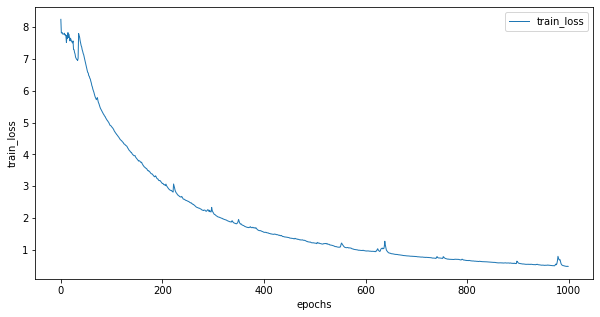

In [ ]:

#DS = os.sep
#bs = os.path.dirname(__file__) + DS


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu")
VOCAB_SIZE = len(encTool.i2w)+1
#モデル生成
print('Build model...')
model = RNNLM(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, batch_size=BATCH_SIZE).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=0)
optimizer = optim.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), amsgrad=True)
hist = {'train_loss': [], 'ppl':[]}

def make_melody(model, start_ids, length=400, skip_ids=None, prob=True, seed=2021, batch_size=1):
  '''
  args:
  model:入力モデル
  start_ids:最初の入力となるnote のid
  length:出力長
  prob:確率的に予測結果を選択するか否か
  seed:prob=True のときのランダムシード
  '''
  word_ids = []
  word_ids += start_ids
  #勾配の自動計算防止
  with torch.no_grad():
    model.eval() #BatchNorm やdropout をOFF
    input_id = start_ids
    while len(word_ids) < length:
      input = torch.tensor(input_id, dtype=torch.long,
                          device=device).view(batch_size, -1).t().contiguous()
      #input = torch.tensor(input_id, device=device)
      output = model(input)
      #output, hidden = model(input)
      # outputは(時系列長, バッチサイズ=1, 語彙数)
      p_list = F.softmax(output[-1].flatten(), dim=0)
      # 確率的に選択(重み付きランダムサンプリング)
      if prob:
        while True:
          rnd = random.random()
          p_sum = 0
          for idx, p in enumerate(p_list):
            p_sum += p.item()
            if rnd < p_sum:
              sampled = idx
              break
          # skip_idsに含まれる時はやり直し
          if (skip_ids is None) or (sampled not in skip_ids):
            break
      # 決定的に選択
      else:
        if skip_ids is not None:
          p_list[skip_ids] = 0
          sampled = p_list.argmax().item()

      word_ids.append(sampled)
      input_id = sampled
  return word_ids

def compute_loss(label, pred):
    return criterion(pred, label)

def train_step(x, t):
    model.train()
    model.init_hidden()
    preds = model(x)
    loss = compute_loss(t.view(-1),
                        preds.view(-1, preds.size(-1)))
    optimizer.zero_grad() #勾配が累積されるのを防ぐ
    loss.backward()
    optimizer.step() #パラメータ更新

    return loss, preds

for epoch in tqdm(range(epochs)):
    print('-' * 20)
    print('epoch: {}'.format(epoch+1))
    train_loss = 0.
    loss_count = 0

    for (x, t) in data_loader:
        x, t = x.to(device), t.to(device)
        loss, _ = train_step(x, t)
        train_loss += loss.item()
        loss_count += 1
    # perplexity
    ppl = np.exp(train_loss / loss_count)    
    train_loss /= len(data_loader)
    print('train_loss: {:.3f}, ppl: {:.3f}'.format(train_loss, ppl))
    #出力を見る

    hist["train_loss"].append(train_loss)
    hist["ppl"].append(ppl)
    # 20epochごとに保存&出力の確認を行う。
    if epoch % 20 == 0:
        model_name = DIR + "output_model/batch{}_embed{}_epoch{}.pt".format(BATCH_SIZE, EMBEDDING_DIM, epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
        }, model_name)
        print("Saving the checkpoint...")
        print("start generating melody....")
        start_ids=[]
        for _ in range(0, BATCH_SIZE):
          start_ids.append(random.randint(0, maxlength-1))
        word_ids = make_melody(model, start_ids, length=700, batch_size = BATCH_SIZE)
        text = ','.join(encTool.decode(word_ids))
        print("generate melody....")
        resultTextName = DIR + "result_txt/batch{}_embed{}_epoch{}.txt".format(BATCH_SIZE, EMBEDDING_DIM, epoch)
        file = open(resultTextName,'w+',encoding='utf-8').write(text)

torch.save(model.state_dict(), DIR+"embedding{}_v{}.pt".format(EMBEDDING_DIM, epoch))

#loss の確認
train_loss = hist['train_loss']
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss)), train_loss,
            linewidth=1,
            label='train_loss')
plt.xlabel('epochs')
plt.ylabel('train_loss')
plt.legend()
plt.show()

chunk2midi.py 

In [ ]:
def num2note_on_off(num):
  if int(num, 10) == 1:
    return "note_on"
  else:
    return "note_off"

#args = sys.argv 
resultTextList = Path(DIR + "result_txt/").glob('**/*.txt')
for resultTextName in resultTextList:
  print("converting : ", resultTextName)
  f = open(resultTextName, 'r')
  data = f.read()
  data_per_sound = data.split(",")
  textName = os.path.split(resultTextName)[1].replace(".txt", "")
  outputMidName = DIR + "result_mid/" + textName + ".mid"
  #type(note_on=1, note_off=0)_note_velocity_time
  mid = MidiFile()
  track = MidiTrack()
  mid.tracks.append(track)
  bpm = int(BPM)
  track.append(MetaMessage('set_tempo', tempo=mido.bpm2tempo(bpm)))
  for i_data in tqdm(data_per_sound):
    #print(i_data)
    if i_data == "":
      continue
    parts = i_data.split("_")
    if len(parts) != 4 or int(parts[0], 10) > 1:
      continue
    if parts[3] == "":
      continue
    if int(parts[2]) > 127:
      continue

    print(parts)
    track.append(Message(num2note_on_off(parts[0]), note=int(parts[1], 10), velocity=int(parts[2], 10), time=int(parts[3], 10)))

  mid.save(outputMidName)


converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch0.txt


100%|██████████| 700/700 [00:00<00:00, 9581.91it/s]


['1', '54', '56', '120']
['1', '79', '0', '0']
['1', '69', '0', '120']
['1', '79', '0', '0']
['1', '59', '53', '0']
['1', '55', '74', '0']
['1', '54', '74', '0']
['1', '71', '0', '0']
['1', '46', '60', '120']
['1', '69', '86', '0']
['1', '61', '62', '240']
['1', '73', '0', '0']
['1', '62', '64', '0']
['1', '67', '0', '228']
['1', '70', '0', '0']
['1', '53', '0', '0']
['1', '81', '68', '0']
['1', '71', '93', '0']
['1', '81', '75', '0']
['1', '79', '0', '0']
['1', '82', '0', '0']
['1', '72', '73', '0']
['1', '74', '68', '0']
['1', '50', '0', '120']
['1', '67', '0', '151']
['1', '80', '66', '0']
['1', '64', '35', '0']
['1', '84', '64', '0']
['1', '72', '89', '0']
['1', '44', '61', '0']
['1', '53', '50', '0']
['1', '49', '42', '120']
['1', '58', '62', '240']
['1', '63', '100', '0']
['1', '48', '75', '0']
['1', '76', '90', '120']
['1', '89', '105', '120']
['1', '68', '83', '0']
['1', '52', '62', '120']
['1', '53', '53', '0']
['1', '66', '83', '0']
['1', '76', '91', '0']
['1', '63', '66', '2

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '58', '0', '683']
['1', '77', '61', '0']
['1', '40', '74', '0']
['1', '77', '0', '0']
['1', '78', '64', '0']
['1', '70', '60', '0']
['1', '66', '85', '0']
['1', '79', '72', '360']
['1', '68', '49', '0']
['1', '52', '65', '0']
['1', '49', '0', '120']
['1', '80', '0', '0']
['1', '77', '47', '0']
['1', '51', '96', '9']
['1', '72', '38', '0']
['1', '57', '0', '120']
['1', '49', '0', '0']
['1', '83', '0', '0']
['1', '60', '66', '0']
['1', '81', '101', '0']
['1', '64', '0', '0']
['1', '45', '69', '0']
['1', '99', '66', '0']
['1', '72', '91', '0']
['1', '78', '114', '0']
['1', '81', '80', '13']
['1', '69', '0', '0']
['1', '93', '0', '0']
['1', '81', '63', '0']
['1', '68', '54', '120']
['1', '82', '34', '0']
['1', '75', '0', '90']
['1', '70', '0', '0']
['1', '69', '0', '151']
['1', '69', '75', '0']
['1', '49', '75', '0']
['1', '50', '0', '240']
['1', '61', '0', '0']
['1', '72', '96', '0']
['1', '53', '63', '0']
['1', '87', '65', '0']
['1', '80', '0', '0']
['1', '72', '0', '0']
['1', '57'

100%|██████████| 700/700 [00:00<00:00, 5086.17it/s]


['1', '70', '63', '0']
['1', '63', '54', '120']
['1', '81', '71', '0']
['1', '49', '0', '120']
['1', '70', '0', '120']
['1', '64', '0', '0']
['1', '73', '63', '0']
['1', '78', '0', '0']
['1', '83', '0', '240']
['1', '81', '0', '240']
['1', '80', '0', '0']
['1', '60', '80', '0']
['1', '84', '76', '0']
['1', '68', '61', '0']
['1', '77', '96', '17']
['1', '44', '0', '0']
['1', '50', '66', '0']
['1', '84', '0', '120']
['1', '50', '70', '0']
['1', '65', '71', '120']
['1', '105', '0', '0']
['1', '69', '0', '227']
['1', '57', '77', '0']
['1', '80', '49', '9']
['1', '79', '63', '0']
['1', '60', '78', '0']
['1', '69', '0', '3']
['1', '74', '49', '13']
['1', '55', '0', '3']
['1', '72', '0', '303']
['1', '74', '64', '37']
['1', '69', '68', '0']
['1', '72', '80', '0']
['1', '72', '64', '0']
['1', '55', '0', '120']
['1', '87', '0', '120']
['1', '52', '65', '0']
['1', '88', '84', '0']
['1', '74', '90', '0']
['1', '77', '73', '0']
['1', '58', '52', '0']
['1', '60', '81', '0']
['1', '82', '0', '240']


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '81', '117', '0']
['1', '69', '74', '0']
['1', '67', '0', '0']
['1', '65', '0', '0']
['1', '88', '89', '0']
['1', '66', '0', '151']
['1', '87', '107', '0']
['1', '72', '57', '0']
['1', '76', '87', '0']
['1', '77', '0', '0']
['1', '71', '83', '0']
['1', '81', '70', '0']
['1', '72', '80', '0']
['1', '48', '79', '0']
['1', '56', '78', '0']
['1', '66', '0', '0']
['1', '58', '62', '0']
['1', '63', '0', '75']
['1', '66', '45', '0']
['1', '70', '0', '0']
['1', '74', '96', '0']
['1', '69', '85', '0']
['1', '65', '72', '0']
['1', '87', '107', '0']
['1', '98', '81', '0']
['1', '76', '0', '240']
['1', '68', '76', '0']
['1', '86', '97', '0']
['1', '92', '88', '120']
['1', '59', '60', '0']
['1', '66', '73', '0']
['1', '50', '85', '0']
['1', '56', '0', '1920']
['1', '59', '64', '0']
['1', '65', '68', '0']
['1', '45', '62', '0']
['1', '63', '0', '75']
['1', '35', '0', '0']
['1', '78', '63', '0']
['1', '74', '68', '480']
['1', '51', '71', '0']
['1', '65', '69', '0']
['1', '82', '93', '0']
['1', 

100%|██████████| 700/700 [00:00<00:00, 7640.04it/s]



['1', '72', '0', '0']
['1', '75', '0', '120']
['1', '60', '57', '0']
['1', '56', '0', '120']
['1', '60', '57', '0']
['1', '86', '75', '0']
['1', '82', '87', '0']
['1', '76', '0', '0']
['1', '81', '68', '240']
['1', '68', '75', '240']
['1', '73', '88', '0']
['1', '71', '0', '151']
['1', '83', '107', '0']
['1', '90', '0', '0']
['1', '89', '60', '0']
['1', '61', '0', '0']
['1', '62', '72', '0']
['1', '52', '0', '120']
['1', '70', '0', '120']
['1', '75', '53', '0']
['1', '79', '72', '0']
['1', '69', '0', '303']
['1', '69', '64', '0']
['1', '69', '0', '0']
['1', '63', '0', '0']
['1', '66', '0', '0']
['1', '67', '61', '480']
['1', '79', '64', '13']
['1', '62', '67', '0']
['1', '81', '81', '0']
['1', '65', '52', '0']
['1', '91', '84', '0']
['1', '79', '96', '0']
['1', '79', '101', '0']
['1', '70', '0', '0']
['1', '66', '73', '0']
['1', '68', '49', '25']
['1', '73', '54', '0']
['1', '77', '91', '0']
['1', '63', '0', '120']
['1', '73', '0', '3']
['1', '48', '71', '0']
['1', '73', '32', '0']
['

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '38', '80', '120']
['1', '72', '96', '0']
['1', '63', '71', '0']
['1', '77', '59', '120']
['1', '52', '77', '0']
['1', '76', '115', '120']
['1', '72', '80', '0']
['1', '65', '0', '911']
['1', '65', '67', '480']
['1', '46', '71', '0']
['1', '72', '90', '0']
['1', '63', '70', '120']
['1', '87', '102', '0']
['1', '84', '0', '240']
['1', '68', '0', '0']
['1', '81', '40', '0']
['1', '75', '0', '455']
['1', '68', '0', '0']
['1', '56', '71', '0']
['1', '90', '0', '360']
['1', '62', '66', '0']
['1', '63', '35', '120']
['1', '58', '0', '0']
['1', '64', '69', '0']
['1', '80', '0', '303']
['1', '63', '70', '0']
['1', '85', '84', '0']
['1', '73', '77', '360']
['1', '74', '78', '0']
['1', '45', '76', '0']
['1', '77', '73', '0']
['1', '67', '0', '0']
['1', '63', '0', '0']
['1', '76', '87', '0']
['1', '73', '83', '0']
['1', '58', '47', '0']
['1', '73', '70', '0']
['1', '79', '64', '0']
['1', '69', '53', '0']
['1', '72', '62', '0']
['1', '51', '66', '120']
['1', '75', '64', '0']
['1', '71', '73'

100%|██████████| 700/700 [00:00<00:00, 4274.52it/s]


['1', '65', '0', '0']
['1', '83', '88', '0']
['1', '76', '0', '151']
['1', '47', '79', '0']
['1', '72', '0', '303']
['1', '50', '62', '0']
['1', '64', '64', '0']
['1', '83', '89', '0']
['1', '51', '0', '480']
['1', '56', '0', '120']
['1', '87', '0', '0']
['1', '79', '80', '6']
['1', '79', '46', '0']
['1', '75', '56', '25']
['1', '48', '60', '120']
['1', '69', '45', '0']
['1', '67', '79', '0']
['1', '78', '90', '120']
['1', '84', '74', '0']
['1', '60', '74', '0']
['1', '71', '0', '120']
['1', '91', '0', '0']
['1', '76', '0', '113']
['1', '45', '71', '0']
['1', '87', '117', '0']
['1', '90', '94', '0']
['1', '65', '0', '360']
['1', '46', '0', '120']
['1', '75', '0', '0']
['1', '64', '49', '7']
['1', '89', '62', '120']
['1', '50', '80', '0']
['1', '108', '0', '120']
['1', '48', '0', '480']
['1', '68', '78', '0']
['1', '54', '63', '0']
['1', '58', '0', '0']
['1', '74', '61', '0']
['1', '64', '0', '227']
['1', '88', '99', '0']
['1', '78', '68', '720']
['1', '81', '0', '0']
['1', '88', '116'

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch80.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '67', '0', '111']
['1', '89', '0', '0']
['1', '93', '75', '0']
['1', '90', '103', '0']
['1', '84', '90', '0']
['1', '81', '106', '0']
['1', '54', '80', '0']
['1', '72', '49', '0']
['1', '74', '0', '227']
['1', '69', '0', '0']
['1', '80', '61', '0']
['1', '71', '0', '3']
['1', '93', '77', '0']
['1', '86', '84', '0']
['1', '80', '0', '120']
['1', '77', '90', '0']
['1', '73', '86', '0']
['1', '83', '82', '0']
['1', '78', '87', '0']
['1', '42', '0', '120']
['1', '69', '0', '0']
['1', '90', '78', '0']
['1', '58', '0', '360']
['1', '90', '0', '240']
['1', '69', '0', '0']
['1', '72', '96', '17']
['1', '82', '116', '0']
['1', '76', '101', '0']
['1', '59', '0', '683']
['1', '81', '0', '0']
['1', '74', '95', '0']
['1', '57', '77', '0']
['1', '70', '0', '75']
['1', '68', '61', '0']
['1', '61', '0', '0']
['1', '66', '64', '0']
['1', '74', '57', '0']
['1', '80', '59', '0']
['1', '71', '82', '120']
['1', '69', '82', '0']
['1', '60', '0', '51']
['1', '77', '0', '120']
['1', '51', '50', '0']
['1

100%|██████████| 700/700 [00:00<00:00, 7049.56it/s]

['1', '67', '0', '120']
['1', '60', '0', '0']
['1', '71', '82', '0']
['1', '88', '0', '240']
['1', '67', '0', '0']
['1', '88', '76', '0']
['1', '79', '105', '0']
['1', '67', '62', '0']
['1', '80', '72', '0']
['1', '72', '0', '0']
['1', '70', '0', '0']
['1', '76', '79', '0']
['1', '88', '63', '0']
['1', '33', '74', '0']
['1', '54', '0', '3']
['1', '64', '0', '0']
['1', '67', '66', '0']
['1', '50', '0', '240']
['1', '76', '69', '0']
['1', '70', '73', '0']
['1', '65', '80', '0']
['1', '105', '68', '0']
['1', '86', '106', '120']
['1', '73', '0', '240']
['1', '75', '116', '0']
['1', '64', '100', '0']
['1', '70', '58', '0']
['1', '77', '63', '0']
['1', '66', '86', '120']
['1', '87', '81', '0']
['1', '77', '85', '0']
['1', '84', '102', '0']
['1', '71', '100', '0']
['1', '71', '0', '120']
['1', '89', '0', '0']
['1', '93', '64', '0']
['1', '76', '75', '0']
['1', '66', '80', '0']
['1', '58', '0', '455']
['1', '71', '0', '0']
['1', '84', '0', '0']
['1', '82', '81', '0']
['1', '69', '73', '0']
['1

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch100.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '59', '67', '360']
['1', '59', '48', '0']
['1', '68', '0', '0']
['1', '73', '64', '25']
['1', '88', '115', '0']
['1', '71', '73', '0']
['1', '74', '62', '0']
['1', '67', '0', '240']
['1', '84', '75', '0']
['1', '78', '0', '240']
['1', '62', '0', '0']
['1', '79', '76', '0']
['1', '75', '47', '0']
['1', '58', '83', '240']
['1', '69', '0', '0']
['1', '67', '0', '0']
['1', '85', '0', '0']
['1', '83', '80', '9']
['1', '71', '64', '0']
['1', '52', '0', '120']
['1', '63', '0', '0']
['1', '60', '60', '0']
['1', '52', '78', '0']
['1', '74', '102', '0']
['1', '64', '0', '0']
['1', '92', '0', '0']
['1', '65', '64', '7']
['1', '72', '77', '120']
['1', '77', '0', '120']
['1', '70', '82', '0']
['1', '74', '0', '240']
['1', '66', '0', '0']
['1', '60', '67', '0']
['1', '54', '76', '0']
['1', '83', '65', '0']
['1', '74', '60', '0']
['1', '47', '0', '480']
['1', '74', '0', '0']
['1', '84', '80', '0']
['1', '57', '0', '120']
['1', '90', '0', '0']
['1', '85', '0', '0']
['1', '53', '66', '0']
['1', '

100%|██████████| 700/700 [00:00<00:00, 8830.70it/s]



['1', '59', '70', '0']
['1', '46', '71', '240']
['1', '85', '78', '0']
['1', '87', '0', '120']
['1', '48', '0', '120']
['1', '64', '0', '0']
['1', '43', '62', '0']
['1', '54', '64', '13']
['1', '83', '96', '0']
['1', '65', '82', '0']
['1', '71', '68', '120']
['1', '80', '71', '0']
['1', '80', '102', '0']
['1', '75', '0', '0']
['1', '82', '74', '120']
['1', '81', '77', '0']
['1', '50', '0', '0']
['1', '65', '72', '0']
['1', '64', '0', '480']
['1', '75', '60', '0']
['1', '82', '75', '0']
['1', '65', '60', '240']
['1', '60', '0', '0']
['1', '94', '0', '240']
['1', '53', '70', '0']
['1', '52', '0', '120']
['1', '69', '0', '0']
['1', '87', '0', '0']
['1', '70', '56', '0']
['1', '75', '0', '240']
['1', '67', '0', '0']
['1', '72', '0', '0']
['1', '81', '59', '0']
['1', '76', '88', '0']
['1', '60', '74', '240']
['1', '50', '0', '0']
['1', '72', '62', '0']
['1', '62', '0', '240']
['1', '58', '0', '0']
['1', '62', '74', '0']
['1', '68', '70', '0']
['1', '79', '101', '0']
['1', '65', '91', '0']


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '94', '95', '0']
['1', '80', '0', '0']
['1', '94', '0', '0']
['1', '69', '0', '0']
['1', '71', '91', '0']
['1', '84', '0', '120']
['1', '75', '69', '0']
['1', '67', '0', '240']
['1', '73', '0', '0']
['1', '67', '64', '25']
['1', '77', '80', '5']
['1', '48', '37', '0']
['1', '67', '49', '7']
['1', '59', '75', '240']
['1', '78', '64', '19']
['1', '64', '64', '49']
['1', '71', '59', '0']
['1', '49', '62', '240']
['1', '48', '0', '480']
['1', '67', '0', '0']
['1', '70', '0', '0']
['1', '51', '0', '0']
['1', '73', '0', '0']
['1', '78', '63', '240']
['1', '77', '95', '0']
['1', '84', '90', '0']
['1', '71', '81', '0']
['1', '41', '67', '0']
['1', '48', '0', '360']
['1', '74', '0', '0']
['1', '57', '64', '0']
['1', '90', '83', '0']
['1', '52', '0', '120']
['1', '77', '0', '0']
['1', '56', '79', '0']
['1', '89', '116', '0']
['1', '84', '104', '120']
['1', '44', '75', '0']
['1', '50', '70', '0']
['1', '80', '75', '0']
['1', '90', '56', '0']
['1', '59', '81', '0']
['1', '63', '62', '0']
['1

100%|██████████| 700/700 [00:00<00:00, 4486.19it/s]

['1', '66', '0', '0']
['1', '81', '0', '0']
['1', '85', '64', '25']
['1', '58', '69', '0']
['1', '69', '39', '0']
['1', '74', '64', '25']
['1', '72', '84', '0']
['1', '50', '58', '0']
['1', '57', '64', '0']
['1', '47', '44', '120']
['1', '62', '64', '0']
['1', '74', '78', '0']
['1', '80', '77', '0']
['1', '74', '0', '720']
['1', '76', '0', '0']
['1', '85', '0', '0']
['1', '74', '74', '0']
['1', '81', '97', '0']
['1', '83', '64', '68']
['1', '80', '0', '0']
['1', '39', '74', '0']
['1', '80', '62', '0']
['1', '84', '0', '0']
['1', '44', '73', '0']
['1', '53', '0', '120']
['1', '78', '64', '0']
['1', '79', '68', '0']
['1', '43', '0', '480']
['1', '75', '0', '0']
['1', '83', '0', '0']
['1', '69', '59', '0']
['1', '64', '0', '480']
['1', '63', '0', '120']
['1', '72', '62', '0']
['1', '65', '0', '120']
['1', '78', '0', '0']
['1', '85', '0', '0']
['1', '42', '71', '0']
['1', '87', '0', '0']
['1', '58', '69', '0']
['1', '83', '0', '455']
['1', '66', '61', '0']
['1', '88', '76', '0']
['1', '54'

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch140.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '69', '80', '6']
['1', '84', '105', '0']
['1', '83', '0', '0']
['1', '91', '0', '0']
['1', '85', '64', '25']
['1', '86', '66', '0']
['1', '65', '0', '227']
['1', '71', '0', '0']
['1', '51', '71', '0']
['1', '92', '0', '0']
['1', '78', '0', '227']
['1', '86', '102', '0']
['1', '101', '0', '120']
['1', '82', '80', '9']
['1', '95', '0', '0']
['1', '55', '81', '0']
['1', '70', '64', '0']
['1', '63', '64', '0']
['1', '65', '0', '98']
['1', '63', '0', '0']
['1', '71', '0', '0']
['1', '81', '56', '0']
['1', '45', '0', '120']
['1', '68', '0', '0']
['1', '56', '0', '0']
['1', '81', '0', '0']
['1', '68', '64', '25']
['1', '74', '67', '0']
['1', '82', '77', '0']
['1', '59', '72', '0']
['1', '82', '72', '0']
['1', '81', '76', '0']
['1', '75', '0', '911']
['1', '71', '0', '0']
['1', '81', '0', '0']
['1', '88', '76', '0']
['1', '54', '0', '720']
['1', '71', '0', '0']
['1', '69', '64', '0']
['1', '85', '64', '0']
['1', '76', '0', '0']
['1', '58', '64', '0']
['1', '82', '115', '0']
['1', '51', '

100%|██████████| 700/700 [00:00<00:00, 8476.57it/s]



['1', '78', '75', '0']
['1', '76', '0', '120']
['1', '77', '84', '0']
['1', '76', '100', '0']
['1', '76', '64', '25']
['1', '77', '76', '0']
['1', '44', '0', '240']
['1', '75', '0', '0']
['1', '67', '0', '120']
['1', '61', '66', '0']
['1', '96', '88', '0']
['1', '90', '116', '0']
['1', '81', '94', '0']
['1', '52', '0', '720']
['1', '74', '0', '0']
['1', '78', '69', '0']
['1', '78', '77', '0']
['1', '86', '100', '0']
['1', '88', '0', '474']
['1', '63', '56', '0']
['1', '40', '0', '240']
['1', '75', '0', '0']
['1', '61', '77', '0']
['1', '84', '91', '0']
['1', '96', '64', '0']
['1', '40', '0', '240']
['1', '56', '69', '0']
['1', '94', '88', '0']
['1', '76', '115', '120']
['1', '98', '80', '0']
['1', '70', '0', '720']
['1', '73', '0', '0']
['1', '88', '88', '0']
['1', '82', '89', '0']
['1', '79', '41', '0']
['1', '76', '116', '0']
['1', '86', '50', '0']
['1', '93', '95', '0']
['1', '76', '44', '0']
['1', '92', '63', '0']
['1', '78', '64', '7']
['1', '60', '0', '0']
['1', '84', '90', '0']

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '77', '103', '240']
['1', '70', '0', '0']
['1', '63', '67', '0']
['1', '68', '0', '240']
['1', '59', '67', '0']
['1', '81', '94', '0']
['1', '81', '76', '0']
['1', '85', '0', '120']
['1', '85', '75', '0']
['1', '81', '87', '0']
['1', '83', '67', '0']
['1', '77', '43', '0']
['1', '80', '101', '0']
['1', '78', '0', '0']
['1', '84', '0', '0']
['1', '56', '67', '0']
['1', '87', '77', '0']
['1', '82', '100', '0']
['1', '82', '0', '120']
['1', '61', '59', '0']
['1', '79', '0', '120']
['1', '63', '75', '240']
['1', '82', '0', '240']
['1', '66', '0', '240']
['1', '68', '0', '0']
['1', '70', '0', '0']
['1', '50', '0', '0']
['1', '67', '77', '0']
['1', '77', '83', '0']
['1', '82', '82', '0']
['1', '52', '62', '240']
['1', '84', '0', '10']
['1', '70', '45', '0']
['1', '43', '0', '240']
['1', '76', '73', '0']
['1', '75', '0', '720']
['1', '71', '0', '0']
['1', '82', '80', '9']
['1', '62', '69', '0']
['1', '73', '66', '0']
['1', '91', '64', '0']
['1', '84', '0', '240']
['1', '62', '76', '0']


100%|██████████| 700/700 [00:00<00:00, 4288.39it/s]


['1', '60', '65', '0']
['1', '48', '0', '120']
['1', '63', '0', '0']
['1', '55', '74', '0']
['1', '63', '49', '7']
['1', '65', '64', '0']
['1', '80', '100', '0']
['1', '66', '71', '0']
['1', '80', '88', '0']
['1', '79', '114', '0']
['1', '75', '67', '0']
['1', '78', '81', '0']
['1', '84', '106', '0']
['1', '84', '88', '0']
['1', '81', '0', '120']
['1', '77', '0', '0']
['1', '63', '67', '0']
['1', '72', '0', '240']
['1', '54', '74', '0']
['1', '59', '0', '120']
['1', '54', '54', '0']
['1', '50', '0', '0']
['1', '65', '73', '0']
['1', '72', '100', '0']
['1', '77', '80', '120']
['1', '77', '0', '120']
['1', '81', '0', '0']
['1', '59', '96', '17']
['1', '71', '61', '0']
['1', '79', '0', '113']
['1', '75', '80', '0']
['1', '81', '101', '0']
['1', '57', '0', '480']
['1', '66', '0', '0']
['1', '42', '74', '0']
['1', '77', '28', '0']
['1', '78', '84', '0']
['1', '56', '60', '0']
['1', '87', '89', '0']
['1', '51', '0', '360']
['1', '52', '75', '0']
['1', '71', '0', '303']
['1', '59', '0', '0']


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '79', '84', '120']
['1', '82', '0', '0']
['1', '89', '0', '0']
['1', '85', '0', '0']
['1', '66', '46', '0']
['1', '66', '64', '0']
['1', '80', '57', '0']
['1', '78', '80', '0']
['1', '59', '0', '240']
['1', '70', '0', '0']
['1', '76', '0', '0']
['1', '53', '76', '0']
['1', '61', '64', '0']
['1', '86', '83', '0']
['1', '78', '99', '0']
['1', '79', '49', '7']
['1', '49', '0', '120']
['1', '71', '61', '0']
['1', '47', '0', '240']
['1', '71', '0', '0']
['1', '67', '0', '0']
['1', '74', '65', '0']
['1', '82', '57', '0']
['1', '82', '89', '0']
['1', '52', '0', '240']
['1', '70', '0', '0']
['1', '68', '0', '0']
['1', '73', '0', '120']
['1', '71', '61', '0']
['1', '80', '80', '0']
['1', '83', '83', '0']
['1', '55', '61', '0']
['1', '99', '66', '120']
['1', '78', '0', '120']
['1', '48', '0', '0']
['1', '66', '70', '0']
['1', '79', '0', '3']
['1', '63', '0', '0']
['1', '87', '0', '0']
['1', '91', '0', '0']
['1', '68', '0', '75']
['1', '58', '60', '0']
['1', '51', '0', '120']
['1', '70', '0

100%|██████████| 700/700 [00:00<00:00, 6547.51it/s]



['1', '53', '0', '120']
['1', '71', '0', '0']
['1', '64', '64', '0']
['1', '79', '0', '480']
['1', '78', '66', '120']
['1', '83', '99', '0']
['1', '77', '63', '0']
['1', '42', '85', '0']
['1', '79', '0', '0']
['1', '59', '73', '120']
['1', '83', '46', '0']
['1', '81', '92', '0']
['1', '84', '64', '0']
['1', '87', '66', '0']
['1', '48', '0', '360']
['1', '73', '0', '0']
['1', '81', '67', '0']
['1', '78', '57', '0']
['1', '85', '0', '4']
['1', '59', '0', '240']
['1', '75', '0', '0']
['1', '69', '0', '0']
['1', '60', '66', '0']
['1', '72', '76', '0']
['1', '57', '60', '0']
['1', '85', '0', '120']
['1', '72', '64', '0']
['1', '67', '64', '0']
['1', '67', '0', '130']
['1', '64', '0', '0']
['1', '66', '70', '0']
['1', '49', '0', '120']
['1', '73', '0', '0']
['1', '45', '74', '0']
['1', '77', '64', '69']
['1', '61', '0', '0']
['1', '71', '77', '0']
['1', '57', '71', '0']
['1', '76', '101', '0']
['1', '63', '67', '480']
['1', '84', '87', '0']
['1', '81', '0', '480']
['1', '61', '64', '0']
['1

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '52', '58', '0']
['1', '86', '64', '0']
['1', '93', '0', '0']
['1', '96', '0', '0']
['1', '91', '0', '0']
['1', '82', '64', '19']
['1', '93', '0', '0']
['1', '69', '64', '0']
['1', '89', '95', '0']
['1', '56', '59', '0']
['1', '57', '0', '240']
['1', '74', '0', '0']
['1', '85', '60', '25']
['1', '88', '0', '0']
['1', '50', '67', '0']
['1', '95', '88', '0']
['1', '55', '77', '0']
['1', '75', '0', '113']
['1', '70', '0', '0']
['1', '79', '0', '0']
['1', '47', '64', '0']
['1', '85', '68', '0']
['1', '86', '98', '0']
['1', '43', '0', '480']
['1', '65', '0', '0']
['1', '84', '0', '0']
['1', '80', '0', '0']
['1', '53', '61', '0']
['1', '51', '56', '120']
['1', '64', '0', '0']
['1', '80', '0', '0']
['1', '78', '66', '0']
['1', '78', '0', '227']
['1', '61', '0', '0']
['1', '65', '0', '240']
['1', '81', '81', '0']
['1', '85', '77', '0']
['1', '52', '52', '240']
['1', '78', '0', '0']
['1', '85', '0', '0']
['1', '48', '70', '0']
['1', '61', '61', '0']
['1', '80', '100', '0']
['1', '78', '51

100%|██████████| 700/700 [00:00<00:00, 4591.30it/s]

['1', '60', '64', '0']
['1', '74', '78', '0']
['1', '74', '64', '145']
['1', '68', '75', '0']
['1', '64', '0', '0']
['1', '47', '64', '0']
['1', '75', '62', '0']
['1', '86', '100', '0']
['1', '61', '0', '131']
['1', '73', '0', '0']
['1', '50', '57', '0']
['1', '83', '64', '120']
['1', '78', '105', '240']
['1', '59', '0', '0']
['1', '69', '59', '0']
['1', '80', '71', '0']
['1', '55', '0', '0']
['1', '65', '64', '0']
['1', '58', '0', '240']


converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch220.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '68', '101', '0']
['1', '87', '64', '0']
['1', '53', '0', '480']
['1', '58', '64', '0']
['1', '57', '64', '0']
['1', '85', '80', '0']
['1', '89', '0', '120']
['1', '57', '0', '120']
['1', '76', '0', '0']
['1', '78', '64', '0']
['1', '77', '94', '0']
['1', '62', '71', '0']
['1', '64', '41', '0']
['1', '70', '0', '0']
['1', '41', '0', '0']
['1', '53', '61', '0']
['1', '96', '0', '240']
['1', '64', '0', '0']
['1', '51', '65', '0']
['1', '61', '0', '0']
['1', '69', '0', '0']
['1', '48', '61', '0']
['1', '94', '0', '120']
['1', '60', '62', '0']
['1', '47', '0', '480']
['1', '76', '0', '0']
['1', '55', '74', '0']
['1', '77', '83', '0']
['1', '78', '69', '0']
['1', '87', '0', '303']
['1', '56', '0', '0']
['1', '71', '0', '0']
['1', '73', '82', '0']
['1', '69', '0', '240']
['1', '72', '62', '0']
['1', '47', '0', '120']
['1', '71', '0', '0']
['1', '58', '0', '0']
['1', '60', '64', '0']
['1', '76', '74', '0']
['1', '84', '85', '0']
['1', '84', '0', '240']
['1', '78', '0', '0']
['1', '45', 

100%|██████████| 700/700 [00:00<00:00, 7103.93it/s]



['1', '74', '0', '0']
['1', '48', '74', '0']
['1', '60', '0', '240']
['1', '78', '0', '0']
['1', '42', '0', '0']
['1', '45', '70', '0']
['1', '70', '63', '0']
['1', '50', '0', '480']
['1', '54', '64', '0']
['1', '58', '78', '0']
['1', '75', '0', '120']
['1', '61', '64', '0']
['1', '83', '79', '0']
['1', '81', '95', '0']
['1', '82', '0', '113']
['1', '65', '90', '0']
['1', '55', '64', '120']
['1', '71', '0', '240']
['1', '77', '0', '0']
['1', '75', '49', '0']
['1', '64', '51', '0']
['1', '84', '73', '0']
['1', '81', '117', '0']
['1', '64', '53', '0']
['1', '68', '0', '227']
['1', '66', '0', '0']
['1', '42', '67', '0']
['1', '70', '61', '0']
['1', '70', '0', '120']
['1', '71', '0', '0']
['1', '92', '0', '0']
['1', '70', '61', '0']
['1', '85', '100', '0']
['1', '82', '114', '240']
['1', '82', '56', '0']
['1', '75', '64', '7']
['1', '64', '0', '0']
['1', '59', '0', '0']
['1', '46', '0', '240']
['1', '59', '60', '0']
['1', '49', '0', '120']
['1', '76', '0', '0']
['1', '55', '74', '0']
['1'

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '80', '80', '5']
['1', '67', '64', '25']
['1', '92', '0', '0']
['1', '65', '81', '0']
['1', '79', '117', '0']
['1', '53', '69', '0']
['1', '49', '0', '480']
['1', '44', '0', '0']
['1', '59', '64', '0']
['1', '72', '0', '240']
['1', '64', '64', '0']
['1', '90', '90', '0']
['1', '86', '94', '0']
['1', '81', '0', '360']
['1', '83', '83', '0']
['1', '85', '101', '0']
['1', '85', '66', '0']
['1', '45', '0', '240']
['1', '54', '60', '0']
['1', '52', '0', '120']
['1', '83', '0', '0']
['1', '55', '67', '0']
['1', '67', '64', '0']
['1', '80', '66', '0']
['1', '57', '60', '0']
['1', '81', '82', '0']
['1', '52', '77', '0']
['1', '62', '0', '0']
['1', '69', '0', '0']
['1', '46', '65', '0']
['1', '41', '0', '0']
['1', '60', '73', '0']
['1', '91', '80', '0']
['1', '80', '100', '0']
['1', '74', '85', '120']
['1', '56', '61', '240']
['1', '74', '0', '113']
['1', '57', '67', '120']
['1', '48', '0', '0']
['1', '62', '61', '0']
['1', '81', '101', '0']
['1', '82', '0', '120']
['1', '71', '0', '0']
[

100%|██████████| 700/700 [00:00<00:00, 7372.25it/s]


['1', '71', '0', '0']
['1', '52', '65', '0']
['1', '55', '70', '0']
['1', '62', '70', '0']
['1', '84', '88', '240']
['1', '79', '0', '480']
['1', '68', '65', '0']
['1', '76', '77', '120']
['1', '74', '86', '120']
['1', '79', '0', '303']
['1', '49', '75', '0']
['1', '69', '0', '240']
['1', '62', '0', '0']
['1', '59', '60', '0']
['1', '71', '0', '120']
['1', '74', '0', '0']
['1', '60', '56', '0']
['1', '71', '0', '135']
['1', '79', '105', '0']
['1', '64', '49', '0']
['1', '67', '80', '13']
['1', '67', '82', '0']
['1', '56', '65', '0']
['1', '61', '0', '130']
['1', '62', '64', '0']
['1', '67', '67', '0']
['1', '38', '0', '0']
['1', '52', '77', '0']
['1', '91', '81', '0']
['1', '86', '115', '480']
['1', '57', '70', '0']
['1', '78', '0', '113']
['1', '67', '79', '0']
['1', '67', '63', '0']
['1', '69', '52', '0']
['1', '79', '69', '0']
['1', '80', '49', '13']
['1', '64', '0', '0']
['1', '68', '0', '0']
['1', '75', '66', '0']
['1', '76', '78', '0']
['1', '88', '0', '120']
['1', '73', '0', '24

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '88', '64', '13']
['1', '91', '88', '0']
['1', '73', '64', '7']
['1', '74', '64', '0']
['1', '45', '0', '120']
['1', '73', '0', '0']
['1', '58', '79', '0']
['1', '57', '0', '120']
['1', '63', '0', '0']
['1', '46', '59', '0']
['1', '62', '74', '0']
['1', '62', '0', '0']
['1', '54', '65', '0']
['1', '49', '0', '240']
['1', '78', '0', '0']
['1', '58', '64', '0']
['1', '73', '84', '0']
['1', '81', '65', '0']
['1', '89', '74', '0']
['1', '83', '0', '120']
['1', '51', '70', '0']
['1', '82', '0', '120']
['1', '70', '61', '0']
['1', '78', '81', '0']
['1', '79', '0', '113']
['1', '78', '0', '0']
['1', '79', '80', '9']
['1', '54', '64', '0']
['1', '57', '0', '120']
['1', '85', '79', '0']
['1', '64', '72', '0']
['1', '88', '96', '0']
['1', '86', '0', '120']
['1', '59', '0', '120']
['1', '68', '0', '0']
['1', '58', '64', '0']
['1', '71', '0', '120']
['1', '60', '0', '0']
['1', '76', '0', '303']
['1', '65', '67', '0']
['1', '79', '0', '120']
['1', '86', '86', '0']
['1', '79', '0', '480']
['1'

 78%|███████▊  | 545/700 [00:00<00:00, 3660.12it/s]


['1', '85', '64', '0']
['1', '60', '0', '455']
['1', '76', '0', '0']
['1', '83', '0', '0']
['1', '67', '85', '0']
['1', '83', '81', '120']
['1', '57', '75', '0']
['1', '82', '81', '0']
['1', '85', '94', '0']
['1', '79', '0', '113']
['1', '67', '0', '0']
['1', '67', '0', '0']
['1', '73', '61', '0']
['1', '52', '0', '240']
['1', '70', '0', '0']
['1', '47', '64', '0']
['1', '67', '0', '120']
['1', '54', '60', '0']
['1', '52', '0', '0']
['1', '47', '64', '0']
['1', '57', '60', '0']
['1', '54', '0', '240']
['1', '56', '0', '120']
['1', '75', '0', '0']
['1', '50', '75', '0']

100%|██████████| 700/700 [00:00<00:00, 4091.24it/s]



['1', '55', '62', '0']
['1', '56', '71', '0']
['1', '80', '81', '0']
['1', '57', '0', '240']
['1', '68', '0', '0']
['1', '82', '0', '120']
['1', '50', '0', '120']
['1', '59', '68', '0']
['1', '74', '73', '0']
['1', '78', '75', '0']
['1', '69', '0', '6']
['1', '71', '0', '0']
['1', '60', '64', '0']
['1', '62', '74', '0']
['1', '83', '93', '0']
['1', '91', '64', '0']
['1', '67', '69', '120']
['1', '67', '90', '0']
['1', '52', '77', '0']
['1', '59', '0', '0']
['1', '62', '65', '0']
['1', '68', '80', '0']
['1', '69', '52', '0']
['1', '78', '0', '113']
['1', '64', '77', '0']
['1', '55', '0', '120']
['1', '45', '0', '0']
['1', '62', '63', '0']
['1', '67', '77', '0']
['1', '82', '85', '0']
['1', '83', '64', '0']
['1', '52', '77', '0']
['1', '47', '74', '0']
['1', '59', '44', '0']
['1', '86', '0', '120']
['1', '85', '0', '120']
['1', '51', '77', '0']
['1', '66', '64', '0']
['1', '75', '0', '600']
['1', '68', '0', '0']
['1', '58', '80', '0']
['1', '76', '80', '0']
['1', '69', '44', '0']
['1', 

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '75', '106', '0']
['1', '70', '0', '455']
['1', '73', '0', '0']
['1', '78', '61', '0']
['1', '95', '0', '0']
['1', '53', '64', '0']
['1', '63', '67', '0']
['1', '75', '0', '911']
['1', '62', '0', '0']
['1', '67', '0', '0']
['1', '65', '64', '0']
['1', '60', '0', '0']
['1', '48', '64', '0']
['1', '93', '78', '0']
['1', '71', '63', '0']
['1', '68', '94', '0']
['1', '74', '68', '0']
['1', '74', '67', '13']
['1', '76', '56', '0']
['1', '88', '0', '120']
['1', '42', '0', '360']
['1', '61', '64', '0']
['1', '68', '100', '0']
['1', '80', '0', '600']
['1', '59', '74', '0']
['1', '55', '0', '240']
['1', '66', '0', '0']
['1', '47', '64', '0']
['1', '72', '63', '0']
['1', '92', '82', '0']
['1', '69', '0', '0']
['1', '48', '65', '0']
['1', '45', '0', '0']
['1', '53', '74', '0']
['1', '66', '70', '0']
['1', '70', '79', '480']
['1', '62', '0', '0']
['1', '61', '0', '0']
['1', '79', '81', '0']
['1', '62', '64', '0']
['1', '75', '63', '0']
['1', '59', '0', '0']
['1', '69', '0', '0']
['1', '62', 

100%|██████████| 700/700 [00:00<00:00, 6894.98it/s]


['1', '70', '82', '0']
['1', '74', '0', '75']
['1', '79', '0', '0']
['1', '71', '68', '0']
['1', '80', '97', '0']
['1', '85', '78', '0']
['1', '79', '101', '0']
['1', '62', '0', '131']
['1', '81', '0', '0']
['1', '61', '67', '0']
['1', '69', '74', '0']
['1', '92', '90', '0']
['1', '77', '77', '360']
['1', '70', '69', '360']
['1', '59', '0', '0']
['1', '71', '0', '0']
['1', '83', '77', '0']
['1', '62', '0', '0']
['1', '67', '90', '0']
['1', '65', '38', '0']
['1', '62', '0', '240']
['1', '77', '0', '0']
['1', '50', '72', '0']
['1', '63', '74', '0']
['1', '76', '0', '360']
['1', '70', '72', '0']
['1', '85', '89', '0']
['1', '66', '57', '0']
['1', '87', '63', '0']
['1', '45', '67', '0']
['1', '72', '63', '0']
['1', '86', '77', '0']
['1', '84', '100', '0']
['1', '75', '0', '227']
['1', '63', '0', '0']
['1', '59', '64', '0']
['1', '70', '64', '0']
['1', '55', '0', '0']
['1', '53', '0', '120']
['1', '56', '53', '0']
['1', '67', '79', '0']
['1', '86', '100', '0']
['1', '78', '68', '0']
['1', '

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '51', '68', '120']
['1', '84', '61', '0']
['1', '76', '0', '0']
['1', '90', '0', '0']
['1', '69', '64', '0']
['1', '71', '67', '0']
['1', '57', '64', '7']
['1', '64', '0', '0']
['1', '54', '64', '0']
['1', '75', '100', '0']
['1', '84', '80', '0']
['1', '48', '0', '0']
['1', '76', '94', '0']
['1', '85', '99', '0']
['1', '85', '49', '13']
['1', '47', '64', '0']
['1', '81', '0', '240']
['1', '60', '70', '0']
['1', '74', '80', '0']
['1', '59', '59', '0']
['1', '46', '54', '120']
['1', '54', '68', '0']
['1', '62', '74', '0']
['1', '67', '91', '0']
['1', '79', '0', '113']
['1', '69', '0', '0']
['1', '57', '64', '0']
['1', '69', '63', '0']
['1', '78', '88', '0']
['1', '62', '51', '0']
['1', '84', '99', '0']
['1', '71', '44', '0']
['1', '78', '81', '0']
['1', '80', '82', '240']
['1', '79', '64', '69']
['1', '59', '0', '0']
['1', '73', '0', '0']
['1', '81', '0', '0']
['1', '70', '68', '0']
['1', '91', '72', '0']
['1', '83', '0', '120']
['1', '66', '69', '0']
['1', '62', '52', '0']
['1', '

100%|██████████| 700/700 [00:00<00:00, 4844.35it/s]


['1', '67', '0', '0']
['1', '78', '0', '0']
['1', '69', '64', '0']
['1', '75', '69', '0']
['1', '82', '75', '0']
['1', '54', '0', '360']
['1', '71', '0', '0']
['1', '63', '0', '0']
['1', '54', '48', '0']
['1', '69', '64', '0']
['1', '83', '81', '120']
['1', '82', '73', '0']
['1', '47', '0', '0']
['1', '45', '64', '0']
['1', '62', '0', '0']
['1', '49', '65', '0']
['1', '73', '64', '0']
['1', '54', '0', '240']
['1', '59', '60', '0']
['1', '74', '83', '0']
['1', '79', '0', '113']
['1', '53', '74', '0']
['1', '69', '68', '0']
['1', '81', '0', '120']
['1', '55', '79', '0']
['1', '57', '75', '0']
['1', '58', '0', '0']
['1', '62', '0', '0']
['1', '69', '0', '0']
['1', '71', '0', '0']
['1', '53', '64', '0']
['1', '52', '71', '0']
['1', '86', '76', '0']
['1', '71', '0', '303']
['1', '70', '64', '0']
['1', '85', '61', '0']
['1', '58', '0', '0']
['1', '57', '65', '0']
['1', '88', '56', '0']
['1', '61', '0', '0']
['1', '62', '70', '0']
['1', '66', '72', '0']
['1', '79', '64', '7']
['1', '50', '0',

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '86', '101', '120']
['1', '85', '64', '0']
['1', '76', '0', '0']
['1', '90', '0', '0']
['1', '62', '71', '0']
['1', '84', '0', '240']
['1', '72', '0', '0']
['1', '81', '107', '120']
['1', '78', '75', '0']
['1', '83', '0', '240']
['1', '58', '49', '0']
['1', '74', '90', '0']
['1', '88', '76', '0']
['1', '96', '78', '0']
['1', '50', '76', '0']
['1', '67', '70', '0']
['1', '74', '0', '10']
['1', '61', '0', '120']
['1', '73', '0', '0']
['1', '91', '0', '0']
['1', '59', '93', '0']
['1', '82', '60', '0']
['1', '64', '69', '0']
['1', '75', '58', '0']
['1', '101', '89', '0']
['1', '48', '0', '0']
['1', '50', '64', '0']
['1', '67', '0', '240']
['1', '55', '0', '0']
['1', '78', '0', '120']
['1', '63', '64', '0']
['1', '84', '73', '0']
['1', '77', '95', '0']
['1', '64', '72', '0']
['1', '59', '82', '0']
['1', '60', '60', '0']
['1', '59', '0', '0']
['1', '62', '0', '0']
['1', '59', '0', '0']
['1', '54', '76', '0']
['1', '71', '74', '0']
['1', '81', '81', '0']
['1', '86', '88', '240']
['1', '

100%|██████████| 700/700 [00:00<00:00, 7467.69it/s]



['1', '38', '0', '0']
['1', '65', '74', '0']
['1', '72', '0', '120']
['1', '62', '0', '0']
['1', '67', '0', '0']
['1', '57', '65', '0']
['1', '70', '75', '0']
['1', '84', '61', '0']
['1', '67', '79', '0']
['1', '78', '76', '0']
['1', '76', '53', '0']
['1', '76', '72', '0']
['1', '66', '57', '0']
['1', '64', '51', '0']
['1', '74', '75', '120']
['1', '85', '89', '0']
['1', '88', '86', '0']
['1', '55', '0', '240']
['1', '60', '0', '0']
['1', '62', '65', '0']
['1', '82', '61', '0']
['1', '64', '0', '0']
['1', '75', '66', '0']
['1', '45', '0', '120']
['1', '56', '0', '0']
['1', '61', '0', '0']
['1', '55', '53', '0']
['1', '57', '60', '240']
converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch340.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '70', '0', '303']
['1', '80', '61', '0']
['1', '85', '64', '0']
['1', '65', '64', '0']
['1', '72', '0', '240']
['1', '74', '84', '0']
['1', '84', '75', '0']
['1', '47', '0', '120']
['1', '73', '0', '0']
['1', '55', '81', '0']
['1', '53', '0', '1200']
['1', '65', '72', '0']
['1', '68', '80', '14']
['1', '71', '66', '3840']
['1', '62', '52', '0']
['1', '69', '0', '455']
['1', '61', '72', '0']
['1', '66', '78', '0']
['1', '82', '45', '0']
['1', '59', '0', '240']
['1', '75', '0', '0']
['1', '73', '0', '0']
['1', '69', '64', '0']
['1', '68', '0', '240']
['1', '75', '0', '0']
['1', '82', '0', '0']
['1', '55', '70', '0']
['1', '67', '90', '0']
['1', '50', '0', '240']
['1', '71', '0', '0']
['1', '70', '0', '0']
['1', '46', '65', '0']
['1', '53', '74', '0']
['1', '81', '79', '0']
['1', '85', '75', '0']
['1', '61', '69', '120']
['1', '76', '0', '360']
['1', '75', '0', '0']
['1', '81', '0', '0']
['1', '66', '86', '0']
['1', '80', '64', '60']
['1', '49', '74', '0']
['1', '66', '58', '0']
['1

100%|██████████| 700/700 [00:00<00:00, 5040.13it/s]



['1', '59', '65', '0']
['1', '91', '81', '0']
['1', '66', '73', '0']
['1', '77', '75', '120']
['1', '86', '81', '0']
['1', '86', '0', '120']
['1', '85', '83', '0']
converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch360.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '58', '69', '0']
['1', '85', '64', '0']
['1', '76', '0', '0']
['1', '90', '0', '0']
['1', '89', '0', '0']
['1', '93', '0', '0']
['1', '53', '81', '0']
['1', '59', '79', '0']
['1', '71', '100', '0']
['1', '71', '54', '7']
['1', '76', '0', '0']
['1', '100', '0', '0']
['1', '67', '70', '0']
['1', '80', '0', '240']
['1', '58', '60', '0']
['1', '87', '77', '0']
['1', '67', '45', '0']
['1', '55', '63', '0']
['1', '75', '50', '0']
['1', '79', '47', '0']
['1', '67', '63', '120']
['1', '79', '53', '0']
['1', '57', '77', '0']
['1', '49', '0', '120']
['1', '72', '0', '0']
['1', '65', '0', '0']
['1', '81', '62', '0']
['1', '55', '64', '0']
['1', '80', '94', '0']
['1', '71', '0', '303']
['1', '79', '0', '120']
['1', '81', '79', '0']
['1', '76', '82', '120']
['1', '60', '76', '0']
['1', '84', '83', '0']
['1', '63', '60', '240']
['1', '58', '0', '120']
['1', '72', '0', '0']
['1', '48', '64', '0']
['1', '62', '0', '227']
['1', '48', '64', '0']
['1', '74', '0', '75']
['1', '79', '0', '303']
['1',

 73%|███████▎  | 514/700 [00:00<00:00, 5135.85it/s]


['1', '80', '79', '0']
['1', '82', '61', '0']
['1', '53', '0', '0']
['1', '78', '0', '0']
['1', '55', '54', '0']
['1', '90', '64', '0']
['1', '58', '0', '120']
['1', '78', '0', '0']
['1', '63', '65', '0']
['1', '87', '94', '0']
['1', '50', '0', '1920']
['1', '48', '0', '240']
['1', '81', '0', '0']
['1', '62', '71', '0']
['1', '79', '99', '0']
['1', '68', '62', '1440']
['1', '59', '80', '5']
['1', '75', '0', '0']
['1', '75', '0', '0']
['1', '72', '0', '0']
['1', '75', '64', '49']
['1', '64', '72', '120']
['1', '89', '0', '120']
['1', '42', '97', '0']
['1', '74', '78', '0']
['1', '82', '73', '0']
['1', '59', '62', '0']
['1', '79', '64', '69']
['1', '62', '0', '0']
['1', '45', '0', '0']
['1', '67', '0', '0']
['1', '59', '64', '0']
['1', '78', '101', '0']
['1', '91', '89', '0']
['1', '59', '0', '240']
['1', '58', '0', '0']
['1', '63', '75', '0']
['1', '90', '79', '0']
['1', '78', '0', '240']
['1', '43', '75', '0']
['1', '83', '78', '0']
['1', '85', '74', '0']
['1', '63', '41', '0']
['1', 

100%|██████████| 700/700 [00:00<00:00, 5707.29it/s]


['1', '56', '61', '0']
['1', '72', '91', '0']
['1', '82', '81', '0']
['1', '72', '57', '7']
['1', '84', '50', '0']
['1', '70', '88', '240']
['1', '49', '78', '0']
['1', '76', '0', '120']
['1', '74', '90', '0']
['1', '89', '0', '120']
['1', '76', '0', '120']
['1', '48', '74', '0']
converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch380.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '91', '66', '120']
['1', '61', '0', '0']
['1', '55', '64', '0']
['1', '64', '70', '0']
['1', '59', '0', '227']
['1', '41', '0', '240']
['1', '57', '65', '0']
['1', '78', '100', '0']
['1', '78', '101', '0']
['1', '81', '73', '0']
['1', '50', '0', '2880']
['1', '56', '63', '0']
['1', '63', '64', '0']
['1', '78', '0', '720']
['1', '52', '0', '0']
['1', '67', '0', '0']
['1', '74', '0', '0']
['1', '92', '0', '0']
['1', '80', '64', '0']
['1', '71', '0', '113']
['1', '62', '81', '0']
['1', '81', '0', '120']
['1', '45', '75', '0']
['1', '60', '76', '0']
['1', '86', '74', '0']
['1', '93', '0', '120']
['1', '72', '64', '0']
['1', '78', '76', '240']
['1', '84', '83', '0']
['1', '76', '0', '720']
['1', '69', '70', '0']
['1', '47', '0', '120']
['1', '73', '0', '0']
['1', '43', '75', '0']
['1', '77', '114', '0']
['1', '79', '83', '240']
['1', '85', '0', '120']
['1', '56', '0', '120']
['1', '73', '0', '0']
['1', '68', '60', '0']
['1', '81', '0', '240']
['1', '63', '74', '0']
['1', '77', '0', '1

100%|██████████| 700/700 [00:00<00:00, 10826.76it/s]


['1', '78', '0', '120']
['1', '83', '91', '0']
['1', '81', '89', '0']
['1', '89', '101', '0']
['1', '84', '114', '0']
['1', '52', '0', '240']
['1', '72', '0', '0']
['1', '62', '71', '0']
['1', '86', '0', '240']
['1', '50', '66', '0']
['1', '74', '0', '240']
['1', '63', '75', '0']
['1', '76', '0', '360']
['1', '65', '64', '0']
['1', '89', '0', '240']
['1', '75', '64', '0']
['1', '36', '0', '120']
['1', '69', '0', '0']
['1', '48', '64', '0']
['1', '65', '70', '0']
['1', '80', '0', '240']
['1', '58', '65', '0']
['1', '83', '68', '0']
['1', '62', '0', '131']
['1', '73', '0', '0']
['1', '79', '61', '0']
['1', '72', '0', '111']
['1', '67', '72', '0']
['1', '69', '77', '0']
['1', '65', '0', '1200']
['1', '71', '0', '0']
['1', '65', '0', '0']
['1', '58', '61', '0']
['1', '76', '74', '0']
['1', '83', '65', '0']
['1', '79', '73', '0']
['1', '69', '60', '0']
['1', '69', '63', '0']
['1', '73', '52', '0']
['1', '78', '58', '0']
['1', '83', '0', '474']
['1', '74', '0', '0']
['1', '100', '0', '120']

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch400.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '90', '0', '240']
['1', '73', '0', '0']
['1', '84', '64', '0']
['1', '64', '49', '0']
['1', '57', '0', '120']
['1', '76', '0', '0']
['1', '55', '71', '0']
['1', '76', '57', '0']
['1', '56', '0', '480']
['1', '72', '0', '0']
['1', '64', '73', '0']
['1', '55', '0', '120']
['1', '62', '0', '0']
['1', '69', '61', '0']
['1', '85', '78', '0']
['1', '88', '60', '0']
['1', '79', '78', '0']
['1', '58', '69', '120']
['1', '58', '69', '120']
['1', '82', '64', '68']
['1', '75', '87', '0']
['1', '77', '53', '0']
['1', '69', '89', '0']
['1', '85', '61', '0']
['1', '48', '0', '120']
['1', '69', '0', '0']
['1', '53', '64', '0']
['1', '72', '59', '0']
['1', '77', '56', '0']
['1', '68', '87', '0']
['1', '74', '104', '0']
['1', '83', '89', '0']
['1', '94', '0', '120']
['1', '59', '0', '0']
['1', '59', '64', '0']
['1', '67', '65', '0']
['1', '83', '88', '0']
['1', '101', '70', '0']
['1', '60', '0', '0']
['1', '84', '64', '0']
['1', '83', '64', '0']
['1', '79', '0', '120']
['1', '67', '62', '0']
['1'

100%|██████████| 700/700 [00:00<00:00, 4784.34it/s]


['1', '79', '100', '0']
['1', '81', '0', '120']
['1', '58', '67', '0']
['1', '69', '63', '0']
['1', '86', '81', '0']
['1', '59', '64', '0']
['1', '64', '0', '120']
['1', '71', '0', '0']
['1', '56', '68', '0']
['1', '72', '62', '0']
['1', '80', '57', '0']
['1', '69', '67', '0']
['1', '83', '112', '0']
['1', '73', '0', '113']
['1', '75', '69', '120']
['1', '70', '67', '0']
['1', '83', '72', '0']
['1', '79', '0', '113']
['1', '78', '0', '0']
['1', '61', '75', '0']
['1', '49', '74', '0']
['1', '52', '69', '0']
['1', '73', '71', '0']
['1', '94', '91', '0']
['1', '75', '0', '0']
['1', '86', '0', '0']
['1', '89', '0', '0']
['1', '78', '73', '0']
['1', '93', '90', '0']
['1', '87', '66', '0']
['1', '64', '64', '120']
['1', '84', '0', '341']
['1', '47', '64', '0']
['1', '78', '0', '360']
['1', '67', '77', '0']
['1', '69', '64', '0']
['1', '82', '53', '0']
['1', '78', '114', '120']
['1', '73', '60', '0']
['1', '90', '117', '0']
['1', '68', '87', '0']
['1', '67', '60', '0']
['1', '61', '69', '120'

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '93', '76', '0']
['1', '73', '0', '0']
['1', '58', '0', '0']
['1', '92', '0', '0']
['1', '69', '68', '0']
['1', '70', '0', '240']
['1', '82', '0', '0']
['1', '52', '65', '0']
['1', '75', '69', '0']
['1', '74', '92', '0']
['1', '70', '76', '120']
['1', '66', '66', '0']
['1', '72', '0', '911']
['1', '47', '0', '120']
['1', '61', '65', '0']
['1', '76', '86', '0']
['1', '79', '0', '120']
['1', '75', '0', '240']
['1', '50', '74', '0']
['1', '74', '70', '0']
['1', '71', '0', '113']
['1', '76', '78', '0']
['1', '74', '0', '341']
['1', '64', '64', '0']
['1', '50', '75', '0']
['1', '82', '0', '240']
['1', '82', '80', '0']
['1', '77', '56', '0']
['1', '67', '65', '0']
['1', '79', '52', '0']
['1', '64', '65', '0']
['1', '82', '66', '0']
['1', '76', '0', '0']
['1', '60', '74', '0']
['1', '74', '0', '240']
['1', '52', '51', '0']
['1', '76', '0', '240']
['1', '78', '0', '0']
['1', '53', '65', '0']
['1', '76', '69', '240']
['1', '67', '71', '0']
['1', '49', '0', '0']
['1', '73', '0', '0']
['1',

100%|██████████| 700/700 [00:00<00:00, 9805.14it/s]

['1', '78', '0', '113']
['1', '63', '72', '0']
['1', '70', '49', '0']
['1', '81', '75', '0']
['1', '81', '77', '0']
['1', '79', '63', '0']
['1', '67', '56', '0']
['1', '54', '73', '0']
['1', '71', '61', '0']
['1', '59', '69', '120']
['1', '52', '0', '1920']
['1', '76', '0', '0']
['1', '57', '65', '0']
['1', '63', '74', '0']
['1', '86', '99', '0']
['1', '76', '0', '113']
['1', '62', '60', '0']
['1', '85', '82', '0']
['1', '83', '0', '480']
['1', '81', '0', '0']
['1', '62', '48', '0']
['1', '74', '64', '0']
['1', '96', '67', '0']
['1', '89', '90', '0']
['1', '59', '66', '0']
['1', '76', '52', '0']
['1', '96', '66', '0']
['1', '63', '72', '0']
['1', '80', '87', '0']
['1', '82', '72', '0']
['1', '69', '89', '0']
['1', '52', '0', '480']
['1', '73', '0', '0']
['1', '72', '82', '0']
['1', '51', '70', '0']
['1', '81', '0', '227']
['1', '83', '77', '0']
['1', '89', '63', '0']
['1', '50', '0', '0']
['1', '56', '60', '0']
['1', '61', '56', '0']
['1', '63', '0', '120']
['1', '72', '0', '0']
['1', 


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '79', '107', '240']
['1', '76', '0', '0']
['1', '94', '0', '0']
['1', '75', '0', '455']
['1', '46', '0', '120']
['1', '48', '64', '0']
['1', '64', '51', '0']
['1', '58', '0', '120']
['1', '73', '0', '0']
['1', '55', '80', '0']
['1', '72', '0', '240']
['1', '54', '67', '0']
['1', '69', '67', '0']
['1', '52', '0', '1920']
['1', '72', '0', '0']
['1', '54', '64', '0']
['1', '57', '67', '0']
['1', '66', '72', '0']
['1', '88', '78', '0']
['1', '87', '94', '0']
['1', '61', '0', '0']
['1', '52', '0', '120']
['1', '69', '0', '0']
['1', '57', '65', '0']
['1', '71', '59', '0']
['1', '88', '75', '0']
['1', '58', '66', '360']
['1', '61', '0', '240']
['1', '69', '0', '0']
['1', '57', '65', '0']
['1', '65', '70', '0']
['1', '87', '81', '0']
['1', '56', '0', '480']
['1', '73', '0', '0']
['1', '59', '64', '0']
['1', '70', '80', '0']
['1', '57', '72', '0']
['1', '68', '80', '0']
['1', '37', '0', '240']
['1', '76', '0', '0']
['1', '47', '69', '0']
['1', '83', '0', '0']
['1', '48', '99', '0']
['1', 

100%|██████████| 700/700 [00:00<00:00, 4920.34it/s]


['1', '81', '70', '0']
['1', '61', '69', '13']
['1', '67', '44', '0']
['1', '74', '58', '7']
['1', '62', '75', '0']
['1', '56', '60', '240']
['1', '63', '68', '120']
['1', '59', '0', '0']
['1', '52', '64', '0']
['1', '62', '0', '0']
['1', '57', '65', '0']
['1', '67', '70', '0']
['1', '59', '0', '0']
['1', '55', '64', '0']
['1', '77', '0', '240']
['1', '50', '74', '0']
['1', '75', '36', '0']
['1', '64', '52', '0']
['1', '88', '63', '0']
['1', '61', '46', '0']
['1', '61', '49', '0']
['1', '61', '42', '0']
['1', '52', '53', '0']
['1', '61', '71', '0']
['1', '92', '81', '0']
['1', '62', '70', '0']
['1', '70', '0', '303']
['1', '67', '71', '0']
['1', '87', '112', '0']
['1', '89', '90', '120']
['1', '42', '56', '0']
['1', '46', '58', '0']
['1', '74', '70', '0']
['1', '82', '66', '0']
['1', '87', '0', '120']
['1', '59', '0', '120']
['1', '73', '0', '0']
['1', '77', '61', '0']
['1', '67', '76', '0']
['1', '91', '62', '0']
['1', '74', '62', '0']
['1', '73', '0', '113']
['1', '67', '70', '0']
['

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '67', '82', '0']
['1', '73', '0', '0']
['1', '71', '0', '0']
['1', '68', '64', '0']
['1', '62', '0', '240']
['1', '72', '0', '0']
['1', '69', '0', '0']
['1', '55', '64', '0']
['1', '68', '71', '0']
['1', '70', '76', '120']
['1', '75', '49', '0']
['1', '79', '0', '113']
['1', '60', '0', '0']
['1', '48', '74', '0']
['1', '74', '104', '0']
['1', '75', '0', '113']
['1', '70', '67', '0']
['1', '75', '58', '19']
['1', '73', '0', '0']
['1', '58', '48', '0']
['1', '97', '0', '0']
['1', '62', '74', '0']
['1', '70', '63', '0']
['1', '83', '68', '0']
['1', '53', '64', '13']
['1', '43', '0', '0']
['1', '48', '0', '120']
['1', '63', '58', '0']
['1', '77', '80', '0']
['1', '85', '78', '0']
['1', '75', '0', '113']
['1', '83', '0', '0']
['1', '57', '48', '0']
['1', '86', '80', '0']
['1', '75', '0', '151']
['1', '81', '0', '0']
['1', '98', '0', '120']
['1', '48', '74', '0']
['1', '89', '81', '0']
['1', '73', '0', '120']
['1', '61', '71', '0']
['1', '54', '0', '480']
['1', '73', '0', '0']
['1', '5

100%|██████████| 700/700 [00:00<00:00, 5955.03it/s]


['1', '72', '83', '0']
['1', '80', '0', '113']
['1', '55', '0', '120']
['1', '52', '63', '0']
['1', '59', '70', '0']
['1', '79', '0', '120']
['1', '92', '81', '0']
['1', '61', '73', '0']
['1', '78', '0', '240']
['1', '93', '0', '0']
['1', '66', '71', '120']
['1', '69', '71', '0']
['1', '79', '0', '0']
['1', '45', '74', '0']
['1', '75', '0', '113']
['1', '62', '71', '0']
['1', '47', '0', '120']
['1', '45', '0', '0']
['1', '53', '0', '120']
['1', '69', '0', '0']
['1', '48', '64', '0']
['1', '76', '57', '0']
['1', '85', '79', '0']
['1', '74', '49', '0']
['1', '46', '58', '0']
['1', '66', '67', '0']
['1', '62', '51', '0']
['1', '91', '0', '120']
['1', '71', '63', '0']
['1', '76', '0', '113']
['1', '90', '81', '0']
['1', '70', '69', '0']
['1', '85', '76', '0']
['1', '54', '48', '0']
['1', '61', '0', '240']
['1', '77', '0', '0']
['1', '65', '61', '0']
['1', '51', '0', '120']
['1', '61', '0', '0']
['1', '54', '64', '0']
['1', '73', '64', '0']
['1', '60', '89', '0']
['1', '59', '70', '0']
['1'

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '72', '101', '0']
['1', '65', '0', '227']
['1', '72', '0', '0']
['1', '92', '0', '0']
['1', '68', '64', '0']
['1', '79', '0', '120']
['1', '43', '0', '0']
['1', '50', '78', '0']
['1', '79', '0', '120']
['1', '50', '70', '0']
['1', '77', '0', '240']
['1', '103', '77', '0']
['1', '82', '64', '8']
['1', '48', '64', '0']
['1', '67', '90', '0']
['1', '75', '77', '120']
['1', '65', '64', '0']
['1', '73', '62', '0']
['1', '74', '104', '0']
['1', '38', '0', '240']
['1', '72', '0', '0']
['1', '69', '96', '14']
['1', '56', '96', '9']
['1', '68', '0', '0']
['1', '55', '64', '0']
['1', '69', '62', '0']
['1', '75', '80', '5']
['1', '81', '0', '120']
['1', '59', '64', '0']
['1', '67', '81', '0']
['1', '82', '94', '0']
['1', '63', '60', '240']
['1', '84', '74', '0']
['1', '54', '71', '0']
['1', '78', '56', '0']
['1', '75', '49', '0']
['1', '63', '62', '0']
['1', '73', '96', '13']
['1', '72', '0', '911']
['1', '45', '64', '0']
['1', '57', '0', '120']
['1', '45', '0', '0']
['1', '54', '61', '0']


100%|██████████| 700/700 [00:00<00:00, 6125.54it/s]


['1', '93', '0', '120']
['1', '59', '0', '0']
['1', '47', '64', '0']
['1', '71', '0', '120']
['1', '65', '0', '0']
['1', '75', '0', '0']
['1', '63', '63', '0']
['1', '59', '0', '0']
['1', '60', '65', '0']
['1', '74', '0', '240']
['1', '75', '0', '240']
['1', '48', '64', '0']
['1', '68', '77', '0']
['1', '79', '85', '0']
['1', '88', '61', '0']
['1', '52', '51', '0']
['1', '72', '91', '0']
['1', '86', '97', '0']
['1', '80', '0', '113']
['1', '68', '0', '39']
['1', '86', '105', '0']
['1', '67', '71', '0']
['1', '81', '79', '0']
['1', '57', '68', '0']
['1', '44', '74', '0']
['1', '82', '99', '0']
['1', '73', '67', '13']
['1', '76', '0', '0']
['1', '80', '74', '0']
['1', '59', '42', '0']
['1', '90', '81', '0']
['1', '71', '67', '0']
['1', '78', '56', '0']
['1', '86', '89', '0']
['1', '62', '60', '240']
['1', '61', '65', '0']
['1', '73', '62', '0']
['1', '71', '0', '130']
['1', '59', '0', '0']
['1', '62', '70', '0']
['1', '59', '81', '0']
['1', '79', '0', '113']
['1', '87', '0', '120']
['1'

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch500.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '78', '0', '120']
['1', '61', '0', '0']
['1', '66', '0', '120']
['1', '73', '0', '0']
['1', '72', '0', '0']
['1', '53', '78', '0']
['1', '55', '64', '0']
['1', '57', '74', '0']
['1', '69', '67', '0']
['1', '83', '41', '0']
['1', '50', '64', '0']
['1', '49', '68', '0']
['1', '62', '64', '0']
['1', '83', '73', '0']
['1', '82', '42', '0']
['1', '57', '0', '0']
['1', '62', '0', '0']
['1', '54', '77', '0']
['1', '66', '80', '0']
['1', '77', '64', '69']
['1', '66', '0', '0']
['1', '59', '77', '0']
['1', '78', '69', '0']
['1', '81', '0', '113']
['1', '68', '60', '0']
['1', '82', '0', '120']
['1', '71', '61', '0']
['1', '76', '0', '113']
['1', '50', '51', '0']
['1', '66', '78', '0']
['1', '53', '0', '480']
['1', '97', '0', '240']
['1', '54', '64', '0']
['1', '50', '55', '0']
['1', '66', '62', '0']
['1', '85', '64', '0']
['1', '81', '0', '120']
['1', '83', '0', '0']
['1', '80', '62', '0']
['1', '63', '72', '0']
['1', '71', '100', '0']
['1', '83', '72', '0']
['1', '79', '101', '0']
['1', '

100%|██████████| 700/700 [00:00<00:00, 8482.99it/s]



['1', '79', '0', '0']
['1', '46', '67', '0']
['1', '77', '85', '0']
['1', '77', '102', '0']
['1', '83', '0', '129']
['1', '62', '74', '0']
['1', '82', '0', '240']
['1', '54', '66', '0']
['1', '68', '70', '0']
['1', '76', '72', '0']
['1', '85', '99', '0']
['1', '64', '52', '0']
['1', '79', '65', '0']
['1', '54', '76', '0']
['1', '80', '60', '0']
['1', '62', '70', '0']
['1', '52', '60', '120']
['1', '63', '64', '0']
['1', '82', '52', '0']
['1', '79', '30', '0']
['1', '80', '66', '0']
['1', '50', '79', '0']
['1', '59', '0', '120']
['1', '57', '42', '0']
['1', '80', '0', '240']
['1', '76', '79', '360']
['1', '61', '79', '0']
['1', '86', '89', '0']
['1', '60', '0', '120']
['1', '73', '0', '0']
['1', '84', '106', '240']
['1', '84', '0', '113']
['1', '88', '81', '0']
['1', '83', '61', '0']
['1', '83', '71', '0']
['1', '76', '0', '840']
['1', '79', '0', '0']
['1', '61', '90', '0']
['1', '75', '57', '0']
['1', '73', '0', '113']
['1', '71', '0', '480']
['1', '73', '70', '0']
['1', '80', '80', '

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '74', '49', '0']
['1', '85', '64', '0']
['1', '85', '64', '0']
['1', '51', '65', '120']
['1', '70', '0', '120']
['1', '80', '0', '0']
['1', '60', '0', '111']
['1', '74', '0', '0']
['1', '76', '75', '0']
['1', '70', '54', '7']
['1', '56', '0', '120']
['1', '73', '0', '0']
['1', '81', '0', '0']
['1', '91', '81', '0']
['1', '77', '60', '0']
['1', '83', '103', '0']
['1', '56', '69', '120']
['1', '88', '0', '120']
['1', '66', '59', '0']
['1', '82', '45', '0']
['1', '80', '0', '120']
['1', '62', '65', '0']
['1', '90', '0', '10']
['1', '58', '64', '0']
['1', '88', '100', '0']
['1', '86', '101', '0']
['1', '48', '0', '2880']
['1', '70', '0', '0']
['1', '75', '0', '0']
['1', '75', '0', '0']
['1', '57', '70', '0']
['1', '74', '57', '0']
['1', '83', '102', '0']
['1', '90', '81', '0']
['1', '78', '0', '0']
['1', '88', '0', '0']
['1', '52', '84', '0']
['1', '70', '0', '113']
['1', '77', '59', '0']
['1', '83', '64', '0']
['1', '90', '81', '0']
['1', '80', '81', '0']
['1', '88', '79', '0']
['1'

100%|██████████| 700/700 [00:00<00:00, 7216.61it/s]


['1', '73', '0', '129']
['1', '71', '47', '0']
['1', '79', '0', '113']
['1', '81', '112', '0']
['1', '76', '36', '0']
['1', '46', '58', '0']
['1', '78', '0', '120']
['1', '61', '0', '0']
['1', '47', '64', '0']
['1', '67', '70', '0']
['1', '63', '60', '240']
['1', '89', '50', '0']
['1', '53', '77', '0']
['1', '80', '87', '0']
['1', '55', '61', '240']
['1', '83', '76', '0']
['1', '88', '73', '0']
['1', '62', '0', '0']
['1', '63', '63', '0']
['1', '49', '74', '0']
['1', '83', '75', '0']
['1', '51', '0', '480']
['1', '66', '0', '0']
['1', '48', '64', '0']
['1', '76', '83', '0']
['1', '79', '31', '0']
['1', '83', '76', '0']
['1', '77', '56', '0']
['1', '73', '75', '0']
['1', '75', '76', '360']
['1', '54', '69', '0']
['1', '67', '96', '0']
['1', '73', '61', '13']
['1', '64', '64', '7']
['1', '79', '101', '0']
['1', '84', '0', '3']
['1', '75', '0', '0']
['1', '81', '0', '0']
['1', '60', '73', '120']
['1', '81', '85', '0']
['1', '81', '95', '0']
['1', '76', '72', '0']
['1', '76', '91', '120']

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch540.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '65', '92', '0']
['1', '77', '79', '0']
['1', '73', '0', '0']
['1', '77', '0', '0']
['1', '65', '64', '0']
['1', '85', '0', '120']
['1', '55', '0', '480']
['1', '45', '64', '0']
['1', '67', '72', '0']
['1', '77', '100', '0']
['1', '85', '78', '0']
['1', '67', '0', '341']
['1', '78', '0', '0']
['1', '45', '0', '120']
['1', '78', '0', '0']
['1', '46', '74', '0']
['1', '62', '0', '120']
['1', '60', '0', '0']
['1', '67', '77', '0']
['1', '82', '83', '0']
['1', '75', '49', '7']
['1', '69', '0', '0']
['1', '48', '64', '0']
['1', '88', '0', '240']
['1', '65', '70', '0']
['1', '65', '60', '240']
['1', '57', '79', '0']
['1', '72', '49', '0']
['1', '60', '69', '120']
['1', '43', '54', '0']
['1', '71', '69', '0']
['1', '88', '63', '0']
['1', '78', '0', '130']
['1', '73', '0', '0']
['1', '96', '0', '0']
['1', '70', '65', '120']
['1', '63', '0', '480']
['1', '69', '0', '0']
['1', '58', '65', '0']
['1', '71', '77', '0']
['1', '76', '64', '69']
['1', '40', '0', '240']
['1', '73', '0', '0']
['1'

100%|██████████| 700/700 [00:00<00:00, 5379.33it/s]

['1', '81', '89', '0']
['1', '61', '0', '0']
['1', '55', '54', '0']
['1', '72', '62', '0']
['1', '78', '64', '7']
['1', '67', '62', '0']
['1', '45', '70', '0']
['1', '74', '64', '0']
['1', '85', '78', '0']
['1', '83', '64', '0']
['1', '72', '64', '13']
['1', '75', '72', '0']
['1', '62', '49', '0']
['1', '78', '75', '0']
['1', '71', '0', '113']
['1', '78', '0', '0']
['1', '57', '75', '0']
['1', '64', '90', '0']
['1', '76', '56', '0']
['1', '78', '0', '113']
['1', '45', '74', '0']
['1', '75', '49', '0']
['1', '73', '61', '240']
['1', '75', '77', '360']
['1', '79', '64', '0']
['1', '52', '48', '0']
['1', '83', '80', '0']
['1', '82', '41', '0']
['1', '53', '70', '0']
['1', '70', '70', '0']
['1', '76', '0', '960']
['1', '45', '64', '0']
['1', '71', '63', '0']
['1', '77', '56', '0']
['1', '71', '66', '120']
['1', '79', '0', '113']
['1', '64', '0', '0']
['1', '45', '64', '0']
['1', '71', '62', '0']
['1', '83', '72', '0']
['1', '78', '58', '0']
['1', '52', '69', '0']
['1', '61', '75', '0']
['1

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch560.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '71', '0', '98']
['1', '73', '0', '0']
['1', '82', '0', '0']
['1', '59', '85', '0']
['1', '72', '0', '240']
['1', '66', '0', '240']
['1', '51', '75', '0']
['1', '70', '64', '0']
['1', '93', '97', '0']
['1', '64', '0', '0']
['1', '46', '64', '0']
['1', '62', '71', '0']
['1', '85', '87', '0']
['1', '73', '72', '240']
['1', '82', '73', '120']
['1', '61', '0', '240']
['1', '50', '64', '0']
['1', '66', '62', '0']
['1', '85', '64', '0']
['1', '82', '80', '0']
['1', '61', '0', '0']
['1', '73', '0', '0']
['1', '80', '66', '0']
['1', '52', '60', '120']
['1', '64', '73', '0']
['1', '85', '80', '0']
['1', '87', '66', '0']
['1', '66', '57', '0']
['1', '83', '72', '0']
['1', '74', '53', '0']
['1', '63', '59', '0']
['1', '79', '0', '113']
['1', '47', '64', '0']
['1', '77', '77', '0']
['1', '87', '66', '0']
['1', '90', '0', '120']
['1', '62', '0', '240']
['1', '54', '64', '0']
['1', '73', '61', '0']
['1', '62', '0', '0']
['1', '42', '0', '0']
['1', '54', '64', '0']
['1', '70', '74', '0']
['1', 

100%|██████████| 700/700 [00:00<00:00, 6197.34it/s]

['1', '71', '0', '240']
['1', '75', '0', '0']
['1', '47', '65', '0']
['1', '50', '0', '240']
['1', '69', '0', '0']
['1', '61', '0', '0']
['1', '45', '67', '0']
['1', '60', '70', '0']
['1', '54', '64', '0']
['1', '56', '0', '480']
['1', '72', '0', '0']
['1', '67', '77', '0']
['1', '49', '61', '240']
['1', '82', '66', '0']
['1', '79', '0', '113']
['1', '46', '83', '0']
['1', '66', '54', '0']
['1', '55', '90', '0']
['1', '87', '83', '0']
['1', '88', '89', '0']
['1', '80', '0', '11']
['1', '58', '0', '120']
['1', '73', '0', '0']
['1', '81', '42', '0']
['1', '86', '101', '0']
['1', '61', '51', '0']
['1', '63', '60', '0']
['1', '82', '61', '0']
['1', '76', '0', '0']
['1', '61', '71', '0']
['1', '62', '90', '0']
['1', '82', '50', '0']
['1', '79', '71', '0']
['1', '70', '79', '480']
['1', '66', '74', '241']
['1', '80', '50', '0']
['1', '64', '0', '120']
['1', '73', '0', '0']
['1', '49', '52', '240']
['1', '58', '70', '0']
['1', '83', '0', '240']
['1', '67', '70', '0']
['1', '82', '80', '0']
['

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch580.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '73', '71', '120']
['1', '89', '0', '0']
['1', '82', '0', '0']
['1', '68', '64', '0']
['1', '81', '0', '120']
['1', '69', '74', '0']
['1', '74', '0', '720']
['1', '76', '0', '0']
['1', '43', '54', '0']
['1', '71', '62', '0']
['1', '85', '99', '0']
['1', '86', '66', '0']
['1', '83', '69', '0']
['1', '85', '78', '0']
['1', '85', '78', '0']
['1', '60', '55', '0']
['1', '85', '0', '0']
['1', '78', '64', '0']
['1', '81', '94', '0']
['1', '85', '64', '0']
['1', '66', '72', '0']
['1', '69', '60', '0']
['1', '82', '85', '0']
['1', '83', '49', '19']
['1', '71', '80', '0']
['1', '76', '91', '120']
['1', '82', '61', '0']
['1', '59', '48', '0']
['1', '59', '0', '120']
['1', '73', '0', '0']
['1', '68', '61', '0']
['1', '82', '61', '0']
['1', '76', '82', '120']
['1', '86', '0', '120']
['1', '67', '59', '0']
['1', '86', '95', '0']
['1', '81', '100', '0']
['1', '67', '0', '6']
['1', '69', '0', '0']
['1', '58', '65', '0']
['1', '57', '0', '120']
['1', '81', '0', '360']
['1', '73', '79', '0']
['1'

100%|██████████| 700/700 [00:00<00:00, 4618.52it/s]


['1', '60', '0', '0']
['1', '87', '91', '0']
['1', '73', '0', '113']
['1', '75', '67', '120']
['1', '81', '83', '0']
['1', '75', '49', '0']
['1', '64', '52', '0']
['1', '79', '0', '113']
['1', '53', '49', '0']
['1', '71', '74', '0']
['1', '80', '71', '0']
['1', '71', '49', '0']
['1', '83', '72', '0']
['1', '79', '0', '113']
['1', '66', '78', '0']
['1', '85', '64', '0']
['1', '81', '0', '120']
['1', '65', '70', '0']
['1', '82', '0', '240']
['1', '82', '0', '120']
['1', '56', '48', '0']
['1', '85', '81', '0']
['1', '79', '87', '0']
['1', '67', '67', '0']
['1', '76', '56', '0']
['1', '75', '77', '360']
['1', '78', '102', '0']
['1', '94', '0', '303']
['1', '54', '74', '0']
['1', '79', '73', '0']
['1', '55', '76', '0']
['1', '82', '78', '0']
['1', '59', '69', '120']
['1', '78', '57', '0']
['1', '67', '65', '0']
['1', '66', '89', '0']
['1', '82', '56', '0']
['1', '78', '60', '0']
['1', '50', '48', '0']
['1', '79', '64', '69']
['1', '64', '79', '0']
['1', '68', '60', '0']
['1', '77', '56', '0

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '82', '98', '0']
['1', '46', '0', '120']
['1', '73', '0', '0']
['1', '73', '0', '0']
['1', '96', '0', '0']
['1', '45', '79', '0']
['1', '60', '79', '0']
['1', '71', '90', '0']
['1', '82', '56', '0']
['1', '92', '81', '0']
['1', '58', '0', '120']
['1', '72', '0', '0']
['1', '78', '96', '17']
['1', '44', '75', '0']
['1', '80', '70', '0']
['1', '88', '0', '120']
['1', '76', '82', '0']
['1', '94', '66', '0']
['1', '76', '0', '0']
['1', '89', '96', '0']
['1', '46', '0', '120']
['1', '69', '0', '0']
['1', '52', '65', '0']
['1', '46', '0', '0']
['1', '47', '64', '0']
['1', '73', '64', '0']
['1', '70', '62', '0']
['1', '82', '94', '0']
['1', '90', '64', '0']
['1', '78', '0', '120']
['1', '77', '0', '0']
['1', '48', '64', '0']
['1', '45', '0', '120']
['1', '68', '85', '0']
['1', '79', '75', '0']
['1', '46', '58', '0']
['1', '67', '79', '0']
['1', '78', '77', '0']
['1', '91', '87', '0']
['1', '82', '64', '68']
['1', '83', '0', '0']
['1', '61', '81', '0']
['1', '81', '83', '0']
['1', '85', 

100%|██████████| 700/700 [00:00<00:00, 7095.14it/s]

['1', '78', '0', '480']
['1', '78', '0', '0']
['1', '48', '74', '0']
['1', '81', '115', '0']
['1', '89', '80', '0']
['1', '52', '0', '0']
['1', '66', '0', '0']
['1', '78', '66', '0']
['1', '80', '87', '0']
['1', '82', '0', '720']
['1', '56', '69', '120']
['1', '85', '64', '0']
['1', '82', '0', '113']
['1', '51', '66', '0']
['1', '83', '106', '0']
['1', '103', '83', '0']
['1', '94', '60', '0']
['1', '91', '80', '0']
['1', '89', '0', '240']
['1', '82', '74', '240']
['1', '57', '96', '17']
['1', '78', '66', '0']
['1', '80', '87', '0']
['1', '52', '48', '0']
['1', '58', '69', '120']
['1', '53', '65', '120']
['1', '75', '0', '120']
['1', '68', '0', '0']
['1', '69', '0', '0']
['1', '55', '64', '0']
['1', '84', '0', '240']
['1', '69', '67', '0']
['1', '62', '56', '0']
['1', '87', '99', '0']
['1', '79', '0', '113']
['1', '71', '74', '0']
['1', '82', '89', '0']
['1', '73', '0', '600']
['1', '73', '0', '0']
['1', '57', '64', '0']
['1', '70', '64', '0']
['1', '85', '79', '0']
['1', '62', '0', '12


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '69', '101', '0']
['1', '69', '0', '0']
['1', '66', '0', '120']
['1', '72', '0', '0']
['1', '85', '0', '0']
['1', '46', '65', '0']
['1', '71', '69', '0']
['1', '83', '79', '0']
['1', '81', '99', '0']
['1', '48', '0', '1920']
['1', '82', '66', '0']
['1', '63', '59', '0']
['1', '82', '76', '0']
['1', '55', '76', '0']
['1', '68', '49', '0']
['1', '80', '56', '0']
['1', '76', '72', '0']
['1', '54', '74', '0']
['1', '78', '102', '0']
['1', '91', '106', '0']
['1', '75', '66', '0']
['1', '80', '32', '0']
['1', '76', '0', '113']
['1', '74', '61', '0']
['1', '59', '65', '0']
['1', '75', '49', '0']
['1', '84', '74', '0']
['1', '63', '65', '0']
['1', '54', '78', '0']
['1', '66', '63', '120']
['1', '78', '0', '360']
['1', '61', '75', '0']
['1', '66', '0', '240']
['1', '78', '0', '0']
['1', '62', '0', '0']
['1', '46', '74', '0']
['1', '68', '71', '0']
['1', '78', '81', '0']
['1', '87', '66', '0']
['1', '55', '0', '1920']
['1', '44', '64', '0']
['1', '61', '71', '0']
['1', '81', '76', '0']
['1

100%|██████████| 700/700 [00:00<00:00, 7201.62it/s]

['1', '64', '69', '120']
['1', '72', '68', '0']
['1', '64', '86', '0']
['1', '70', '0', '120']
['1', '81', '0', '0']
['1', '71', '62', '0']
['1', '68', '82', '0']
['1', '46', '56', '0']
['1', '54', '49', '0']
['1', '75', '49', '0']
['1', '82', '64', '0']
['1', '54', '74', '0']
['1', '66', '59', '0']
['1', '61', '48', '0']
['1', '85', '98', '0']
['1', '76', '64', '13']
['1', '55', '0', '120']
['1', '50', '64', '0']
['1', '76', '0', '120']
['1', '75', '0', '226']
['1', '48', '76', '0']
['1', '81', '61', '0']
['1', '70', '76', '0']
['1', '83', '72', '0']
['1', '46', '58', '0']
['1', '78', '76', '360']
['1', '64', '69', '120']
['1', '48', '81', '0']
['1', '65', '78', '0']
['1', '63', '66', '0']
['1', '86', '72', '120']
['1', '74', '0', '151']
['1', '78', '0', '0']
['1', '86', '0', '0']
['1', '55', '76', '0']
['1', '69', '76', '0']
['1', '74', '89', '0']
['1', '72', '52', '0']
['1', '82', '72', '0']
['1', '85', '0', '120']
['1', '66', '76', '0']
['1', '82', '63', '0']
['1', '59', '69', '120


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '76', '80', '37']
['1', '72', '0', '0']
['1', '77', '0', '0']
['1', '97', '0', '0']
['1', '67', '64', '0']
['1', '63', '59', '0']
['1', '59', '69', '120']
['1', '80', '0', '113']
['1', '47', '0', '120']


 53%|█████▎    | 369/700 [00:00<00:00, 3344.44it/s]

['1', '69', '0', '0']
['1', '50', '64', '0']
['1', '73', '74', '0']
['1', '79', '73', '0']
['1', '71', '0', '113']
['1', '54', '76', '0']
['1', '77', '0', '240']
['1', '87', '61', '0']
['1', '85', '80', '49']
['1', '62', '90', '0']
['1', '82', '67', '0']
['1', '55', '0', '2880']
['1', '57', '76', '0']
['1', '68', '60', '0']
['1', '66', '87', '0']
['1', '59', '51', '0']
['1', '80', '68', '0']
['1', '53', '48', '0']
['1', '50', '80', '120']
['1', '76', '74', '0']
['1', '76', '88', '120']
['1', '78', '0', '113']
['1', '66', '79', '0']
['1', '82', '87', '0']
['1', '69', '66', '120']
['1', '47', '66', '120']
['1', '81', '0', '0']
['1', '72', '62', '0']
['1', '85', '80', '0']
['1', '90', '89', '0']
['1', '63', '49', '0']
['1', '63', '0', '455']
['1', '76', '0', '0']
['1', '83', '91', '0']
['1', '83', '64', '0']
['1', '75', '49', '0']
['1', '62', '60', '0']
['1', '79', '0', '113']
['1', '86', '80', '0']
['1', '64', '63', '0']
['1', '82', '81', '0']
['1', '61', '60', '240']
['1', '69', '78', '

100%|██████████| 700/700 [00:00<00:00, 3413.58it/s]



['1', '73', '0', '0']
['1', '71', '51', '0']
['1', '88', '79', '0']
['1', '78', '0', '113']
['1', '48', '74', '0']
['1', '62', '65', '0']
['1', '63', '57', '0']
['1', '85', '72', '0']
['1', '82', '66', '0']
['1', '49', '74', '0']
['1', '68', '60', '0']
['1', '61', '69', '13']
['1', '63', '59', '0']
['1', '66', '0', '455']
['1', '70', '0', '0']
['1', '47', '65', '0']
['1', '50', '0', '120']
['1', '73', '0', '0']
['1', '67', '73', '0']
['1', '82', '69', '0']
['1', '82', '77', '0']
['1', '88', '78', '0']
['1', '89', '64', '0']
['1', '82', '48', '0']
['1', '64', '66', '0']
['1', '80', '78', '0']
['1', '88', '64', '0']
['1', '61', '0', '0']
['1', '54', '64', '0']
['1', '76', '77', '0']
['1', '69', '63', '0']
['1', '85', '78', '0']
['1', '66', '58', '0']
['1', '71', '0', '113']
['1', '40', '0', '0']
['1', '50', '64', '0']
['1', '77', '0', '120']
['1', '78', '49', '9']
['1', '73', '66', '0']
['1', '53', '0', '480']
['1', '73', '0', '0']
['1', '85', '64', '13']
['1', '66', '76', '0']
['1', '8

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '62', '0', '840']
['1', '66', '0', '227']
['1', '46', '64', '0']
['1', '77', '63', '0']
['1', '67', '74', '0']
['1', '74', '0', '240']
['1', '43', '0', '120']
['1', '60', '49', '0']
['1', '70', '67', '0']
['1', '85', '78', '0']
['1', '85', '64', '0']
['1', '64', '69', '120']
['1', '64', '69', '120']
['1', '87', '0', '120']
['1', '86', '101', '0']
['1', '54', '0', '240']
['1', '77', '0', '0']
['1', '65', '80', '25']
['1', '84', '78', '0']
['1', '80', '0', '113']
['1', '77', '96', '0']
['1', '82', '61', '0']
['1', '86', '100', '0']
['1', '90', '78', '0']
['1', '76', '102', '0']
['1', '71', '69', '360']
['1', '69', '49', '0']
['1', '61', '69', '120']
['1', '81', '100', '240']
['1', '82', '42', '0']
['1', '92', '0', '120']
['1', '78', '0', '0']
['1', '71', '62', '0']
['1', '56', '48', '0']
['1', '99', '82', '0']
['1', '64', '62', '1440']
['1', '60', '55', '0']
['1', '60', '55', '0']
['1', '63', '55', '0']
['1', '63', '0', '0']
['1', '58', '61', '0']
['1', '54', '74', '0']
['1', '73',

100%|██████████| 700/700 [00:00<00:00, 6170.87it/s]



['1', '80', '62', '0']
['1', '53', '0', '120']
['1', '72', '0', '0']
['1', '67', '70', '120']
['1', '58', '44', '0']
['1', '86', '102', '0']
['1', '75', '0', '113']
['1', '64', '49', '0']
['1', '79', '0', '455']
['1', '60', '64', '0']
['1', '76', '86', '0']
['1', '85', '74', '0']
['1', '81', '95', '0']
['1', '82', '56', '0']
['1', '67', '65', '0']
['1', '60', '89', '0']
['1', '79', '0', '0']
['1', '60', '65', '0']
['1', '74', '80', '0']
['1', '57', '77', '0']
['1', '83', '95', '0']
['1', '46', '58', '0']
['1', '45', '78', '0']
['1', '71', '62', '0']
['1', '74', '0', '124']
['1', '51', '0', '1920']
['1', '54', '0', '0']
['1', '59', '64', '0']
['1', '57', '0', '0']
['1', '45', '71', '0']
['1', '71', '78', '0']
['1', '83', '76', '0']
['1', '62', '69', '120']
['1', '77', '77', '360']
['1', '43', '69', '240']
['1', '77', '0', '120']
['1', '70', '70', '0']
['1', '77', '102', '120']
['1', '88', '90', '0']
['1', '87', '66', '0']
['1', '67', '58', '0']
['1', '64', '58', '240']
['1', '76', '0',

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '51', '70', '0']
['1', '68', '0', '0']
['1', '71', '0', '0']
['1', '87', '0', '120']
['1', '76', '64', '0']
['1', '87', '88', '0']
['1', '76', '115', '480']
['1', '52', '53', '0']
['1', '85', '61', '0']
['1', '62', '64', '0']
['1', '68', '74', '0']
['1', '70', '0', '960']
['1', '73', '0', '0']
['1', '92', '0', '480']
['1', '73', '84', '120']
['1', '68', '86', '0']
['1', '61', '69', '120']
['1', '61', '74', '0']
['1', '81', '101', '0']
['1', '58', '0', '0']
['1', '72', '0', '0']
['1', '79', '0', '0']
['1', '83', '71', '0']
['1', '76', '0', '113']
['1', '91', '68', '0']
['1', '48', '0', '0']
['1', '67', '77', '0']
['1', '81', '81', '0']
['1', '78', '102', '0']
['1', '78', '73', '0']
['1', '77', '66', '120']
['1', '64', '60', '0']
['1', '58', '69', '120']
['1', '61', '50', '120']
['1', '66', '60', '0']
['1', '76', '0', '113']
['1', '71', '81', '0']
['1', '79', '56', '0']
['1', '78', '58', '0']
['1', '85', '73', '0']
['1', '82', '95', '0']
['1', '83', '69', '0']
['1', '77', '77', '36

 56%|█████▋    | 395/700 [00:00<00:00, 3949.36it/s]


['1', '69', '0', '0']
['1', '75', '0', '0']
['1', '56', '78', '0']
['1', '72', '62', '0']
['1', '82', '53', '0']
['1', '71', '61', '0']
['1', '81', '78', '0']
['1', '59', '69', '120']
['1', '78', '102', '0']
['1', '83', '95', '0']
['1', '78', '64', '12']
['1', '78', '0', '0']
['1', '45', '0', '120']
['1', '45', '0', '120']
['1', '44', '74', '0']
['1', '83', '89', '0']
['1', '86', '95', '0']
['1', '61', '69', '120']
['1', '47', '48', '0']
['1', '64', '60', '0']
['1', '59', '60', '240']
['1', '76', '0', '0']
['1', '71', '90', '0']
['1', '57', '0', '0']
['1', '74', '94', '0']
['1', '79', '56', '0']
['1', '69', '95', '0']
['1', '68', '0', '120']
['1', '73', '0', '0']
['1', '78', '106', '0']
['1', '87', '66', '0']
['1', '59', '0', '120']
['1', '72', '0', '0']
['1', '68', '51', '0']
['1', '66', '54', '0']
['1', '70', '56', '13']
['1', '58', '43', '0']
['1', '83', '89', '0']
['1', '85', '64', '0']
['1', '65', '47', '0']
['1', '56', '69', '120']
['1', '81', '0', '120']
['1', '67', '94', '0']


100%|██████████| 700/700 [00:00<00:00, 3361.27it/s]


['1', '61', '62', '0']
['1', '85', '74', '0']
['1', '81', '90', '0']
['1', '76', '0', '113']
['1', '52', '76', '0']
['1', '86', '89', '0']
['1', '61', '49', '49']
['1', '75', '0', '120']
['1', '48', '70', '0']
['1', '69', '67', '0']
['1', '82', '42', '0']
['1', '66', '56', '0']
['1', '61', '48', '0']
['1', '78', '62', '0']
['1', '69', '60', '0']
['1', '49', '0', '480']
['1', '49', '80', '0']
['1', '58', '66', '0']
['1', '68', '75', '0']
['1', '54', '69', '0']
['1', '69', '64', '0']
['1', '54', '78', '0']
['1', '64', '44', '0']
['1', '59', '69', '120']
['1', '82', '61', '0']
['1', '64', '60', '0']
['1', '82', '31', '0']
['1', '71', '0', '240']
['1', '66', '71', '0']
['1', '82', '94', '0']
['1', '82', '94', '0']
['1', '64', '87', '0']
['1', '49', '64', '0']
['1', '78', '101', '0']
['1', '77', '56', '0']
['1', '64', '60', '0']
['1', '80', '64', '7']
['1', '74', '94', '0']
['1', '88', '75', '0']
['1', '64', '60', '0']
['1', '61', '46', '0']
['1', '57', '0', '240']
['1', '73', '0', '0']
['1

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '85', '77', '480']
['1', '80', '64', '0']
['1', '85', '64', '0']
['1', '85', '64', '0']
['1', '81', '73', '0']
['1', '80', '0', '227']
['1', '60', '64', '0']
['1', '68', '76', '0']
['1', '61', '69', '13']
['1', '68', '0', '455']
['1', '59', '64', '0']
['1', '66', '72', '0']
['1', '86', '94', '0']
['1', '86', '80', '0']
['1', '69', '51', '0']
['1', '83', '68', '0']
['1', '87', '80', '0']
['1', '59', '69', '120']
['1', '78', '36', '0']
['1', '59', '69', '120']
['1', '60', '69', '120']
['1', '78', '75', '120']
['1', '70', '80', '13']
['1', '78', '0', '360']
['1', '64', '64', '0']
['1', '78', '87', '0']
['1', '54', '0', '240']
['1', '73', '0', '0']
['1', '85', '0', '227']
['1', '48', '68', '0']
['1', '83', '48', '0']
['1', '50', '0', '240']
['1', '54', '76', '0']
['1', '76', '64', '0']
['1', '80', '86', '0']
['1', '62', '69', '120']
['1', '78', '62', '120']
['1', '82', '56', '0']
['1', '56', '72', '1920']
['1', '77', '56', '0']
['1', '76', '52', '0']
['1', '59', '56', '0']
['1', '83'

100%|██████████| 700/700 [00:00<00:00, 6505.65it/s]


['1', '73', '72', '0']
['1', '83', '112', '0']
['1', '76', '107', '0']
['1', '75', '0', '113']
['1', '56', '78', '0']
['1', '78', '0', '240']
['1', '53', '74', '0']
['1', '61', '77', '0']
['1', '86', '0', '240']
['1', '49', '0', '120']
['1', '75', '0', '0']
['1', '78', '0', '0']
['1', '71', '62', '0']
['1', '65', '69', '13']
['1', '46', '76', '0']
['1', '68', '70', '0']
['1', '73', '28', '0']
['1', '76', '0', '113']
['1', '89', '79', '0']
['1', '71', '77', '0']
['1', '62', '66', '0']
['1', '90', '90', '0']
['1', '59', '69', '120']
['1', '64', '60', '0']
['1', '82', '63', '0']
['1', '50', '0', '360']
['1', '73', '0', '0']
['1', '48', '73', '0']
['1', '78', '0', '4']
['1', '80', '0', '227']
['1', '71', '74', '0']
['1', '88', '63', '0']
['1', '83', '74', '0']
['1', '79', '0', '113']
['1', '88', '80', '0']
['1', '86', '83', '0']
['1', '81', '88', '240']
['1', '82', '83', '0']
['1', '93', '73', '0']
['1', '65', '60', '0']
['1', '51', '0', '480']
['1', '69', '0', '0']
['1', '69', '0', '0']
[

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '77', '67', '120']
['1', '80', '64', '0']
['1', '85', '64', '0']
['1', '79', '80', '0']
['1', '53', '65', '120']
['1', '73', '0', '240']
['1', '54', '70', '0']
['1', '73', '62', '0']
['1', '54', '78', '0']
['1', '56', '0', '480']
['1', '72', '72', '0']
['1', '70', '0', '120']
['1', '69', '0', '0']
['1', '75', '0', '0']
['1', '80', '64', '0']
['1', '76', '72', '0']
['1', '90', '63', '0']
['1', '58', '69', '0']
['1', '44', '74', '0']
['1', '86', '91', '0']
['1', '64', '69', '120']
['1', '66', '60', '0']
['1', '51', '65', '120']
['1', '50', '0', '120']
['1', '73', '0', '0']
['1', '57', '86', '0']
['1', '75', '91', '0']
['1', '83', '95', '0']
['1', '88', '89', '0']
['1', '78', '0', '0']
['1', '60', '0', '0']
['1', '78', '66', '0']
['1', '76', '102', '0']
['1', '101', '70', '0']
['1', '60', '0', '0']
['1', '75', '90', '0']
['1', '74', '0', '455']
['1', '73', '0', '0']
['1', '80', '0', '911']
['1', '66', '67', '0']
['1', '52', '0', '0']
['1', '60', '0', '0']
['1', '67', '77', '0']
['1'

 56%|█████▋    | 394/700 [00:00<00:00, 3939.65it/s]

['1', '58', '0', '480']
['1', '52', '64', '0']
['1', '59', '0', '227']
['1', '72', '0', '0']
['1', '45', '53', '0']
['1', '71', '62', '0']
['1', '88', '94', '0']
['1', '81', '95', '0']
['1', '59', '51', '0']
['1', '46', '48', '0']
['1', '82', '73', '0']
['1', '91', '100', '0']
['1', '54', '78', '0']
['1', '50', '75', '0']
['1', '79', '73', '0']
['1', '82', '56', '0']
['1', '78', '56', '0']
['1', '83', '95', '0']
['1', '60', '69', '120']
['1', '77', '102', '0']
['1', '56', '0', '0']
['1', '69', '0', '0']
['1', '58', '65', '0']
['1', '61', '64', '0']
['1', '56', '0', '480']
['1', '45', '0', '240']
['1', '69', '0', '0']
['1', '59', '64', '0']
['1', '53', '0', '120']
['1', '65', '0', '0']
['1', '70', '61', '0']
['1', '63', '60', '240']
['1', '79', '88', '360']
['1', '77', '35', '0']
['1', '77', '64', '25']
['1', '66', '62', '0']
['1', '59', '0', '240']
['1', '69', '0', '0']
['1', '65', '61', '0']
['1', '54', '0', '240']
['1', '54', '76', '0']
['1', '69', '76', '0']
['1', '64', '60', '0']
[

100%|██████████| 700/700 [00:00<00:00, 3702.11it/s]


['1', '90', '80', '9']
['1', '63', '74', '0']
['1', '78', '102', '0']
['1', '56', '0', '480']
['1', '73', '0', '0']
['1', '79', '116', '0']
['1', '86', '89', '0']
['1', '64', '78', '0']
['1', '85', '103', '0']
['1', '56', '0', '120']
['1', '73', '0', '0']
['1', '68', '61', '0']
['1', '92', '63', '240']
['1', '58', '65', '0']
['1', '83', '83', '0']
['1', '71', '66', '120']
['1', '62', '66', '0']
['1', '59', '69', '120']
['1', '76', '76', '360']
['1', '64', '0', '130']
['1', '45', '64', '0']
['1', '39', '0', '240']
['1', '74', '0', '0']
['1', '53', '70', '0']
['1', '57', '78', '0']
['1', '68', '70', '0']
['1', '59', '69', '120']
['1', '83', '89', '0']
['1', '67', '59', '0']
['1', '93', '0', '120']
['1', '62', '0', '0']
['1', '61', '0', '0']
['1', '92', '81', '0']
['1', '79', '76', '0']
['1', '78', '102', '0']
['1', '80', '64', '7']
['1', '45', '64', '0']
['1', '69', '61', '0']
['1', '90', '0', '120']
['1', '79', '74', '0']
['1', '85', '68', '120']
['1', '73', '0', '0']
['1', '79', '66', 

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '94', '75', '0']
['1', '94', '0', '0']
['1', '68', '67', '0']
['1', '78', '89', '0']
['1', '75', '49', '0']
['1', '76', '0', '720']
['1', '81', '0', '120']
['1', '67', '64', '0']
['1', '68', '66', '0']
['1', '78', '72', '0']
['1', '84', '75', '0']
['1', '78', '49', '0']
['1', '70', '59', '7']
['1', '78', '77', '360']
['1', '77', '77', '360']
['1', '78', '58', '0']
['1', '64', '0', '1080']
['1', '60', '69', '120']
['1', '60', '69', '120']
['1', '57', '0', '227']
['1', '56', '64', '0']
['1', '56', '0', '480']
['1', '70', '72', '0']
['1', '52', '56', '0']
['1', '71', '63', '0']
['1', '74', '104', '0']
['1', '76', '0', '720']
['1', '66', '98', '0']
['1', '83', '116', '0']
['1', '59', '69', '120']
['1', '81', '76', '0']
['1', '79', '0', '113']
['1', '48', '81', '0']
['1', '65', '82', '0']
['1', '69', '0', '240']
['1', '65', '70', '0']
['1', '94', '0', '240']
['1', '65', '71', '0']
['1', '52', '75', '0']
['1', '64', '64', '0']
['1', '87', '75', '0']
['1', '61', '57', '0']
['1', '59', '

100%|██████████| 700/700 [00:00<00:00, 5297.07it/s]

['1', '66', '64', '0']
['1', '85', '64', '0']
['1', '67', '66', '3840']
['1', '59', '69', '120']
['1', '72', '57', '7']
['1', '77', '54', '0']
['1', '59', '58', '120']
['1', '61', '64', '0']
['1', '58', '0', '240']
['1', '49', '0', '0']
['1', '68', '0', '0']
['1', '72', '0', '0']
['1', '76', '96', '17']
['1', '72', '66', '120']
['1', '64', '67', '0']
['1', '54', '75', '0']
['1', '76', '72', '0']
['1', '85', '76', '0']
['1', '90', '91', '0']
['1', '54', '0', '0']
['1', '68', '75', '360']
['1', '62', '0', '0']
['1', '45', '71', '0']
['1', '45', '0', '120']
['1', '74', '73', '0']
['1', '52', '76', '0']
['1', '76', '0', '240']
['1', '47', '67', '0']
['1', '66', '62', '0']
['1', '61', '0', '240']
['1', '73', '0', '0']
['1', '71', '74', '0']
['1', '83', '65', '0']
['1', '54', '74', '0']
['1', '81', '81', '120']
['1', '84', '61', '0']
['1', '78', '73', '0']
['1', '70', '69', '360']
['1', '54', '57', '0']
['1', '63', '60', '0']
['1', '81', '76', '0']
['1', '82', '66', '0']
['1', '86', '61', '0


100%|██████████| 700/700 [00:00<00:00, 11552.51it/s]


['1', '86', '62', '120']
['1', '54', '64', '0']
['1', '70', '74', '0']
['1', '85', '64', '0']
['1', '53', '0', '120']
['1', '73', '0', '0']
['1', '76', '96', '17']
['1', '86', '105', '0']
['1', '90', '0', '120']
['1', '74', '67', '0']
['1', '60', '69', '120']
['1', '55', '0', '480']
['1', '72', '0', '0']
['1', '80', '103', '240']
['1', '92', '61', '0']
['1', '52', '70', '0']
['1', '55', '71', '0']
['1', '74', '0', '240']
['1', '55', '0', '120']
['1', '67', '77', '0']
['1', '81', '79', '0']
['1', '66', '58', '0']
['1', '59', '69', '120']
['1', '66', '89', '0']
['1', '78', '102', '0']
['1', '76', '0', '4']
['1', '45', '71', '0']
['1', '43', '0', '0']
['1', '57', '48', '0']
['1', '86', '75', '0']
['1', '87', '66', '0']
['1', '87', '66', '0']
['1', '87', '72', '0']
['1', '59', '51', '0']
['1', '68', '60', '0']
['1', '72', '49', '0']
['1', '53', '76', '0']
['1', '75', '94', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '68', '80', '5']
['1', '77', '52', 

 74%|███████▍  | 519/700 [00:00<00:00, 5091.22it/s]

['1', '49', '42', '120']
['1', '94', '0', '0']
['1', '78', '64', '0']
['1', '85', '64', '0']
['1', '73', '72', '0']
['1', '69', '0', '120']
['1', '73', '0', '0']
['1', '83', '64', '0']
['1', '64', '60', '0']
['1', '49', '0', '480']
['1', '69', '0', '0']
['1', '77', '0', '120']
['1', '72', '62', '0']
['1', '83', '78', '0']
['1', '85', '64', '0']
['1', '60', '69', '120']
['1', '70', '51', '0']
['1', '59', '69', '120']
['1', '78', '52', '0']
['1', '78', '102', '0']
['1', '60', '69', '120']
['1', '59', '0', '240']
['1', '63', '60', '0']
['1', '52', '76', '0']
['1', '62', '74', '0']
['1', '74', '104', '0']
['1', '64', '52', '0']
['1', '62', '66', '0']
['1', '75', '64', '0']
['1', '80', '72', '0']
['1', '57', '59', '0']
['1', '82', '93', '0']
['1', '59', '69', '120']
['1', '59', '69', '120']
['1', '72', '50', '0']
['1', '60', '69', '120']
['1', '77', '53', '0']
['1', '42', '64', '0']
['1', '61', '74', '0']
['1', '76', '72', '0']
['1', '62', '66', '0']
['1', '54', '78', '0']
['1', '66', '64',

100%|██████████| 700/700 [00:00<00:00, 5428.07it/s]


['1', '48', '0', '0']
['1', '45', '0', '120']
['1', '48', '0', '120']
['1', '72', '83', '0']
['1', '82', '104', '0']
['1', '62', '69', '120']
['1', '65', '63', '1080']
['1', '79', '87', '0']
['1', '46', '58', '0']
['1', '63', '84', '0']
['1', '54', '0', '480']
['1', '73', '72', '0']
['1', '52', '0', '120']
['1', '73', '0', '0']
['1', '81', '0', '341']
['1', '83', '77', '0']
['1', '87', '66', '0']
['1', '69', '49', '0']
['1', '78', '50', '0']
['1', '66', '65', '0']
['1', '82', '37', '0']
['1', '60', '69', '120']
['1', '67', '52', '0']
['1', '79', '103', '0']
['1', '66', '89', '0']
['1', '78', '102', '0']
['1', '58', '69', '120']
['1', '72', '88', '240']
['1', '76', '56', '0']
['1', '59', '48', '0']
['1', '60', '69', '120']
['1', '73', '0', '113']
['1', '64', '74', '0']
['1', '62', '0', '240']
['1', '68', '0', '0']
['1', '65', '0', '120']
['1', '72', '0', '0']
['1', '66', '85', '0']
['1', '63', '60', '240']
['1', '50', '68', '1920']
['1', '77', '79', '0']
['1', '79', '76', '0']
['1', '74

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '84', '105', '0']
['1', '53', '0', '0']
['1', '82', '0', '0']
['1', '69', '58', '0']
['1', '67', '74', '0']
['1', '51', '0', '120']
['1', '73', '0', '0']
['1', '50', '79', '0']
['1', '62', '0', '75']
['1', '54', '74', '0']
['1', '66', '71', '0']
['1', '86', '76', '0']
['1', '78', '82', '0']
['1', '82', '66', '0']
['1', '85', '78', '0']
['1', '64', '69', '120']
['1', '61', '70', '0']
['1', '59', '66', '0']
['1', '73', '45', '0']
['1', '59', '48', '0']
['1', '59', '69', '120']
['1', '75', '49', '0']
['1', '82', '61', '0']
['1', '56', '0', '240']
['1', '73', '72', '0']
['1', '64', '0', '0']
['1', '73', '0', '0']
['1', '85', '103', '0']
['1', '66', '59', '0']
['1', '76', '0', '113']
['1', '80', '64', '0']
['1', '66', '60', '0']
['1', '85', '64', '0']
['1', '77', '40', '0']
['1', '66', '62', '0']
['1', '85', '64', '0']
['1', '87', '103', '0']
['1', '61', '46', '0']
['1', '73', '85', '0']
['1', '63', '66', '0']
['1', '59', '42', '0']
['1', '66', '73', '0']
['1', '83', '95', '0']
['1', 

100%|██████████| 700/700 [00:00<00:00, 7339.76it/s]


['1', '83', '76', '0']
['1', '62', '60', '0']
['1', '78', '30', '0']
['1', '77', '77', '360']
['1', '80', '56', '0']
['1', '55', '76', '0']
['1', '69', '60', '0']
['1', '76', '52', '0']
['1', '53', '65', '120']
['1', '64', '77', '0']
['1', '78', '56', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '62', '69', '120']
['1', '49', '95', '0']
['1', '77', '0', '120']
['1', '86', '0', '0']
['1', '44', '68', '0']
['1', '64', '70', '0']
['1', '65', '66', '240']
['1', '78', '102', '0']
['1', '83', '64', '13']
['1', '80', '61', '0']
['1', '42', '74', '0']
['1', '61', '42', '0']
['1', '64', '52', '0']
['1', '79', '0', '113']
['1', '48', '74', '0']
['1', '81', '0', '240']
['1', '72', '90', '0']
['1', '66', '64', '49']
['1', '79', '75', '0']
['1', '59', '69', '120']
['1', '83', '95', '0']
['1', '78', '102', '0']
['1', '90', '73', '0']
['1', '82', '76', '0']
['1', '54', '0', '240']
['1', '73', '0', '0']
['1', '59', '49', '0']
['1', '56', '48', '0']
['1', '61', '0', '240']
['1', '73', '0'

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '75', '64', '7']
['1', '61', '96', '9']
['1', '61', '0', '0']
['1', '65', '0', '0']
['1', '53', '75', '0']
['1', '72', '0', '240']
['1', '74', '67', '0']
['1', '74', '83', '0']
['1', '76', '0', '113']
['1', '68', '61', '0']
['1', '90', '100', '0']
['1', '90', '81', '0']
['1', '53', '0', '120']
['1', '60', '61', '0']
['1', '70', '67', '0']
['1', '78', '0', '113']
['1', '71', '61', '0']
['1', '57', '92', '0']
['1', '79', '50', '0']
['1', '70', '0', '120']
['1', '66', '70', '0']
['1', '85', '64', '0']
['1', '78', '64', '25']
['1', '64', '50', '0']
['1', '68', '91', '0']
['1', '78', '0', '360']
['1', '84', '64', '0']
['1', '59', '0', '240']
['1', '56', '64', '0']
['1', '70', '78', '0']
['1', '85', '78', '0']
['1', '70', '0', '960']
['1', '66', '64', '0']
['1', '59', '69', '120']
['1', '83', '95', '0']
['1', '60', '69', '120']
['1', '67', '52', '0']
['1', '56', '67', '0']
['1', '59', '69', '120']
['1', '82', '56', '0']
['1', '60', '69', '120']
['1', '70', '0', '960']
['1', '68', '0', 

100%|██████████| 700/700 [00:00<00:00, 3862.97it/s]


['1', '43', '62', '0']
['1', '64', '69', '0']
['1', '54', '76', '0']
['1', '75', '91', '0']
['1', '87', '76', '0']
['1', '79', '76', '120']
['1', '83', '75', '0']
['1', '59', '69', '120']
['1', '77', '57', '0']
['1', '74', '67', '13']
['1', '79', '0', '113']
['1', '97', '66', '0']
['1', '58', '66', '240']
['1', '81', '0', '120']
['1', '73', '64', '0']
['1', '76', '56', '0']
['1', '83', '72', '0']
['1', '60', '69', '120']
['1', '81', '76', '0']
['1', '67', '52', '0']
['1', '79', '0', '113']
['1', '69', '0', '120']
['1', '72', '0', '0']
['1', '69', '66', '120']
['1', '72', '96', '13']
['1', '68', '49', '0']
['1', '92', '0', '120']
['1', '59', '0', '0']
['1', '47', '74', '0']
['1', '76', '72', '120']
['1', '83', '72', '0']
['1', '60', '69', '120']
['1', '84', '49', '13']
['1', '57', '64', '0']
['1', '91', '0', '240']
['1', '67', '91', '0']
['1', '81', '76', '0']
['1', '64', '69', '120']
['1', '65', '60', '0']
['1', '82', '95', '0']
['1', '59', '69', '120']
['1', '75', '49', '0']
['1', '69

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '64', '70', '0']
['1', '85', '64', '0']
['1', '85', '64', '0']
['1', '80', '64', '13']
['1', '71', '0', '227']
['1', '63', '68', '0']
['1', '81', '79', '0']
['1', '68', '64', '37']
['1', '62', '69', '120']
['1', '59', '50', '120']
['1', '90', '105', '0']
['1', '78', '60', '0']
['1', '78', '57', '0']
['1', '52', '0', '131']
['1', '69', '0', '0']
['1', '58', '65', '0']
['1', '74', '0', '240']
['1', '42', '74', '0']
['1', '62', '51', '120']
['1', '74', '104', '0']
['1', '76', '56', '0']
['1', '70', '0', '960']
['1', '56', '64', '0']
['1', '64', '67', '0']
['1', '85', '74', '0']
['1', '58', '0', '0']
['1', '52', '63', '0']
['1', '70', '74', '0']
['1', '82', '80', '0']
['1', '77', '52', '0']
['1', '89', '100', '0']
['1', '59', '0', '0']
['1', '47', '64', '0']
['1', '66', '62', '0']
['1', '85', '64', '0']
['1', '61', '46', '0']
['1', '63', '59', '0']
['1', '85', '78', '0']
['1', '82', '66', '0']
['1', '79', '0', '113']
['1', '71', '0', '240']
['1', '81', '0', '0']
['1', '80', '64', '25

100%|██████████| 700/700 [00:00<00:00, 7449.11it/s]


['1', '70', '99', '0']
['1', '61', '64', '0']
['1', '80', '94', '0']
['1', '58', '0', '480']
['1', '60', '65', '0']
['1', '49', '0', '0']
['1', '65', '0', '0']
['1', '64', '50', '0']
['1', '71', '0', '240']
['1', '65', '70', '0']
['1', '68', '73', '0']
['1', '79', '0', '120']
['1', '43', '0', '0']
['1', '79', '76', '0']
['1', '81', '76', '0']
['1', '87', '66', '0']
['1', '56', '64', '13']
['1', '67', '0', '0']
['1', '74', '73', '0']
['1', '64', '68', '0']
['1', '80', '91', '0']
['1', '88', '63', '0']
['1', '63', '59', '0']
['1', '85', '78', '0']
['1', '59', '69', '120']
['1', '77', '66', '120']
['1', '63', '70', '0']
['1', '80', '41', '0']
['1', '73', '0', '455']
['1', '73', '0', '0']
['1', '71', '81', '0']
['1', '85', '71', '0']
['1', '79', '80', '9']
['1', '67', '77', '0']
['1', '61', '0', '120']
['1', '74', '77', '0']
['1', '83', '95', '0']
['1', '59', '69', '120']
['1', '85', '71', '0']
['1', '56', '69', '120']
['1', '59', '58', '0']
['1', '59', '79', '0']
['1', '80', '0', '113']
[

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '68', '41', '0']
['1', '101', '0', '0']
['1', '60', '71', '0']
['1', '54', '78', '0']
['1', '70', '0', '240']
['1', '73', '0', '0']
['1', '72', '0', '0']
['1', '50', '79', '0']
['1', '67', '104', '120']
['1', '71', '0', '360']
['1', '75', '0', '0']
['1', '81', '0', '0']
['1', '81', '96', '17']
['1', '65', '66', '0']
['1', '73', '64', '0']
['1', '81', '0', '227']
['1', '67', '77', '0']
['1', '67', '73', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '77', '52', '0']
['1', '77', '102', '0']
['1', '62', '53', '0']
['1', '73', '85', '0']
['1', '78', '102', '0']
['1', '85', '64', '0']
['1', '82', '56', '0']
['1', '63', '65', '0']
['1', '76', '0', '960']
['1', '69', '0', '0']
['1', '55', '78', '0']
['1', '69', '76', '0']
['1', '76', '72', '0']
['1', '76', '72', '120']
['1', '65', '46', '0']
['1', '65', '0', '1080']
['1', '77', '90', '0']
['1', '87', '66', '0']
['1', '83', '72', '0']
['1', '69', '60', '0']
['1', '77', '52', '0']
['1', '59', '0', '0']
['1', '69', '0', '0']
['

100%|██████████| 700/700 [00:00<00:00, 4884.90it/s]



['1', '59', '45', '0']
['1', '55', '0', '131']
['1', '59', '42', '0']
['1', '49', '78', '0']
['1', '61', '79', '0']
['1', '82', '80', '0']
['1', '56', '0', '480']
['1', '73', '0', '0']
['1', '76', '90', '0']
['1', '76', '69', '0']
['1', '87', '66', '0']
['1', '51', '58', '0']
['1', '71', '90', '0']
['1', '70', '88', '240']
['1', '60', '69', '120']
['1', '51', '65', '120']
['1', '64', '69', '120']
['1', '73', '68', '0']
['1', '46', '54', '120']
['1', '72', '63', '0']
['1', '62', '69', '120']
['1', '80', '69', '0']
['1', '60', '69', '120']
['1', '79', '76', '0']
['1', '78', '102', '0']
['1', '78', '64', '7']
['1', '90', '0', '120']
['1', '87', '76', '0']
['1', '66', '57', '0']
converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch880.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '88', '68', '0']
['1', '101', '0', '0']
['1', '78', '96', '0']
['1', '65', '74', '0']
['1', '68', '0', '120']
['1', '65', '70', '0']
['1', '68', '46', '0']
['1', '63', '0', '0']
['1', '63', '74', '0']
['1', '69', '60', '0']
['1', '81', '72', '0']
['1', '59', '60', '240']
['1', '59', '88', '0']
['1', '86', '0', '240']
['1', '61', '0', '0']
['1', '62', '0', '0']
['1', '67', '77', '0']
['1', '46', '48', '0']
['1', '54', '72', '0']
['1', '65', '59', '0']
['1', '62', '0', '0']
['1', '65', '61', '0']
['1', '68', '46', '0']
['1', '45', '94', '0']
['1', '83', '0', '240']
['1', '58', '74', '0']
['1', '50', '0', '120']
['1', '73', '0', '0']
['1', '65', '53', '0']
['1', '55', '64', '0']
['1', '62', '70', '0']
['1', '60', '81', '0']
['1', '51', '0', '130']
['1', '45', '64', '0']
['1', '71', '74', '0']
['1', '86', '99', '0']
['1', '55', '0', '1920']
['1', '77', '0', '120']
['1', '78', '0', '0']
['1', '42', '74', '0']
['1', '76', '0', '960']
['1', '46', '64', '0']
['1', '55', '0', '120']
['1',

100%|██████████| 700/700 [00:00<00:00, 5558.92it/s]



['1', '77', '0', '480']
['1', '69', '51', '0']
['1', '74', '90', '0']
['1', '78', '102', '0']
['1', '59', '69', '120']
['1', '60', '69', '120']
['1', '76', '56', '0']
['1', '62', '66', '0']
['1', '78', '56', '0']
['1', '85', '78', '0']
['1', '87', '66', '0']
['1', '81', '0', '227']
['1', '61', '68', '0']
['1', '60', '79', '0']
['1', '56', '61', '240']
['1', '79', '0', '113']
['1', '69', '67', '0']
['1', '86', '113', '0']
['1', '65', '62', '0']
['1', '59', '69', '120']
['1', '83', '74', '0']
['1', '47', '79', '0']
['1', '68', '96', '0']
['1', '86', '0', '120']
['1', '69', '49', '0']
['1', '76', '72', '0']
['1', '76', '64', '13']
['1', '46', '64', '0']
['1', '74', '88', '0']
['1', '57', '50', '120']
['1', '56', '0', '240']
['1', '73', '0', '0']
['1', '57', '64', '0']
['1', '68', '49', '0']
['1', '52', '0', '2880']
['1', '59', '66', '0']
['1', '46', '48', '0']
['1', '66', '58', '0']
['1', '61', '48', '0']
['1', '61', '62', '0']
['1', '89', '81', '0']
['1', '73', '65', '120']
['1', '69', 

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '65', '66', '240']
['1', '94', '0', '0']
['1', '63', '71', '0']
['1', '80', '80', '0']
['1', '78', '72', '0']
['1', '85', '64', '0']
['1', '63', '59', '0']
['1', '58', '54', '0']
['1', '106', '70', '0']
['1', '93', '101', '0']
['1', '66', '62', '0']
['1', '59', '69', '120']
['1', '74', '49', '0']
['1', '86', '76', '0']
['1', '59', '69', '120']
['1', '65', '52', '0']
['1', '78', '102', '0']
['1', '77', '56', '0']
['1', '83', '76', '0']
['1', '64', '56', '0']
['1', '85', '64', '0']
['1', '74', '61', '0']
['1', '78', '102', '0']
['1', '80', '64', '7']
['1', '62', '76', '0']
['1', '70', '66', '0']
['1', '80', '89', '0']
['1', '77', '52', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '76', '96', '0']
['1', '84', '76', '0']
['1', '62', '53', '0']
['1', '62', '0', '120']
['1', '57', '64', '0']
['1', '73', '64', '0']
['1', '79', '80', '0']
['1', '85', '74', '0']
['1', '76', '0', '120']
['1', '48', '0', '0']
['1', '59', '49', '0']
['1', '73', '91', '0']
['1', '77', '56', '0']

100%|██████████| 700/700 [00:00<00:00, 5306.84it/s]


['1', '78', '66', '0']
['1', '55', '0', '120']
['1', '64', '54', '0']
['1', '62', '64', '0']
['1', '83', '63', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '90', '0', '120']
['1', '50', '0', '0']
['1', '81', '117', '0']
['1', '80', '87', '0']
['1', '87', '66', '0']
['1', '66', '52', '0']
['1', '83', '78', '0']
['1', '79', '35', '0']
['1', '83', '72', '0']
['1', '79', '72', '0']
['1', '80', '64', '7']
['1', '71', '72', '0']
['1', '76', '56', '0']
['1', '79', '56', '0']
['1', '83', '95', '0']
['1', '52', '0', '1920']
['1', '74', '0', '0']
['1', '54', '63', '0']
['1', '87', '80', '0']
['1', '50', '69', '0']
['1', '79', '0', '360']
['1', '92', '96', '0']
['1', '55', '75', '0']
['1', '82', '80', '0']
['1', '78', '56', '0']
['1', '59', '69', '120']
['1', '77', '56', '0']
['1', '71', '58', '0']
['1', '59', '69', '120']
['1', '66', '89', '0']
['1', '78', '56', '0']
['1', '59', '69', '120']
['1', '82', '79', '0']
['1', '59', '69', '120']
['1', '78', '102',

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch920.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '57', '67', '120']
['1', '73', '0', '0']
['1', '65', '0', '0']
['1', '49', '0', '240']
['1', '46', '74', '0']
['1', '73', '64', '0']
['1', '49', '0', '480']
['1', '59', '64', '0']
['1', '66', '60', '0']
['1', '85', '64', '0']
['1', '59', '60', '240']
['1', '79', '61', '0']
['1', '65', '45', '0']
['1', '78', '72', '0']
['1', '86', '73', '0']
['1', '82', '99', '0']
['1', '88', '63', '0']
['1', '78', '0', '0']
['1', '61', '38', '0']
['1', '64', '69', '120']
['1', '82', '0', '227']
['1', '57', '65', '0']
['1', '65', '61', '0']
['1', '63', '58', '0']
['1', '83', '72', '0']
['1', '59', '69', '120']
['1', '61', '57', '0']
['1', '60', '69', '120']
['1', '51', '65', '120']
['1', '81', '114', '0']
['1', '69', '60', '0']
['1', '85', '98', '0']
['1', '59', '69', '120']
['1', '60', '69', '120']
['1', '82', '76', '0']
['1', '86', '69', '0']
['1', '69', '0', '0']
['1', '70', '0', '0']
['1', '74', '73', '0']
['1', '66', '74', '0']
['1', '83', '76', '0']
['1', '59', '51', '0']
['1', '76', '64', '

100%|██████████| 700/700 [00:00<00:00, 4452.05it/s]

['1', '86', '0', '240']
['1', '59', '65', '0']
['1', '90', '89', '0']
['1', '51', '65', '120']
['1', '59', '69', '120']
['1', '83', '95', '0']
['1', '59', '69', '120']
['1', '66', '89', '0']
['1', '47', '79', '0']
['1', '78', '0', '120']
['1', '48', '74', '0']
['1', '70', '63', '0']
['1', '82', '56', '0']
['1', '64', '0', '480']
['1', '72', '0', '0']
['1', '80', '103', '240']
['1', '63', '76', '0']
['1', '74', '0', '124']
['1', '68', '78', '0']
['1', '81', '89', '0']
['1', '81', '63', '0']
['1', '60', '69', '120']
['1', '64', '60', '0']
['1', '64', '69', '120']
['1', '54', '76', '0']
['1', '79', '0', '120']
['1', '60', '77', '0']
['1', '86', '99', '0']
['1', '78', '77', '0']
['1', '84', '76', '0']
['1', '63', '41', '0']
['1', '57', '53', '0']
['1', '68', '59', '0']
['1', '64', '69', '120']
['1', '58', '0', '240']
['1', '60', '0', '0']
['1', '42', '67', '0']
['1', '53', '71', '0']
['1', '79', '0', '303']
['1', '67', '79', '0']
['1', '70', '0', '960']
['1', '57', '64', '0']
['1', '49', '

converting :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v2/result_txt/batch1_embed512_epoch940.txt


  0%|          | 0/700 [00:00<?, ?it/s]

['1', '65', '92', '0']
['1', '73', '0', '0']
['1', '73', '0', '0']
['1', '96', '0', '0']
['1', '65', '0', '120']
['1', '53', '58', '0']
['1', '68', '59', '0']
['1', '58', '0', '0']
['1', '68', '0', '0']
['1', '69', '0', '0']
['1', '67', '61', '0']
['1', '63', '0', '455']
['1', '61', '0', '0']
['1', '67', '61', '0']
['1', '78', '81', '0']
['1', '64', '69', '120']
['1', '60', '60', '0']
['1', '99', '66', '0']
['1', '77', '0', '0']
['1', '67', '0', '226']
['1', '62', '70', '0']
['1', '82', '90', '0']
['1', '88', '63', '0']
['1', '66', '44', '0']
['1', '79', '83', '0']
['1', '82', '66', '0']
['1', '74', '114', '120']
['1', '76', '0', '113']
['1', '64', '72', '0']
['1', '69', '67', '0']
['1', '54', '0', '480']
['1', '73', '0', '0']
['1', '83', '102', '120']
['1', '100', '0', '0']
['1', '65', '66', '120']
['1', '85', '107', '120']
['1', '84', '106', '240']
['1', '58', '79', '0']
['1', '84', '88', '0']
['1', '64', '69', '120']
['1', '79', '0', '120']
['1', '50', '75', '0']
['1', '82', '80', '

100%|██████████| 700/700 [00:00<00:00, 6331.45it/s]



['1', '55', '78', '0']
['1', '78', '0', '240']
['1', '48', '71', '0']
['1', '74', '94', '0']
['1', '86', '76', '0']
['1', '62', '53', '0']
['1', '59', '64', '0']
['1', '83', '72', '0']
['1', '50', '0', '480']
['1', '53', '0', '0']
['1', '65', '49', '0']
['1', '65', '52', '0']
['1', '77', '63', '0']
['1', '50', '77', '0']
['1', '69', '0', '240']
['1', '80', '0', '120']
['1', '70', '62', '0']
['1', '83', '95', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '80', '0', '600']
['1', '57', '64', '0']
['1', '57', '67', '0']
['1', '70', '70', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '64', '0', '120']
['1', '73', '0', '0']
['1', '63', '38', '0']
['1', '58', '54', '0']
['1', '63', '58', '0']
['1', '54', '59', '0']
['1', '66', '58', '0']
['1', '59', '69', '120']
['1', '83', '95', '0']
['1', '85', '64', '0']
['1', '83', '49', '7']
['1', '67', '0', '0']
['1', '71', '64', '0']
['1', '78', '106', '120']
['1', '59', '66', '0']
['1', '58', '74', '0']
['1', '54', '74', '0'

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '88', '62', '120']
['1', '62', '49', '0']
['1', '73', '76', '0']
['1', '81', '78', '0']
['1', '74', '0', '720']
['1', '80', '0', '120']
['1', '70', '0', '0']
['1', '57', '64', '0']
['1', '46', '0', '120']
['1', '62', '75', '0']
['1', '74', '93', '0']
['1', '74', '49', '0']
['1', '78', '49', '7']
['1', '81', '94', '0']
['1', '67', '59', '0']
['1', '59', '69', '120']
['1', '82', '56', '0']
['1', '79', '71', '0']
['1', '83', '72', '0']
['1', '78', '102', '0']
['1', '87', '76', '0']
['1', '88', '62', '0']
['1', '67', '72', '0']
['1', '52', '76', '0']
['1', '83', '0', '0']
['1', '53', '74', '0']
['1', '74', '70', '0']
['1', '76', '0', '113']
['1', '70', '70', '0']
['1', '81', '89', '0']
['1', '59', '69', '120']
['1', '69', '51', '0']
['1', '59', '69', '120']
['1', '72', '50', '0']
['1', '54', '79', '0']
['1', '77', '55', '0']
['1', '76', '56', '0']
['1', '52', '50', '120']
['1', '59', '63', '0']
['1', '79', '73', '0']
['1', '79', '0', '113']
['1', '65', '0', '120']
['1', '73', '0', '0

 77%|███████▋  | 541/700 [00:00<00:00, 5406.73it/s]

['1', '89', '95', '0']
['1', '60', '69', '120']
['1', '72', '64', '0']
['1', '76', '56', '0']
['1', '79', '56', '0']
['1', '77', '56', '0']
['1', '79', '56', '0']
['1', '77', '56', '0']
['1', '84', '74', '0']
['1', '63', '59', '0']
['1', '60', '69', '120']
['1', '54', '76', '0']
['1', '71', '78', '0']
['1', '62', '66', '0']
['1', '51', '65', '120']
['1', '59', '69', '120']
['1', '83', '95', '0']
['1', '59', '69', '120']
['1', '60', '69', '120']
['1', '76', '56', '0']
['1', '83', '72', '0']
['1', '60', '69', '120']
['1', '54', '76', '0']
['1', '69', '60', '0']
['1', '87', '66', '0']
['1', '66', '63', '120']
['1', '62', '69', '120']
['1', '54', '76', '0']
['1', '69', '60', '0']
['1', '77', '54', '0']
['1', '83', '72', '0']
['1', '83', '79', '0']
['1', '59', '69', '120']
['1', '78', '0', '113']
['1', '68', '70', '0']
['1', '60', '69', '120']
['1', '72', '64', '0']
['1', '76', '56', '0']
['1', '86', '56', '0']
['1', '57', '48', '0']
['1', '66', '63', '120']
['1', '84', '74', '0']
['1', '68

100%|██████████| 700/700 [00:00<00:00, 3851.74it/s]


['1', '60', '64', '0']
['1', '65', '89', '0']
['1', '76', '80', '0']
['1', '67', '55', '0']
['1', '72', '105', '240']
['1', '65', '52', '0']
['1', '78', '56', '0']
['1', '76', '56', '0']
['1', '77', '56', '0']
['1', '68', '49', '0']
['1', '90', '90', '0']
['1', '82', '64', '0']
['1', '61', '0', '0']
['1', '74', '77', '0']
['1', '62', '64', '0']
['1', '83', '79', '0']
['1', '85', '75', '0']
['1', '87', '85', '0']
['1', '62', '60', '0']
['1', '79', '50', '0']
['1', '82', '94', '0']
['1', '81', '95', '0']
['1', '85', '74', '0']
['1', '79', '88', '240']
['1', '83', '72', '0']
['1', '60', '69', '120']
['1', '54', '78', '0']
['1', '54', '74', '0']
['1', '86', '103', '0']
['1', '66', '58', '0']
['1', '62', '60', '0']
['1', '75', '0', '480']
['1', '73', '0', '0']
['1', '68', '38', '0']
['1', '58', '67', '480']
['1', '85', '74', '0']
['1', '84', '103', '0']
['1', '63', '0', '0']
['1', '56', '62', '0']
['1', '63', '0', '0']
['1', '57', '64', '0']
['1', '54', '78', '0']
['1', '65', '61', '0']
['1

  0%|          | 0/700 [00:00<?, ?it/s]

['1', '80', '0', '911']
['1', '73', '0', '0']
['1', '69', '0', '120']
['1', '69', '0', '0']
['1', '57', '64', '0']
['1', '86', '0', '240']
['1', '55', '64', '0']
['1', '48', '75', '0']
['1', '71', '81', '0']
['1', '83', '95', '0']
['1', '86', '69', '0']
['1', '73', '0', '0']
['1', '44', '47', '0']
['1', '92', '72', '0']
['1', '76', '49', '0']
['1', '76', '0', '113']
['1', '60', '84', '0']
['1', '71', '74', '0']
['1', '82', '60', '0']
['1', '59', '0', '90']
['1', '69', '0', '0']
['1', '54', '54', '0']
['1', '71', '62', '0']
['1', '67', '57', '0']
['1', '76', '69', '0']
['1', '76', '72', '0']
['1', '76', '0', '113']
['1', '58', '69', '120']
['1', '50', '0', '120']
['1', '73', '72', '0']
['1', '52', '0', '120']
['1', '73', '0', '0']
['1', '46', '66', '0']
['1', '55', '75', '0']
['1', '76', '80', '0']
['1', '83', '72', '0']
['1', '71', '0', '113']
['1', '43', '74', '0']
['1', '78', '59', '0']
['1', '76', '0', '227']
['1', '67', '77', '0']
['1', '87', '103', '0']
['1', '81', '0', '720']
['1

100%|██████████| 700/700 [00:00<00:00, 8276.54it/s]


['1', '97', '100', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '82', '39', '0']
['1', '88', '0', '120']
['1', '66', '72', '0']
['1', '59', '69', '120']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '59', '69', '120']
['1', '78', '102', '0']
['1', '76', '0', '113']
['1', '58', '66', '0']
['1', '74', '61', '0']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '59', '69', '120']
['1', '78', '102', '0']
['1', '78', '102', '0']
['1', '79', '105', '0']
['1', '65', '59', '120']
['1', '78', '102', '0']
['1', '85', '63', '0']
['1', '62', '53', '0']
['1', '59', '0', '120']
['1', '69', '0', '0']
['1', '69', '0', '0']
['1', '60', '49', '0']
['1', '72', '62', '0']
['1', '83', '95', '0']
['1', '78', '102', '0']
['1', '79', '0', '113']
['1', '44', '64', '0']
['1', '77', '0', '120']
['1', '80', '0', '240']
['1', '48', '74', '0']
['1', '89', '0', '240']
['1', '79', '0', '240']
['1', '76', '0', '303']
['1', '75', '0', '0']
['1', '79', '0', '0']
['1', '71', '69', '0']
['1', '